# Climate Hazards and Crop Production in India: A Sub-national Analysis (1947-2014)

*Author: TONLE NOUMBO Franck Bruno*  
*Date: February 2025*  
*Institution: Alliance of Bioversity International and CIAT*

---

## **1. Introduction**

### **1.1 Objective of the Analysis**  
The primary objective of this analysis is to evaluate the impact of climate hazards on crop production across India from 1947 to 2014. By leveraging sub-national crop production data alongside climate datasets, this study aims to uncover the relationships between climate variability (extreme heat events, droughts, and rainfall anomalies, etc.) and agricultural productivity. The findings will provide insights into how different regions and crops have historically responded to climatic stressors, informing future climate adaptation strategies.

---

### 1.2 Data Coverage
- **Country-level data (1947–2014):** Compiled from Indian Statistical Abstracts (1947–1960) and FAO/FAOSTAT (1961–2014).
- **District-level data (1956–2008):** Combined from the India Agriculture and Climate (IAC) dataset (1956–1987) and ICRISAT (1966–2011, excluding 2009–2011 due to incompleteness). District-level coverage is thus effectively 1956–2008.

---

### **1.3 Research Context**  
Climate change poses significant challenges to global food security, with agriculture being particularly vulnerable to shifts in temperature, precipitation patterns, and extreme weather events. While global and national-level analyses offer broad insights, **sub-national data** enables more granular, context-specific assessments. 

India, with its diverse agro-climatic zones and historical crop production records, offers a unique case for understanding how climate hazards influence agricultural output. This analysis builds on rich datasets, providing an opportunity to explore spatial and temporal patterns in crop-climate interactions at a fine resolution.

---

### **1.4 Overview of the Methodology**  
To address the research objective, this analysis follows a systematic, multi-step approach:

1. **Data Acquisition and Preprocessing:**  
   - Load and inspect sub-national crop production data (1956–2008) and country-level data (1947–2014).
   - Clean, standardize, and align data temporally and spatially.
2. **Climate Hazard Indicator Development:**  
   - Select a relevant climate hazard indicator (e.g., consecutive dry days, extreme heat frequency).
   - Acquire corresponding climate datasets with spatial-temporal overlap.
   - Process and calculate climate indicators at the district level.
3. **Statistical Modeling and Analysis:**  
   - Conduct exploratory data analysis (EDA) to identify trends and correlations.
   - Apply statistical models to quantify the relationship between climate hazards and crop production.
   - Validate models through diagnostic checks.
4. **Visualization and Interpretation:**  
   - Develop clear visualizations (maps, time-series plots, regression diagnostics).
   - Interpret results, highlighting key regional patterns and climate-crop dynamics.
5. **Reporting:**  
   - Synthesize findings into actionable insights with implications for climate-resilient agricultural planning.

# 2. Data Preparation and Quality Assessment

## 2.1 Environment Setup

First, we'll import all necessary libraries and set up our working environment.

In [26]:
# Essential libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Additional libraries for data processing
from scipy import stats
import datetime as dt

# Configure plot settings 
sns.set_theme()  
sns.set_context("talk")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Define input/output paths
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

print("Environment setup completed!")

Environment setup completed!


## 2.2 Data Loading and Initial Assessment

We'll now load our datasets and perform initial quality checks. We'll pay special attention to temporal continuity and spatial consistency.

In [27]:
def load_and_check_data():
    """
    Load all datasets and perform initial checks.
    Returns a dictionary containing the loaded dataframes and basic statistics.
    """
    # Load datasets
    district_data = pd.read_csv(DATA_DIR / 'district_apy_interpolated_1956-2008.csv')
    country_apy = pd.read_csv(DATA_DIR / 'country_apy_fao_1956-2014.csv')
    country_area = pd.read_csv(DATA_DIR / 'county_a_fao_1947-2014.csv')
    
    # Load spatial data
    districts_gdf = gpd.read_file(DATA_DIR / 'india_districts_71.shp')

    # Standardize columns
    country_area.rename(columns={'Year': 'year'}, inplace=True)
    
    # Initial checks for each dataset
    def get_dataset_info(df, name):
        return {
            'name': name,
            'shape': df.shape,
            'missing_values': df.isnull().sum(),
            'dtypes': df.dtypes,
            'temporal_range': f"{df['year'].min()}-{df['year'].max()}" if 'year' in df.columns else 'No time data'
        }
    
    # Collect dataset information
    datasets_info = {
        'district': get_dataset_info(district_data, 'District Level Data'),
        'country_apy': get_dataset_info(country_apy, 'Country APY Data'),
        'country_area': get_dataset_info(country_area, 'Country Area Data'),
        'spatial': get_dataset_info(districts_gdf, 'Spatial Data')
    }
    
    # Return both the datasets and their information
    return {
        'data': {
            'district': district_data,
            'country_apy': country_apy,
            'country_area': country_area,
            'spatial': districts_gdf
        },
        'info': datasets_info
    }

# Load data and get information
data_collection = load_and_check_data()

# Display basic information about each dataset
for name, info in data_collection['info'].items():
    print(f"\n{'='*50}")
    print(f"Dataset: {info['name']}")
    print(f"Shape: {info['shape']}")
    print(f"Temporal Range: {info['temporal_range']}")
    print("\nMissing Values:")
    print(info['missing_values'])


Dataset: District Level Data
Shape: (428558, 8)
Temporal Range: 1956-2008

Missing Values:
ds_st              0
DS_1971            0
ST_1971            0
year               0
crop               0
area           47194
production    112941
yield         229177
dtype: int64

Dataset: Country APY Data
Shape: (4586, 6)
Temporal Range: 1956-2014

Missing Values:
year            0
crop            0
area          233
production     51
yield         234
prop_area     233
dtype: int64

Dataset: Country Area Data
Shape: (4839, 3)
Temporal Range: 1947-2014

Missing Values:
year      0
Crop      0
Area    151
dtype: int64

Dataset: Spatial Data
Shape: (361, 3)
Temporal Range: No time data

Missing Values:
ST_1971     0
DS_1971     0
geometry    0
dtype: int64


---
### 2.2.1 Dataset Completeness Analysis
Analyzing completeness patterns across temporal, spatial, and crop dimensions:
- Temporal: Verify coverage periods and continuity
- Spatial: Compare district coverage between data and boundaries
- Crops: Assess data availability and missing patterns per crop


In [28]:
def analyze_data_completeness():
    """
    Analyze data completeness and consistency across datasets
    """
    district_data = data_collection['data']['district']
    country_data = data_collection['data']['country_apy']
    spatial_data = data_collection['data']['spatial']
    
    # 1. Temporal coverage analysis
    print("\nTemporal Coverage Analysis:")
    print("-" * 50)
    years_by_crop = district_data.groupby('crop')['year'].agg(['min', 'max'])
    print("\nCrop-wise temporal coverage:")
    print(years_by_crop)
    
    # 2. Spatial coverage analysis
    print("\nSpatial Coverage Analysis:")
    print("-" * 50)
    districts_in_data = set(district_data['DS_1971'].unique())
    districts_in_shape = set(spatial_data['DS_1971'].unique())
    missing_districts = districts_in_data - districts_in_shape
    
    print(f"\nDistricts in data: {len(districts_in_data)}")
    print(f"Districts in shapefile: {len(districts_in_shape)}")
    if missing_districts:
        print(f"Districts in data but missing in shapefile: {len(missing_districts)}")
    
    # 3. Missing value patterns by crop
    print("\nMissing Value Patterns by Crop:")
    print("-" * 50)
    missing_by_crop = district_data.groupby('crop').agg({
        'area': lambda x: x.isnull().sum(),
        'production': lambda x: x.isnull().sum(),
        'yield': lambda x: x.isnull().sum()
    }).round(2)
    
    print("\nNumber of missing values by crop:")
    print(missing_by_crop.sort_values('production', ascending=False).head())
    
    return {
        'temporal_coverage': years_by_crop,
        'spatial_coverage': {
            'data_districts': districts_in_data,
            'shape_districts': districts_in_shape
        },
        'missing_patterns': missing_by_crop
    }

# Run the analysis
completeness_analysis = analyze_data_completeness()


Temporal Coverage Analysis:
--------------------------------------------------

Crop-wise temporal coverage:
                   min   max
crop                        
Barley            1956  2008
Castor            1956  2008
Chickpea          1956  2008
Cotton            1956  2008
Finger millet     1956  2008
Fruits            1956  2008
Groundnut         1956  2008
Jute              1956  2008
Linseed           1956  2008
Maize             1956  2008
Minor pulses      1956  2008
Onions            1956  2008
Pearl millet      1956  2008
Pigeonpea         1956  2008
Potatoes          1956  2008
Rape and mustard  1956  2008
Rice              1956  2008
Safflower         1956  2008
Sesamum           1956  2008
Sorghum           1956  2008
Soybean           1956  2008
Sugarcane         1956  2008
Sunflower         1956  2008
Tobacco           1956  2008
Vegetables        1956  2008
Wheat             1956  2008

Spatial Coverage Analysis:
--------------------------------------------------

**Note on District Boundaries:**
We are using 1966 boundaries to maintain consistent time-series. Modern shapefiles often have >700 districts. Here, many districts have been aggregated back to their 1966 equivalents, resulting in ~305 unique district identifiers in our dataset. This explains why the shapefile (359 polygons) exceeds the 309 distinct district IDs in the data.


---
### 2.2.2 Data Filtering and Processing
Implementing an efficient approach for data cleaning:
1. Remove crops with severe incompleteness (>30% missing), noting that temporal interpolation has already been applied in the source dataset for cases with at least 10 available values
2. Validate cleaned dataset quality

In [29]:
def clean_and_prepare_data():
    """
    Clean and prepare data by filtering crops with excessive missing data (>30%)
    and applying temporal interpolation where appropriate.
    """
    district_data = data_collection['data']['district'].copy()
    
    # Calculate missing percentage per crop
    missing_pct = district_data.groupby('crop').agg({
        'area': lambda x: x.isnull().mean() * 100,
        'production': lambda x: x.isnull().mean() * 100
    }).round(2)
    
    # Identify viable crops (less than 30% missing values)
    viable_crops = missing_pct[
        (missing_pct['area'] < 30) & 
        (missing_pct['production'] < 30)
    ].index.tolist()
    
    # Filter and clean dataset
    filtered_data = district_data[district_data['crop'].isin(viable_crops)].copy()
    
    # Basic statistics after cleaning
    print("\nData Cleaning Summary:")
    print("-" * 50)
    print(f"Original number of records: {len(district_data)}")
    print(f"Cleaned number of records: {len(filtered_data)}")
    print(f"\nSelected crops: {len(viable_crops)}")
    print("\nViable crops for analysis:")
    print(viable_crops)
    
    return filtered_data, viable_crops

# Run the cleaning process
filtered_data, viable_crops = clean_and_prepare_data()


Data Cleaning Summary:
--------------------------------------------------
Original number of records: 428558
Cleaned number of records: 313177

Selected crops: 19

Viable crops for analysis:
['Barley', 'Castor', 'Chickpea', 'Cotton', 'Finger millet', 'Groundnut', 'Linseed', 'Maize', 'Pearl millet', 'Pigeonpea', 'Rape and mustard', 'Rice', 'Safflower', 'Sesamum', 'Sorghum', 'Soybean', 'Sugarcane', 'Sunflower', 'Wheat']


*Note on Data Cleaning Results*

The cleaning process retained 313,177 observations covering 19 major crops (73% of original records), representing key agricultural categories (cereals, pulses, oilseeds, commercial crops). This cleaned dataset provides a suitable foundation for our climate-crop analysis.

## 2.3 Data Quality Assessment

Now we'll perform comprehensive quality checks focusing on:
1. Temporal continuity
2. Spatial consistency
3. Value ranges and outliers
4. Missing data patterns


Top 5 crops by total production:
['Rice', 'Wheat', 'Sugarcane', 'Sorghum', 'Maize']


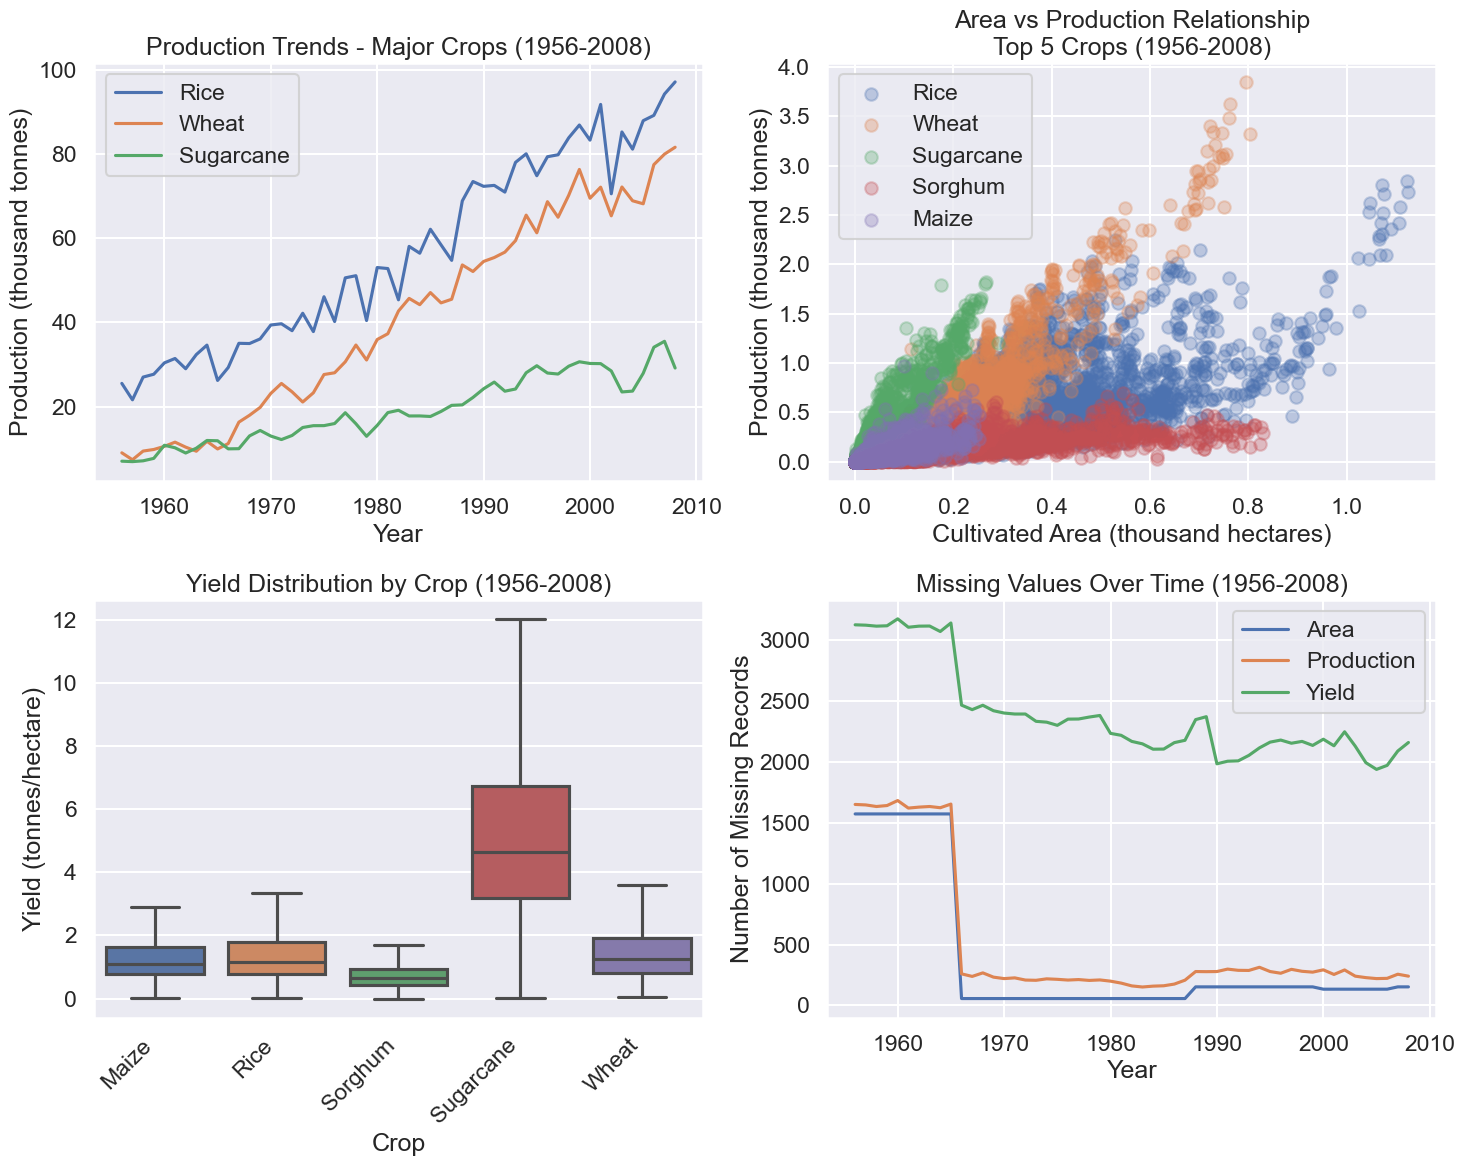

In [30]:
def perform_quality_assessment(filtered_data):
    """
    Comprehensive quality assessment of the filtered dataset
    """
    # 1. Outlier Detection
    def detect_outliers(group):
        q1 = group.quantile(0.25)
        q3 = group.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return ((group < lower_bound) | (group > upper_bound)).sum()

    # Calculate outliers by crop and metric
    outliers = filtered_data.groupby('crop').agg({
        'area': detect_outliers,
        'production': detect_outliers,
        'yield': detect_outliers
    })

    # 2. Temporal Consistency Check
    yearly_stats = filtered_data.groupby(['year', 'crop']).agg({
        'area': 'sum',
        'production': 'sum'
    }).reset_index()

    # 3. Select top 5 crops by total production
    top_5_crops = (filtered_data.groupby('crop')['production']
                  .sum()
                  .sort_values(ascending=False)
                  .head(5)
                  .index.tolist())
    
    print("\nTop 5 crops by total production:")
    print(top_5_crops)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Production trends over time for major crops
    for crop in top_5_crops[:3]:  # Using top 3 for clarity
        crop_data = yearly_stats[yearly_stats['crop'] == crop]
        axes[0,0].plot(crop_data['year'], crop_data['production'] / 1000, label=crop)
    axes[0,0].set_title('Production Trends - Major Crops (1956-2008)')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Production (thousand tonnes)')
    axes[0,0].legend()
    
    # Plot 2: Area vs Production scatter for top 5 crops
    for crop in top_5_crops:
        crop_data = filtered_data[filtered_data['crop'] == crop]
        axes[0,1].scatter(crop_data['area'] / 1000, 
                         crop_data['production'] / 1000, 
                         alpha=0.3, 
                         label=crop)
    axes[0,1].set_title('Area vs Production Relationship\nTop 5 Crops (1956-2008)')
    axes[0,1].set_xlabel('Cultivated Area (thousand hectares)')
    axes[0,1].set_ylabel('Production (thousand tonnes)')
    axes[0,1].legend()
    
    # Plot 3: Yield distribution by crop
    yield_data = filtered_data[filtered_data['crop'].isin(top_5_crops)].copy()
    
    # Calculate reasonable limits for each crop separately
    for crop in top_5_crops:
        crop_data = yield_data[yield_data['crop'] == crop]
        q1 = crop_data['yield'].quantile(0.25)
        q3 = crop_data['yield'].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        
        # Filter extreme outliers for this crop
        yield_data.loc[yield_data['crop'] == crop, 'yield'] = \
            yield_data.loc[yield_data['crop'] == crop, 'yield'].clip(upper=upper_limit)
    
    # Create boxplot with filtered data
    sns.boxplot(data=yield_data, x='crop', y='yield', ax=axes[1,0])
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45, ha='right')
    axes[1,0].set_title('Yield Distribution by Crop (1956-2008)')
    axes[1,0].set_xlabel('Crop')
    axes[1,0].set_ylabel('Yield (tonnes/hectare)')
    
    # Plot 4: Missing values by year
    yearly_missing = filtered_data.groupby('year').agg({
        'area': lambda x: x.isnull().sum(),
        'production': lambda x: x.isnull().sum(),
        'yield': lambda x: x.isnull().sum()
    })
    yearly_missing.plot(ax=axes[1,1])
    axes[1,1].set_title('Missing Values Over Time (1956-2008)')
    axes[1,1].set_xlabel('Year')
    axes[1,1].set_ylabel('Number of Missing Records')
    axes[1,1].legend(['Area', 'Production', 'Yield'])
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'quality_assessment.png', dpi=300, bbox_inches='tight')
    
    # 4. Spatial Consistency Check
    spatial_stats = filtered_data.groupby(['ST_1971', 'crop']).agg({
        'area': ['mean', 'std'],
        'production': ['mean', 'std']
    }).reset_index()
    
    return {
        'outliers': outliers,
        'yearly_stats': yearly_stats,
        'spatial_stats': spatial_stats,
        'top_crops': top_5_crops
    }

# Run quality assessment
quality_results = perform_quality_assessment(filtered_data)

### 2.4 Summary of Data Quality Assessment and Next Steps

Our comprehensive data quality assessment reveals several key insights:

1. **Data Coverage and Quality:**
   - Complete temporal coverage from 1956 to 2008, with significantly improved data quality post-1970
   - Five dominant crops identified: Rice, Wheat, Sugarcane, Sorghum, and Maize
   - Notable reduction in missing values after 1970 for area and production metrics

2. **Production Patterns:**
   - Clear upward trends in production, particularly for Rice and Wheat
   - Strong area-production relationships with crop-specific efficiency patterns
   - Distinct yield characteristics across crops, with Sugarcane showing consistently higher yields

Based on these findings, our subsequent analysis will:
1. Focus on the post-1970 period to ensure data reliability
2. Proceed with climate hazard indicator development, prioritizing these five major crops
3. Consider crop-specific characteristics when selecting and calculating climate indicators

Next step: We will identify and develop appropriate climate hazard indicators that align with our temporal coverage (1970-2008) and spatial resolution (district level), following the methodology outlined in Section 1.4.

---

# 3. Climate Hazard Indicator Development

## 3.1 Environment Setup and Climate Data Acquisition

Before developing our climate hazard indicators, we need to:
1. Set up our environment with additional climate-specific libraries.
2. Define our climate data source.
3. Create helper functions for downloading and processing climate data.

**Dataset Selection:**    
For this analysis, it is crucial to select a climate dataset that has both spatial and temporal overlap with our production dataset (1970–2008). Although freely available datasets (e.g., NOAA, CHIRPS, etc.) exist, CHIRPS only begins in 1981 and does not cover our full period of interest. Consequently, we have selected **ERA 5** as our climate data source because it provides comprehensive reanalysis data (including precipitation, temperature, and other key variables) starting from 1970 onward.


In [31]:
# Essential libraries 
import xarray as xr
import rioxarray
from pathlib import Path
import requests
from datetime import datetime, timedelta
import cdsapi
import zipfile
import calendar
import shutil
import time
import regionmask
from shapely.geometry import mapping
import itertools
import json

# Note: warnings, pandas, and geopandas are already imported at the beginning of the project.

# Configure warnings and display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Define paths
DATA_DIR = Path('./data')
CLIMATE_DIR = DATA_DIR / 'climate'
OUTPUT_DIR = Path('./outputs')

# Create necessary directories if they don't exist
CLIMATE_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

# Load our spatial reference data (district boundaries)
districts_gdf = gpd.read_file(DATA_DIR / 'india_districts_71.shp')

# Display basic information about our spatial reference
print("Spatial Reference Information:")
print("-" * 50)
print(f"Number of districts: {len(districts_gdf)}")
print(f"CRS: {districts_gdf.crs}")
print("\nBounding Box:")
print(f"North: {districts_gdf.total_bounds[3]:.2f}")
print(f"South: {districts_gdf.total_bounds[1]:.2f}")
print(f"East: {districts_gdf.total_bounds[2]:.2f}")
print(f"West: {districts_gdf.total_bounds[0]:.2f}")


Spatial Reference Information:
--------------------------------------------------
Number of districts: 361
CRS: EPSG:4326

Bounding Box:
North: 35.50
South: 6.75
East: 97.42
West: 68.19


## 3.2 Climate Data Source Configuration

For our analysis, we require a climate dataset that fully overlaps with our production dataset (1970–2008) both temporally and spatially. We have selected **ERA5** reanalysis data because it provides daily information at 0.25° resolution for the full study period. 

Our analysis will use ERA5 data for the following variables:
- **Total Precipitation (tp)**: To assess moisture availability
- **Maximum/Minimum 2m Temperature (mx2t/mn2t)**: To capture thermal extremes
- **Surface Net Solar Radiation (ssr)**: For energy balance and potential evapotranspiration
- **2m Dewpoint Temperature (d2m)**: To derive humidity-related indicators

Note: While relative humidity isn't directly available in ERA5's daily data, we can derive it from dewpoint temperature and air temperature using standard meteorological formulae.

In [32]:
def setup_climate_sources():
    """
    Configure and validate the ERA5 climate data source.
    Returns a dictionary with spatial parameters and ERA5 source configuration.
    """
    # Define spatial parameters based on our districts shapefile bounds
    spatial_params = {
        'lon_min': 68.0,  # Rounded from 68.19
        'lon_max': 98.0,  # Rounded from 97.42
        'lat_min': 6.5,   # Rounded from 6.75
        'lat_max': 36.0,  # Rounded from 35.50
    }
    
    # ERA5 configuration with selected variables
    era5_config = {
        'resolution': 0.25,
        'variables': [
            'total_precipitation',                                    # Daily total precipitation
            'maximum_2m_temperature_since_previous_post_processing',  # Daily max temperature
            'minimum_2m_temperature_since_previous_post_processing',  # Daily min temperature
            'surface_net_solar_radiation',                           # Solar radiation at surface
            '2m_dewpoint_temperature'                                # Dewpoint temperature
        ],
        'units': {
            'total_precipitation': 'm',        # Will be converted to mm
            'temperature': 'K',                # Will be converted to °C
            'solar_radiation': 'J m**-2',      # Accumulated energy over timestep
            'dewpoint_temperature': 'K'        # Will be converted to °C
        }
    }
    
    # Helper function to calculate grid points based on the given configuration
    def calculate_grid_points(config):
        lon_points = np.arange(
            spatial_params['lon_min'],
            spatial_params['lon_max'] + config['resolution'],
            config['resolution']
        )
        lat_points = np.arange(
            spatial_params['lat_min'],
            spatial_params['lat_max'] + config['resolution'],
            config['resolution']
        )
        return len(lon_points), len(lat_points)
    
    # Calculate grid size for ERA5 data
    era5_grid = calculate_grid_points(era5_config)
    
    print("Climate Data Source Configuration:")
    print("-" * 50)
    print("\nERA5 Configuration:")
    print(f"Resolution: {era5_config['resolution']}°")
    print(f"Grid size: {era5_grid[0]}x{era5_grid[1]} points")
    print(f"Variables: {', '.join(era5_config['variables'])}")
    
    return {
        'spatial_params': spatial_params,
        'era5_config': era5_config
    }

# Run the configuration setup
climate_configs = setup_climate_sources()

Climate Data Source Configuration:
--------------------------------------------------

ERA5 Configuration:
Resolution: 0.25°
Grid size: 121x119 points
Variables: total_precipitation, maximum_2m_temperature_since_previous_post_processing, minimum_2m_temperature_since_previous_post_processing, surface_net_solar_radiation, 2m_dewpoint_temperature


## 3.3 ERA5 Climate Data Download and Organization

### 3.3.1 Data Download Process
The download of ERA5 reanalysis data was managed through a dedicated Python script (`era5-download-manager.py`) that implements a robust download manager class. This approach was chosen to ensure reliable acquisition of the large volume of climate data covering our study period (1970-2008).

The download manager handled the following key variables:
- Total Precipitation (tp)
- Maximum 2m Temperature (mx2t)
- Minimum 2m Temperature (mn2t)
- Surface Net Solar Radiation (ssr)
- 2m Dewpoint Temperature (d2m)

For each month in our study period, the manager downloads data at two daily timesteps (00:00 and 12:00 UTC) to capture diurnal variations. The downloaded data comes in three separate NetCDF files per month, each corresponding to different temporal aggregation types:
- Instantaneous values (`stepType-instant.nc`)
- Accumulated values (`stepType-accum.nc`)
- Maximum/Minimum values (`stepType-max.nc`)

### 3.3.2 Data Organization Structure
The climate data is organized in a hierarchical directory structure that facilitates both data management and analysis:

```
climate/
├── raw/                               # Contains downloaded ERA5 data
│   ├── 1970/                         # Year-wise organization
│   │   ├── era5_daily_india_1970_01.zip  # January data
│   │   ├── era5_daily_india_1970_02.zip  # February data
│   │   └── ...
│   └── ...                           # Subsequent years until 2008
├── processed/                         # Contains derived products
│   ├── aggregated/                   # Temporal aggregations
│   │   └── daily/                    # Processed daily data
│   └── indicators/                   # Climate hazard indicators
│       ├── monthly_precip/           # Monthly precipitation totals
│       ├── monthly_gdd/              # Growing Degree Days
│       ├── extreme_temp_days/        # Days exceeding 35°C
│       ├── monthly_hhi/              # Heat-Humidity Index
│       └── hot_dry_days/             # Combined temperature-precipitation stress
└── metadata/                         # Processing documentation
    ├── logs/                         # Processing logs
    │   ├── monthly_precip_processing_log.csv
    │   ├── monthly_gdd_processing_log.csv
    │   ├── extreme_temp_days_processing_log.csv
    │   ├── monthly_hhi_processing_log.csv
    │   └── hot_dry_days_processing_log.csv
    └── validation/                   # Quality assessment results
        ├── monthly_precip_*_validation.json
        ├── monthly_gdd_*_validation.json
        ├── extreme_temp_days_*_validation.json
        ├── monthly_hhi_*_validation.json
        └── hot_dry_days_*_validation.json
```

### 3.3.3 Data Specifications
Each indicator dataset will be stored in NetCDF format with the following characteristics:
- Spatial Resolution: 0.25° × 0.25°
- Spatial Coverage: India's administrative boundaries
- Temporal Resolution: Monthly
- Grid Size: 351 districts

#### Indicator List:
1. **Monthly Precipitation (monthly_precip):**
2. **Growing Degree Days (monthly_gdd):**
3. **Extreme Temperature Days (extreme_temp_days):**
4. **Heat-Humidity Index (monthly_hhi):**
5. **Hot-Dry Days (hot_dry_days):**

## 3.4 Climate Data Processing and Indicator Calculation

### 3.4.1 Data Processing Strategy
Before calculating climate hazard indicators, we need to process our raw ERA5 data through several steps:
1. Converting units to standard meteorological units (°C, mm/day)
2. Deriving relative humidity from temperature and dewpoint temperature
3. Aggregating sub-daily values to daily statistics
4. Masking data to India's administrative boundaries to ensure:
   - Accurate statistical calculations
   - Computational efficiency
   - Relevant spatial coverage

We'll create a processing pipeline that:
- Handles one year of data at a time to manage memory efficiently
- Processes each variable according to its temporal aggregation type
- Applies spatial masking using district boundaries
- Saves intermediary results in the processed/aggregated/daily directory

In [33]:
def check_processed_file_exists(year: int, month: int, processed_dir=None):
    """
    Check if processed ERA5 file already exists.
    
    Parameters:
    -----------
    year : int
        Year to check
    month : int
        Month to check
    processed_dir : Path, optional
        Directory containing processed files
        
    Returns:
    --------
    bool
        True if file exists, False otherwise
    """
    processed_dir = processed_dir or CLIMATE_DIR / 'processed' / 'aggregated' / 'daily' / str(year)
    output_file = processed_dir / f'daily_values_{year}_{month:02d}.nc'
    return output_file.exists()

def process_era5_data(year: int, month: int):
    """
    Process ERA5 data for a given year and month, converting units and calculating daily values.
    
    Parameters:
    -----------
    year : int
        Year to process
    month : int
        Month to process
    """
    # Define paths
    raw_file = CLIMATE_DIR / 'raw' / str(year) / f'era5_daily_india_{year}_{month:02d}.zip'
    temp_dir = CLIMATE_DIR / 'temp' / f'{year}_{month:02d}'
    processed_dir = CLIMATE_DIR / 'processed' / 'aggregated' / 'daily' / str(year)
    shapefile_path = DATA_DIR / 'india_districts_71.shp'
    
    # Create necessary directories
    temp_dir.mkdir(parents=True, exist_ok=True)
    processed_dir.mkdir(parents=True, exist_ok=True)
    
    try:
        # Extract files
        with zipfile.ZipFile(raw_file, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)
        
        # Load different types of data
        ds_instant = xr.open_dataset(temp_dir / 'data_stream-oper_stepType-instant.nc')
        ds_accum = xr.open_dataset(temp_dir / 'data_stream-oper_stepType-accum.nc')
        ds_max = xr.open_dataset(temp_dir / 'data_stream-oper_stepType-max.nc')
        
        # Find the time dimension and standardize to 'time'
        time_dim = 'valid_time' if 'valid_time' in ds_max.dims else 'time'
        
        # Process temperatures (convert K to °C)
        ds_max['mx2t'] = ds_max['mx2t'] - 273.15
        ds_max['mn2t'] = ds_max['mn2t'] - 273.15
        ds_instant['d2m'] = ds_instant['d2m'] - 273.15
        
        # Process precipitation (convert m to mm)
        ds_accum['tp'] = ds_accum['tp'] * 1000
        
        # Calculate relative humidity
        def calculate_rh(t, td):
            """Calculate relative humidity using August-Roche-Magnus approximation"""
            a = 17.625
            b = 243.04
            rh = 100 * np.exp(a * td / (b + td)) / np.exp(a * t / (b + t))
            return np.clip(rh, 0, 100)
        
        # Calculate daily values
        daily_data = xr.Dataset({
            'tmax': ds_max['mx2t'].resample({time_dim: '1D'}).max(),
            'tmin': ds_max['mn2t'].resample({time_dim: '1D'}).min(),
            'precip': ds_accum['tp'].resample({time_dim: '1D'}).sum(),
            'solar': ds_accum['ssr'].resample({time_dim: '1D'}).sum(),
            'rh': calculate_rh(
                ds_max['mx2t'].resample({time_dim: '1D'}).mean(),
                ds_instant['d2m'].resample({time_dim: '1D'}).mean()
            )
        })
        
        # Rename dimension to standardized 'time'
        if time_dim != 'time':
            daily_data = daily_data.rename({time_dim: 'time'})
        
        # Add units attributes
        daily_data['tmax'].attrs['units'] = 'celsius'
        daily_data['tmin'].attrs['units'] = 'celsius'
        daily_data['precip'].attrs['units'] = 'mm'
        daily_data['solar'].attrs['units'] = 'J m**-2'
        daily_data['rh'].attrs['units'] = 'percent'
        
        # Load the India shapefile
        india_shapefile = gpd.read_file(shapefile_path)
        india_shapefile = india_shapefile.to_crs("EPSG:4326")  # Ensure WGS84 lat/lon projection
        
        # Set spatial dimensions and CRS for the dataset
        daily_data = daily_data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
        daily_data.rio.write_crs("EPSG:4326", inplace=True)
        
        # Clip the dataset to India's boundaries
        daily_data_clipped = daily_data.rio.clip(india_shapefile.geometry.apply(mapping), india_shapefile.crs, drop=True)
        
        # Save processed and clipped data
        output_file = processed_dir / f'daily_values_{year}_{month:02d}.nc'
        daily_data_clipped.to_netcdf(output_file)
        
        # print(f"\nProcessed Data Summary for {year}-{month:02d}")
        # print("-" * 40)
        # print("Daily values calculated and saved:")
        # for var in daily_data_clipped.data_vars:
        #     print(f"- {var}: {daily_data_clipped[var].attrs.get('units', 'unknown units')}")
        #     print(f"  Range: {daily_data_clipped[var].min().values:.2f} to "
        #           f"{daily_data_clipped[var].max().values:.2f}")
        
        return daily_data_clipped
        
    finally:
        # Clean up temporary files
        if temp_dir.exists():
            shutil.rmtree(temp_dir)

# Test with a single month
try:
    test_data = process_era5_data(1970, 1)
except Exception as e:
    print(f"Error processing data: {str(e)}")


Now that we've validated our processing function, let's scale up to process all available ERA5 data (1970-2008) while maintaining a processing log for tracking and validation.

In [34]:
def process_era5_period(start_year: int, end_year: int):
    """
    Process ERA5 data for a range of years, skipping existing files.
    
    Parameters:
    -----------
    start_year : int
        First year to process
    end_year : int
        Last year to process
    """
    # Create log directory
    log_dir = CLIMATE_DIR / 'metadata' / 'logs'
    log_dir.mkdir(parents=True, exist_ok=True)
    
    log_data = []
    total_months = 0
    existing_count = 0
    processed_count = 0
    failed_count = 0
    
    print(f"\nProcessing ERA5 data from {start_year} to {end_year}")
    print("=" * 50)
    
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            total_months += 1
            try:
                if check_processed_file_exists(year, month):
                    # print(f"{year}-{month:02d}: Skipped (already exists)")
                    status = 'skipped'
                    error_msg = ''
                    existing_count += 1
                else:
                    _ = process_era5_data(year, month)
                    print(f"{year}-{month:02d}: Successfully processed")
                    status = 'success'
                    error_msg = ''
                    processed_count += 1
            except Exception as e:
                print(f"{year}-{month:02d}: Failed - {str(e)}")
                status = 'failed'
                error_msg = str(e)
                failed_count += 1
            
            # Add to log
            log_data.append({
                'year': year,
                'month': month,
                'status': status,
                'error': error_msg,
                'timestamp': pd.Timestamp.now()
            })
    
    # Save processing log
    log_df = pd.DataFrame(log_data)
    log_file = log_dir / 'era5_processing_log.csv'
    log_df.to_csv(log_file, index=False)
    
    # Print summary
    print("\nProcessing Summary")
    print("=" * 50)
    print(f"Total months: {total_months}")
    print(f"Already existed: {existing_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Failed: {failed_count}")
    print(f"\nProcessing log saved to: {log_file}")

# Usage is now simple:
process_era5_period(1970, 2008)


Processing ERA5 data from 1970 to 2008

Processing Summary
Total months: 468
Already existed: 468
Newly processed: 0
Failed: 0

Processing log saved to: data/climate/metadata/logs/era5_processing_log.csv


## **3.4.2 Climate Hazard Indicator Calculation**

After processing our daily ERA5 data, we will calculate six climate hazard indicators relevant to agricultural production in India:

### **Monthly Precipitation (monthly_precip)**
- Total monthly precipitation (mm)
- Captures overall water availability
- Base indicator for drought and excess rainfall analysis

### **Growing Degree Days (monthly_gdd)**
- Accumulated thermal units above base temperature (10°C)
- Critical for crop development and phenology
- Monthly aggregation of daily temperature accumulation

### **Extreme Temperature Days (extreme_temp_days)**
- Count of days exceeding crop-specific thresholds
- Captures exposure to damaging high temperatures
- Monthly counts of days above 35°C

### **Heat-Humidity Index (monthly_hhi)**
- Combines temperature and relative humidity
- Identifies periods of combined heat and moisture stress
- Monthly average of daily maximum temperature-humidity interactions

### **Hot-Dry Days (hot_dry_days)**
- Joint occurrence of high temperature and low precipitation
- Captures compound climate extremes
- Monthly count of days with temperature > 35°C and precipitation < 1mm

### **3.4.2.1 Monthly Precipitation (monthly_precip)**

#### Overview
Monthly precipitation totals provide a fundamental measure of water availability for agriculture. This indicator:
- Aggregates daily precipitation to monthly totals for each district
- Preserves spatial resolution of our ERA5 data (0.25°)
- Forms the basis for more complex precipitation-based indicators

#### Calculation Method
1. For each grid cell:
   - Sum daily precipitation values within each month
   - Convert units from mm/day to monthly totals (mm)
2. For each district:
   - Calculate area-weighted average of grid cells
   - Account for partial grid cell coverage
   - Store results in NetCDF format

#### Implementation
- Input: Daily precipitation from processed ERA5 data
- Output: Monthly district-level precipitation totals
- Storage: `/climate/processed/indicators/monthly_precip/`

In [35]:
def check_precip_exists(year, output_dir=None):
    """
    Check if monthly precipitation file already exists.
    
    Parameters:
    -----------
    year : int
        Year to check
    output_dir : Path, optional
        Directory containing the precipitation files
        
    Returns:
    --------
    bool
        True if file exists, False otherwise
    """
    output_dir = output_dir or Path('./data/climate/processed/indicators/monthly_precip')
    output_file = output_dir / f'monthly_precip_{year}.nc'
    return output_file.exists()

def calculate_monthly_precipitation(year, districts_gdf, climate_dir=None, output_dir=None):
    """
    Calculate monthly precipitation totals for each district.
    Skips computation if output file already exists.
    
    Parameters:
    -----------
    year : int
        Year to process
    districts_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing district boundaries
    climate_dir : Path, optional
        Directory containing processed daily climate data
    output_dir : Path, optional
        Directory to store the output files
    
    Returns:
    --------
    xarray.Dataset or None
        Dataset containing monthly precipitation totals if computed, None if skipped
    """
    # Set default paths
    climate_dir = climate_dir or Path('./data/climate/processed/aggregated/daily')
    output_dir = output_dir or Path('./data/climate/processed/indicators/monthly_precip')
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if file already exists
    if check_precip_exists(year, output_dir):
        print(f"Precipitation data for year {year} already exists. Skipping computation.")
        return None
    
    print(f"Computing precipitation for year {year}...")
    
    # List all daily files for the year
    daily_files = sorted(climate_dir.glob(f'{year}/daily_values_{year}_*.nc'))
    
    if not daily_files:
        raise FileNotFoundError(f"No daily precipitation files found for year {year}")
    
    # Load and concatenate all daily data for the year
    ds = xr.open_mfdataset(
        daily_files,
        combine='by_coords',
        chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
    )
    
    # Calculate monthly precipitation totals
    monthly_precip = ds['precip'].resample(time='1M').sum()
    
    # Create a dataset with the monthly precipitation
    ds_monthly = xr.Dataset({
        'precipitation': monthly_precip
    })
    
    # Add metadata
    ds_monthly.precipitation.attrs.update({
        'units': 'mm',
        'long_name': 'Monthly Total Precipitation',
        'standard_name': 'precipitation_amount',
        'cell_methods': 'time: sum',
        'comment': 'Sum of daily precipitation values'
    })
    
    # Set spatial dimensions and CRS
    ds_monthly = ds_monthly.rio.write_crs("EPSG:4326")
    ds_monthly = ds_monthly.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    
    # Add global attributes
    ds_monthly.attrs.update({
        'title': 'Monthly Precipitation Totals',
        'summary': 'Monthly accumulated precipitation from ERA5 reanalysis',
        'source': 'ERA5 reanalysis',
        'creation_date': pd.Timestamp.now().isoformat(),
        'processing_steps': 'Daily precipitation values summed to monthly totals at each grid point',
        'crs': 'EPSG:4326',
        'institution': 'Processed by CIAT Climate Analysis',
        'version': '1.0',
        'time_coverage_start': str(ds_monthly.time.values[0]),
        'time_coverage_end': str(ds_monthly.time.values[-1]),
        'validation_log': f'data/climate/metadata/logs/monthly_precip_validation_{year}.csv'
    })
    
    # Calculate area-weighted district averages
    districts = []
    
    # Ensure districts GeoDataFrame is in WGS84
    districts_gdf = districts_gdf.to_crs("EPSG:4326")
    
    for idx, district in districts_gdf.iterrows():
        try:
            # Clip data to district boundary
            district_geometry = mapping(district.geometry)
            district_data = ds_monthly.rio.clip([district_geometry], districts_gdf.crs)
            
            # Calculate area-weighted mean
            weights = np.cos(np.deg2rad(district_data.latitude))
            district_mean = district_data.precipitation.weighted(weights).mean(
                dim=['latitude', 'longitude']
            )
            
            # Store district information
            district_mean = district_mean.assign_coords({
                'district': district['DS_1971'],
                'state': district['ST_1971']
            })
            districts.append(district_mean)
            
        except Exception as e:
            print(f"Error processing district {district['DS_1971']}: {str(e)}")
            continue
    
    # Combine all districts
    district_precip = xr.concat(districts, dim='district')
    
    # Save to NetCDF
    output_file = output_dir / f'monthly_precip_{year}.nc'
    district_precip.to_netcdf(output_file)
    
    print(f"Processed monthly precipitation for {year}")
    print(f"Output saved to: {output_file}")
    
    return district_precip

def process_all_years(start_year=1970, end_year=2008, districts_file=None):
    """
    Process monthly precipitation for all years in the range, skipping existing files.
    
    Parameters:
    -----------
    start_year : int
        First year to process
    end_year : int
        Last year to process
    districts_file : str or Path, optional
        Path to the districts shapefile
    """
    # Load district boundaries
    districts_file = districts_file or Path('./data/india_districts_71.shp')
    districts_gdf = gpd.read_file(districts_file)
    
    # Initialize counters
    total_years = end_year - start_year + 1
    existing_count = 0
    processed_count = 0
    failed_count = 0
    log_data = []
    
    print(f"\nProcessing precipitation data from {start_year} to {end_year}")
    print("=" * 50)
    
    # Process each year
    for year in range(start_year, end_year + 1):
        try:
            if check_precip_exists(year):
                # print(f"Year {year}: Skipped (already exists)")
                status = 'skipped'
                error_msg = ''
                existing_count += 1
            else:
                _ = calculate_monthly_precipitation(year, districts_gdf)
                print(f"Year {year}: Successfully processed")
                status = 'success'
                error_msg = ''
                processed_count += 1
        except Exception as e:
            print(f"Year {year}: Failed - {str(e)}")
            status = 'failed'
            error_msg = str(e)
            failed_count += 1
        
        # Add to log
        log_data.append({
            'year': year,
            'status': status,
            'error': error_msg,
            'timestamp': pd.Timestamp.now()
        })
    
    # Save processing log
    log_df = pd.DataFrame(log_data)
    log_file = Path('./data/climate/metadata/logs/monthly_precip_processing_log.csv')
    log_file.parent.mkdir(parents=True, exist_ok=True)
    log_df.to_csv(log_file, index=False)
    
    # Print summary
    print("\nProcessing Summary")
    print("=" * 50)
    print(f"Total years: {total_years}")
    print(f"Already existed: {existing_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Failed: {failed_count}")
    print(f"\nProcessing log saved to: {log_file}")

# Example usage
if __name__ == "__main__":
    # Process all years, skipping existing files
    process_all_years(1970, 2008)


Processing precipitation data from 1970 to 2008

Processing Summary
Total years: 39
Already existed: 39
Newly processed: 0
Failed: 0

Processing log saved to: data/climate/metadata/logs/monthly_precip_processing_log.csv


In [36]:
def inspect_monthly_precip_file(year, data_dir=None):
    """
    Inspect monthly precipitation indicator file for quality assurance.
    
    Parameters:
    -----------
    year : int
        Year to inspect
    data_dir : Path, optional
        Directory containing the monthly precipitation files
        
    Returns:
    --------
    dict
        Dictionary containing validation results
    """
    # Set default data directory if not provided
    data_dir = data_dir or Path('./data/climate/processed/indicators/monthly_precip')
    
    # Construct file path
    file_path = data_dir / f'monthly_precip_{year}.nc'
    
    if not file_path.exists():
        raise FileNotFoundError(f"No monthly precipitation file found for year {year}")
    
    print(f"\nInspecting Monthly Precipitation Data for {year}")
    print("=" * 50)
    
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # 1. Check Data Structure
    print("\n1. Data Structure:")
    print("-" * 20)
    print("\nDimensions:")
    for dim, size in ds.dims.items():
        print(f"{dim}: {size}")
    
    print("\nVariables:")
    for var in ds.data_vars:
        print(f"\n{var}:")
        print(f"  Shape: {ds[var].shape}")
        print(f"  Dtype: {ds[var].dtype}")
        print(f"  Units: {ds[var].attrs.get('units', 'Not specified')}")
    
    # 2. Check Temporal Coverage
    print("\n2. Temporal Coverage:")
    print("-" * 20)
    time_vals = pd.DatetimeIndex(ds.time.values)
    print(f"Start date: {time_vals[0]}")
    print(f"End date: {time_vals[-1]}")
    print(f"Number of time steps: {len(time_vals)}")
    
    # Check for temporal gaps
    expected_months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='M')
    missing_months = set(expected_months) - set(time_vals)
    if missing_months:
        print("\nWarning: Missing months detected:")
        for month in sorted(missing_months):
            print(f"  - {month.strftime('%Y-%m')}")
    
    # 3. Check Value Analysis
    print("\n3. Value Analysis:")
    print("-" * 20)
    precip = ds.precipitation
    
    # Overall statistics
    print("\nOverall Statistics:")
    print(f"Mean: {float(precip.mean()):.2f} mm")
    print(f"Min: {float(precip.min()):.2f} mm")
    print(f"Max: {float(precip.max()):.2f} mm")
    
    # Monthly statistics
    print("\nMonthly Statistics:")
    for month in range(len(time_vals)):
        month_data = precip.isel(time=month)
        print(f"\nMonth {time_vals[month].strftime('%m')}:")
        print(f"  Mean: {float(month_data.mean()):.2f} mm")
        print(f"  Min: {float(month_data.min()):.2f} mm")
        print(f"  Max: {float(month_data.max()):.2f} mm")
        print(f"  Zeros: {int((month_data == 0).sum())} districts")
        print(f"  NaN count: {int(month_data.isnull().sum())} districts")
    
    # 4. Check District Coverage
    print("\n4. District Coverage:")
    print("-" * 20)
    print(f"Number of districts: {ds.dims['district']}")
    
    # Sample of districts
    print("\nSample of districts (first 5):")
    try:
        for i in range(min(5, len(ds.district))):
            district_name = ds.district.values[i]
            print(f"  - {district_name}")
    except:
        print("  Unable to display district names")
    
    # 5. Check Metadata
    print("\n5. Metadata Check:")
    print("-" * 20)
    print("\nGlobal Attributes:")
    for attr, value in ds.attrs.items():
        print(f"{attr}: {value}")
    
    print("\nVariable Attributes (precipitation):")
    for attr, value in ds.precipitation.attrs.items():
        print(f"{attr}: {value}")
    
    # 6. Data Quality Metrics
    print("\n6. Data Quality Metrics:")
    print("-" * 20)
    
    # Check for missing values
    missing = ds.precipitation.isnull().sum().item()
    total = ds.precipitation.size
    print(f"\nMissing values: {missing} ({(missing/total)*100:.2f}%)")
    
    # Check for suspicious patterns
    zero_count = (ds.precipitation == 0).sum().item()
    print(f"Zero values: {zero_count} ({(zero_count/total)*100:.2f}%)")
    
    # Monthly completeness
    print("\nMonthly completeness:")
    for month in range(len(time_vals)):
        month_data = precip.isel(time=month)
        valid_data = (~month_data.isnull()).sum().item()
        print(f"  {time_vals[month].strftime('%Y-%m')}: "
              f"{valid_data}/{ds.dims['district']} districts "
              f"({(valid_data/ds.dims['district'])*100:.1f}%)")
    
    # Return validation results
    validation_results = {
        'year': year,
        'file_path': str(file_path),
        'temporal_coverage': {
            'start': str(time_vals[0]),
            'end': str(time_vals[-1]),
            'missing_months': sorted(missing_months) if missing_months else None
        },
        'value_ranges': {
            'mean': float(precip.mean()),
            'min': float(precip.min()),
            'max': float(precip.max())
        },
        'coverage': {
            'total_districts': int(ds.dims['district']),
            'complete_districts': int((~precip.isnull()).all().sum())
        },
        'quality_metrics': {
            'missing_values': int(missing),
            'zero_values': int(zero_count),
            'total_values': int(total)
        }
    }
    
    ds.close()
    return validation_results


try:
    # Inspect a specific year
    results = inspect_monthly_precip_file(2000)
    
    # Save validation results
    output_file = Path('./data/climate/metadata/validation/monthly_precip_2000_validation.json')
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
        
    print(f"\nValidation results saved to: {output_file}")
    
except Exception as e:
    print(f"Error during inspection: {str(e)}")


Inspecting Monthly Precipitation Data for 2000

1. Data Structure:
--------------------

Dimensions:
time: 12
district: 351

Variables:

precipitation:
  Shape: (351, 12)
  Dtype: float64
  Units: Not specified

2. Temporal Coverage:
--------------------
Start date: 2000-01-31 00:00:00
End date: 2000-12-31 00:00:00
Number of time steps: 12

3. Value Analysis:
--------------------

Overall Statistics:
Mean: 8.98 mm
Min: 0.00 mm
Max: 68.67 mm

Monthly Statistics:

Month 01:
  Mean: 1.72 mm
  Min: 0.00 mm
  Max: 27.90 mm
  Zeros: 29 districts
  NaN count: 0 districts

Month 02:
  Mean: 3.23 mm
  Min: 0.00 mm
  Max: 31.53 mm
  Zeros: 9 districts
  NaN count: 0 districts

Month 03:
  Mean: 2.24 mm
  Min: 0.00 mm
  Max: 30.58 mm
  Zeros: 32 districts
  NaN count: 0 districts

Month 04:
  Mean: 4.68 mm
  Min: 0.00 mm
  Max: 53.80 mm
  Zeros: 2 districts
  NaN count: 0 districts

Month 05:
  Mean: 10.29 mm
  Min: 0.38 mm
  Max: 61.68 mm
  Zeros: 0 districts
  NaN count: 0 districts

Month 06:

### **3.4.2.2 Monthly Growing Degree Days (monthly_gdd)**
#### Overview
Monthly Growing Degree Days provide a measure of heat accumulation that drives crop phenological development. This indicator:
- Calculates daily GDD using maximum and minimum temperatures
- Aggregates daily GDD to monthly totals for each district
- Uses base temperature of 10°C (standard for many crops)
#### Calculation Method
1. For each day:
- Calculate GDD = max(0, (Tmax + Tmin)/2 - Tbase)
  - Where Tbase = 10°C
  - Daily values capped at 30°C to account for temperature stress
2. For each month:
- Sum daily GDD values
3. For each district:
- Calculate area-weighted average of grid cells
- Store results in NetCDF format
#### Implementation
- Input: Daily temperature (Tmax, Tmin) from processed ERA5 data
- Output: Monthly district-level GDD totals
- Storage: `/climate/processed/indicators/monthly_gdd/`

In [37]:
def check_gdd_exists(year, output_dir=None):
    """
    Check if monthly GDD file already exists.
    
    Parameters:
    -----------
    year : int
        Year to check
    output_dir : Path, optional
        Directory containing the GDD files
        
    Returns:
    --------
    bool
        True if file exists, False otherwise
    """
    output_dir = output_dir or Path('./data/climate/processed/indicators/monthly_gdd')
    output_file = output_dir / f'monthly_gdd_{year}.nc'
    return output_file.exists()

def calculate_daily_gdd(tmax, tmin, tbase=10, tcap=30):
    """
    Calculate daily Growing Degree Days.
    
    Parameters:
    -----------
    tmax : xarray.DataArray
        Maximum daily temperature (°C)
    tmin : xarray.DataArray
        Minimum daily temperature (°C)
    tbase : float
        Base temperature (°C)
    tcap : float
        Temperature cap (°C)
    
    Returns:
    --------
    xarray.DataArray
        Daily GDD values
    """
    # Cap maximum temperature
    tmax_capped = tmax.clip(max=tcap)
    
    # Calculate mean daily temperature
    tmean = (tmax_capped + tmin) / 2
    
    # Calculate GDD
    gdd = tmean - tbase
    
    # Set negative values to zero
    return gdd.clip(min=0)

def calculate_monthly_gdd(year, districts_gdf, climate_dir=None, output_dir=None):
    """
    Calculate monthly GDD totals for each district.
    Skips computation if output file already exists.
    
    Parameters:
    -----------
    year : int
        Year to process
    districts_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing district boundaries
    climate_dir : Path, optional
        Directory containing processed daily climate data
    output_dir : Path, optional
        Directory to store the output files
    
    Returns:
    --------
    xarray.Dataset or None
        Dataset containing monthly GDD totals if computed, None if skipped
    """
    # Set default paths
    climate_dir = climate_dir or Path('./data/climate/processed/aggregated/daily')
    output_dir = output_dir or Path('./data/climate/processed/indicators/monthly_gdd')
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if file already exists
    if check_gdd_exists(year, output_dir):
        print(f"GDD data for year {year} already exists. Skipping computation.")
        return None
    
    print(f"Computing GDD for year {year}...")
    
    # List all daily files for the year
    daily_files = sorted(climate_dir.glob(f'{year}/daily_values_{year}_*.nc'))
    
    if not daily_files:
        raise FileNotFoundError(f"No daily temperature files found for year {year}")
    
    # Load and concatenate all daily data for the year
    ds = xr.open_mfdataset(
        daily_files,
        combine='by_coords',
        chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
    )
    
    # Calculate daily GDD
    daily_gdd = calculate_daily_gdd(ds['tmax'], ds['tmin'])
    
    # Calculate monthly GDD totals
    monthly_gdd = daily_gdd.resample(time='1M').sum()
    
    # Create a dataset with the monthly GDD
    ds_monthly = xr.Dataset({
        'gdd': monthly_gdd
    })
    
    # Add metadata
    ds_monthly.gdd.attrs.update({
        'units': 'degree_days',
        'long_name': 'Monthly Growing Degree Days',
        'base_temperature': '10 degC',
        'cap_temperature': '30 degC',
        'cell_methods': 'time: sum',
        'comment': 'Sum of daily growing degree days (base 10°C, cap 30°C)'
    })
    
    # Set spatial dimensions and CRS
    ds_monthly = ds_monthly.rio.write_crs("EPSG:4326")
    ds_monthly = ds_monthly.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    
    # Calculate area-weighted district averages
    districts = []
    
    # Ensure districts GeoDataFrame is in WGS84
    districts_gdf = districts_gdf.to_crs("EPSG:4326")
    
    for idx, district in districts_gdf.iterrows():
        try:
            # Clip data to district boundary
            district_geometry = mapping(district.geometry)
            district_data = ds_monthly.rio.clip([district_geometry], districts_gdf.crs)
            
            # Calculate area-weighted mean
            weights = np.cos(np.deg2rad(district_data.latitude))
            district_mean = district_data.gdd.weighted(weights).mean(
                dim=['latitude', 'longitude']
            )
            
            # Store district information
            district_mean = district_mean.assign_coords({
                'district': district['DS_1971'],
                'state': district['ST_1971']
            })
            districts.append(district_mean)
            
        except Exception as e:
            print(f"Error processing district {district['DS_1971']}: {str(e)}")
            continue
    
    # Combine all districts
    district_gdd = xr.concat(districts, dim='district')
    
    # Save to NetCDF
    output_file = output_dir / f'monthly_gdd_{year}.nc'
    district_gdd.to_netcdf(output_file)
    
    print(f"Processed monthly GDD for {year}")
    print(f"Output saved to: {output_file}")
    
    return district_gdd

def process_all_years(start_year=1970, end_year=2008, districts_file=None):
    """
    Process monthly GDD for all years in the range, skipping existing files.
    
    Parameters:
    -----------
    start_year : int
        First year to process
    end_year : int
        Last year to process
    districts_file : str or Path, optional
        Path to the districts shapefile
    """
    # Load district boundaries
    districts_file = districts_file or Path('./data/india_districts_71.shp')
    districts_gdf = gpd.read_file(districts_file)
    
    # Initialize counters
    total_years = end_year - start_year + 1
    existing_count = 0
    processed_count = 0
    failed_count = 0
    log_data = []
    
    print(f"\nProcessing GDD data from {start_year} to {end_year}")
    print("=" * 50)
    
    # Process each year
    for year in range(start_year, end_year + 1):
        try:
            if check_gdd_exists(year):
                # print(f"Year {year}: Skipped (already exists)")
                status = 'skipped'
                error_msg = ''
                existing_count += 1
            else:
                _ = calculate_monthly_gdd(year, districts_gdf)
                print(f"Year {year}: Successfully processed")
                status = 'success'
                error_msg = ''
                processed_count += 1
        except Exception as e:
            print(f"Year {year}: Failed - {str(e)}")
            status = 'failed'
            error_msg = str(e)
            failed_count += 1
        
        # Add to log
        log_data.append({
            'year': year,
            'status': status,
            'error': error_msg,
            'timestamp': pd.Timestamp.now()
        })
    
    # Save processing log
    log_df = pd.DataFrame(log_data)
    log_file = Path('./data/climate/metadata/logs/monthly_gdd_processing_log.csv')
    log_file.parent.mkdir(parents=True, exist_ok=True)
    log_df.to_csv(log_file, index=False)
    
    # Print summary
    print("\nProcessing Summary")
    print("=" * 50)
    print(f"Total years: {total_years}")
    print(f"Already existed: {existing_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Failed: {failed_count}")
    print(f"\nProcessing log saved to: {log_file}")

# Example usage
if __name__ == "__main__":
    # Process all years, skipping existing files
    process_all_years(1970, 2008)


Processing GDD data from 1970 to 2008

Processing Summary
Total years: 39
Already existed: 39
Newly processed: 0
Failed: 0

Processing log saved to: data/climate/metadata/logs/monthly_gdd_processing_log.csv


In [38]:
def inspect_monthly_gdd_file(year, data_dir=None):
    """
    Inspect monthly GDD indicator file for quality assurance.
    
    Parameters:
    -----------
    year : int
        Year to inspect
    data_dir : Path, optional
        Directory containing the monthly GDD files
        
    Returns:
    --------
    dict
        Dictionary containing validation results
    """
    # Set default data directory if not provided
    data_dir = data_dir or Path('./data/climate/processed/indicators/monthly_gdd')
    
    # Construct file path
    file_path = data_dir / f'monthly_gdd_{year}.nc'
    
    if not file_path.exists():
        raise FileNotFoundError(f"No monthly GDD file found for year {year}")
    
    print(f"\nInspecting Monthly Growing Degree Days Data for {year}")
    print("=" * 50)
    
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # 1. Check Data Structure
    print("\n1. Data Structure:")
    print("-" * 20)
    print("\nDimensions:")
    for dim, size in ds.dims.items():
        print(f"{dim}: {size}")
    
    print("\nVariables:")
    for var in ds.data_vars:
        print(f"\n{var}:")
        print(f"  Shape: {ds[var].shape}")
        print(f"  Dtype: {ds[var].dtype}")
        print(f"  Units: {ds[var].attrs.get('units', 'Not specified')}")
    
    # 2. Check Temporal Coverage
    print("\n2. Temporal Coverage:")
    print("-" * 20)
    time_vals = pd.DatetimeIndex(ds.time.values)
    print(f"Start date: {time_vals[0]}")
    print(f"End date: {time_vals[-1]}")
    print(f"Number of time steps: {len(time_vals)}")
    
    # Check for temporal gaps
    expected_months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='M')
    missing_months = set(expected_months) - set(time_vals)
    if missing_months:
        print("\nWarning: Missing months detected:")
        for month in sorted(missing_months):
            print(f"  - {month.strftime('%Y-%m')}")
    
    # 3. Check Value Analysis
    print("\n3. Value Analysis:")
    print("-" * 20)
    gdd = ds.gdd
    
    # Overall statistics
    print("\nOverall Statistics:")
    print(f"Mean: {float(gdd.mean()):.1f} degree days")
    print(f"Min: {float(gdd.min()):.1f} degree days")
    print(f"Max: {float(gdd.max()):.1f} degree days")
    
    # Monthly statistics
    print("\nMonthly Statistics:")
    for month in range(len(time_vals)):
        month_data = gdd.isel(time=month)
        print(f"\nMonth {time_vals[month].strftime('%m')}:")
        print(f"  Mean: {float(month_data.mean()):.1f} degree days")
        print(f"  Min: {float(month_data.min()):.1f} degree days")
        print(f"  Max: {float(month_data.max()):.1f} degree days")
        print(f"  Zeros: {int((month_data == 0).sum())} districts")
        print(f"  NaN count: {int(month_data.isnull().sum())} districts")
    
    # 4. Check District Coverage
    print("\n4. District Coverage:")
    print("-" * 20)
    print(f"Number of districts: {ds.dims['district']}")
    
    # Sample of districts
    print("\nSample of districts (first 5):")
    try:
        for i in range(min(5, len(ds.district))):
            district_name = ds.district.values[i]
            print(f"  - {district_name}")
    except:
        print("  Unable to display district names")
    
    # 5. Check Metadata
    print("\n5. Metadata Check:")
    print("-" * 20)
    print("\nVariable Attributes (gdd):")
    for attr, value in ds.gdd.attrs.items():
        print(f"{attr}: {value}")
    
    # 6. Data Quality Metrics
    print("\n6. Data Quality Metrics:")
    print("-" * 20)
    
    # Check for missing values
    missing = ds.gdd.isnull().sum().item()
    total = ds.gdd.size
    print(f"\nMissing values: {missing} ({(missing/total)*100:.2f}%)")
    
    # Check for suspicious patterns
    zero_count = (ds.gdd == 0).sum().item()
    print(f"Zero values: {zero_count} ({(zero_count/total)*100:.2f}%)")
    
    # Monthly completeness
    print("\nMonthly completeness:")
    for month in range(len(time_vals)):
        month_data = gdd.isel(time=month)
        valid_data = (~month_data.isnull()).sum().item()
        print(f"  {time_vals[month].strftime('%Y-%m')}: "
              f"{valid_data}/{ds.dims['district']} districts "
              f"({(valid_data/ds.dims['district'])*100:.1f}%)")
    
    # Return validation results
    validation_results = {
        'year': year,
        'file_path': str(file_path),
        'temporal_coverage': {
            'start': str(time_vals[0]),
            'end': str(time_vals[-1]),
            'missing_months': sorted(missing_months) if missing_months else None
        },
        'value_ranges': {
            'mean': float(gdd.mean()),
            'min': float(gdd.min()),
            'max': float(gdd.max())
        },
        'coverage': {
            'total_districts': int(ds.dims['district']),
            'complete_districts': int((~gdd.isnull()).all().sum())
        },
        'quality_metrics': {
            'missing_values': int(missing),
            'zero_values': int(zero_count),
            'total_values': int(total)
        }
    }
    
    ds.close()
    return validation_results


try:
    # Inspect a specific year
    results = inspect_monthly_gdd_file(2000)
    
    # Save validation results
    output_file = Path('./data/climate/metadata/validation/monthly_gdd_2000_validation.json')
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
        
    print(f"\nValidation results saved to: {output_file}")
    
except Exception as e:
    print(f"Error during inspection: {str(e)}")


Inspecting Monthly Growing Degree Days Data for 2000

1. Data Structure:
--------------------

Dimensions:
time: 12
district: 351

Variables:

gdd:
  Shape: (351, 12)
  Dtype: float64
  Units: Not specified

2. Temporal Coverage:
--------------------
Start date: 2000-01-31 00:00:00
End date: 2000-12-31 00:00:00
Number of time steps: 12

3. Value Analysis:
--------------------

Overall Statistics:
Mean: 390.8 degree days
Min: 0.0 degree days
Max: 617.3 degree days

Monthly Statistics:

Month 01:
  Mean: 235.1 degree days
  Min: 0.0 degree days
  Max: 508.0 degree days
  Zeros: 13 districts
  NaN count: 0 districts

Month 02:
  Mean: 244.8 degree days
  Min: 0.0 degree days
  Max: 482.4 degree days
  Zeros: 15 districts
  NaN count: 0 districts

Month 03:
  Mean: 374.0 degree days
  Min: 0.0 degree days
  Max: 543.5 degree days
  Zeros: 9 districts
  NaN count: 0 districts

Month 04:
  Mean: 456.0 degree days
  Min: 0.0 degree days
  Max: 559.3 degree days
  Zeros: 4 districts
  NaN cou

### **3.4.2.3 Extreme Temperature Days (extreme_temp_days)**
#### Overview
The Extreme Temperature Days indicator quantifies the frequency of potentially harmful high temperatures for crops. This indicator:
- Counts days where maximum temperature exceeds 35°C threshold
- Aggregates daily counts to monthly totals for each district
- Provides insight into heat stress exposure

#### Calculation Method
1. For each day:
- Check if maximum temperature (Tmax) exceeds 35°C
- Assign 1 if threshold exceeded, 0 if not
2. For each month:
- Sum daily counts
3. For each district:
- Calculate area-weighted average of grid cells
- Store results in NetCDF format

#### Implementation
- Input: Daily maximum temperature from processed ERA5 data
- Output: Monthly district-level counts of extreme temperature days
- Storage: `/climate/processed/indicators/extreme_temp_days/`

In [39]:
def check_extreme_temp_exists(year, output_dir=None):
    """
    Check if monthly extreme temperature days file already exists.
    
    Parameters:
    -----------
    year : int
        Year to check
    output_dir : Path, optional
        Directory containing the extreme temperature files
        
    Returns:
    --------
    bool
        True if file exists, False otherwise
    """
    output_dir = output_dir or Path('./data/climate/processed/indicators/extreme_temp_days')
    output_file = output_dir / f'extreme_temp_days_{year}.nc'
    return output_file.exists()

def calculate_extreme_temp_days(year, districts_gdf, climate_dir=None, output_dir=None):
    """
    Calculate monthly counts of extreme temperature days (>35°C) for each district.
    Skips computation if output file already exists.
    
    Parameters:
    -----------
    year : int
        Year to process
    districts_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing district boundaries
    climate_dir : Path, optional
        Directory containing processed daily climate data
    output_dir : Path, optional
        Directory to store the output files
    
    Returns:
    --------
    xarray.Dataset or None
        Dataset containing monthly extreme temperature day counts if computed, None if skipped
    """
    # Set default paths if not provided
    climate_dir = climate_dir or Path('./data/climate/processed/aggregated/daily')
    output_dir = output_dir or Path('./data/climate/processed/indicators/extreme_temp_days')
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if file already exists
    if check_extreme_temp_exists(year, output_dir):
        print(f"Extreme temperature days data for year {year} already exists. Skipping computation.")
        return None
    
    print(f"Computing extreme temperature days for year {year}...")
    
    # List all daily files for the year
    daily_files = sorted(climate_dir.glob(f'{year}/daily_values_{year}_*.nc'))
    
    if not daily_files:
        raise FileNotFoundError(f"No daily temperature files found for year {year}")
    
    # Load and concatenate all daily data for the year
    ds = xr.open_mfdataset(
        daily_files,
        combine='by_coords',
        chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
    )
    
    # Calculate days exceeding threshold (35°C)
    extreme_days = (ds['tmax'] > 35).astype(int)
    
    # Calculate monthly counts
    monthly_counts = extreme_days.resample(time='1M').sum()
    
    # Create a dataset with the monthly counts
    ds_monthly = xr.Dataset({
        'extreme_temp_days': monthly_counts
    })
    
    # Add metadata
    ds_monthly.extreme_temp_days.attrs.update({
        'units': 'days',
        'long_name': 'Number of Days with Maximum Temperature > 35°C',
        'standard_name': 'number_of_extreme_temperature_days',
        'cell_methods': 'time: sum',
        'comment': 'Count of days where maximum temperature exceeds 35°C'
    })
    
    # Set spatial dimensions and CRS
    ds_monthly = ds_monthly.rio.write_crs("EPSG:4326")
    ds_monthly = ds_monthly.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    
    # Add global attributes
    ds_monthly.attrs.update({
        'title': 'Monthly Extreme Temperature Days',
        'summary': 'Monthly count of days with maximum temperature exceeding 35°C',
        'source': 'ERA5 reanalysis',
        'creation_date': pd.Timestamp.now().isoformat(),
        'processing_steps': 'Daily maximum temperature values compared to 35°C threshold, summed monthly',
        'crs': 'EPSG:4326',
        'institution': 'Processed by CIAT Climate Analysis',
        'version': '1.0',
        'time_coverage_start': str(ds_monthly.time.values[0]),
        'time_coverage_end': str(ds_monthly.time.values[-1])
    })
    
    # Calculate area-weighted district averages
    districts = []
    districts_gdf = districts_gdf.to_crs("EPSG:4326")
    
    for idx, district in districts_gdf.iterrows():
        try:
            # Clip data to district boundary
            district_geometry = mapping(district.geometry)
            district_data = ds_monthly.rio.clip([district_geometry], districts_gdf.crs)
            
            # Calculate area-weighted mean
            weights = np.cos(np.deg2rad(district_data.latitude))
            district_mean = district_data.extreme_temp_days.weighted(weights).mean(
                dim=['latitude', 'longitude']
            )
            
            # Store district information
            district_mean = district_mean.assign_coords({
                'district': district['DS_1971'],
                'state': district['ST_1971']
            })
            districts.append(district_mean)
            
        except Exception as e:
            print(f"Error processing district {district['DS_1971']}: {str(e)}")
            continue
    
    # Combine all districts
    district_counts = xr.concat(districts, dim='district')
    
    # Save to NetCDF
    output_file = output_dir / f'extreme_temp_days_{year}.nc'
    district_counts.to_netcdf(output_file)
    
    print(f"Processed extreme temperature days for {year}")
    print(f"Output saved to: {output_file}")
    
    return district_counts

def process_all_years(start_year=1970, end_year=2008, districts_file=None):
    """
    Process extreme temperature days for all years in the range, skipping existing files.
    
    Parameters:
    -----------
    start_year : int
        First year to process
    end_year : int
        Last year to process
    districts_file : str or Path, optional
        Path to the districts shapefile
    """
    # Load district boundaries
    districts_file = districts_file or Path('./data/india_districts_71.shp')
    districts_gdf = gpd.read_file(districts_file)
    
    # Initialize counters
    total_years = end_year - start_year + 1
    existing_count = 0
    processed_count = 0
    failed_count = 0
    log_data = []
    
    print(f"\nProcessing extreme temperature days from {start_year} to {end_year}")
    print("=" * 50)
    
    # Process each year
    for year in range(start_year, end_year + 1):
        try:
            if check_extreme_temp_exists(year):
                # print(f"Year {year}: Skipped (already exists)")
                status = 'skipped'
                error_msg = ''
                existing_count += 1
            else:
                _ = calculate_extreme_temp_days(year, districts_gdf)
                print(f"Year {year}: Successfully processed")
                status = 'success'
                error_msg = ''
                processed_count += 1
        except Exception as e:
            print(f"Year {year}: Failed - {str(e)}")
            status = 'failed'
            error_msg = str(e)
            failed_count += 1
        
        # Add to log
        log_data.append({
            'year': year,
            'status': status,
            'error': error_msg,
            'timestamp': pd.Timestamp.now()
        })
    
    # Save processing log
    log_df = pd.DataFrame(log_data)
    log_file = Path('./data/climate/metadata/logs/extreme_temp_days_processing_log.csv')
    log_file.parent.mkdir(parents=True, exist_ok=True)
    log_df.to_csv(log_file, index=False)
    
    # Print summary
    print("\nProcessing Summary")
    print("=" * 50)
    print(f"Total years: {total_years}")
    print(f"Already existed: {existing_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Failed: {failed_count}")
    print(f"\nProcessing log saved to: {log_file}")

# Example usage
if __name__ == "__main__":
    # Process all years, skipping existing files
    process_all_years(1970, 2008)


Processing extreme temperature days from 1970 to 2008

Processing Summary
Total years: 39
Already existed: 39
Newly processed: 0
Failed: 0

Processing log saved to: data/climate/metadata/logs/extreme_temp_days_processing_log.csv


In [40]:
def inspect_extreme_temp_days_file(year, data_dir=None):
    """
    Inspect monthly extreme temperature days file for quality assurance.
    
    Parameters:
    -----------
    year : int
        Year to inspect
    data_dir : Path, optional
        Directory containing the extreme temperature days files
        
    Returns:
    --------
    dict
        Dictionary containing validation results
    """
    # Set default data directory if not provided
    data_dir = data_dir or Path('./data/climate/processed/indicators/extreme_temp_days')
    
    # Construct file path
    file_path = data_dir / f'extreme_temp_days_{year}.nc'
    
    if not file_path.exists():
        raise FileNotFoundError(f"No extreme temperature days file found for year {year}")
    
    print(f"\nInspecting Monthly Extreme Temperature Days Data for {year}")
    print("=" * 50)
    
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # 1. Check Data Structure
    print("\n1. Data Structure:")
    print("-" * 20)
    print("\nDimensions:")
    for dim_name, size in ds.sizes.items():
        print(f"{dim_name}: {size}")
    
    print("\nVariables:")
    for var in ds.data_vars:
        print(f"\n{var}:")
        print(f"  Shape: {ds[var].shape}")
        print(f"  Dtype: {ds[var].dtype}")
        print(f"  Units: {ds[var].attrs.get('units', 'Not specified')}")
    
    # 2. Check Temporal Coverage
    print("\n2. Temporal Coverage:")
    print("-" * 20)
    time_vals = pd.DatetimeIndex(ds.time.values)
    print(f"Start date: {time_vals[0]}")
    print(f"End date: {time_vals[-1]}")
    print(f"Number of time steps: {len(time_vals)}")
    
    # Check for temporal gaps
    expected_months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='ME')
    missing_months = set(expected_months) - set(time_vals)
    if missing_months:
        print("\nWarning: Missing months detected:")
        for month in sorted(missing_months):
            print(f"  - {month.strftime('%Y-%m')}")
    
    # 3. Value Analysis
    print("\n3. Value Analysis:")
    print("-" * 20)
    extreme_days = ds.extreme_temp_days
    
    # Overall statistics
    print("\nOverall Statistics:")
    print(f"Mean: {float(extreme_days.mean()):.1f} days")
    print(f"Min: {float(extreme_days.min()):.1f} days")
    print(f"Max: {float(extreme_days.max()):.1f} days")
    
    # Monthly statistics
    print("\nMonthly Statistics:")
    for month in range(len(time_vals)):
        month_data = extreme_days.isel(time=month)
        print(f"\nMonth {time_vals[month].strftime('%m')}:")
        print(f"  Mean: {float(month_data.mean()):.1f} days")
        print(f"  Min: {float(month_data.min()):.1f} days")
        print(f"  Max: {float(month_data.max()):.1f} days")
        print(f"  Zero days: {int((month_data == 0).sum())} districts")
        print(f"  Full month (all days): {int((month_data >= 28).sum())} districts")
        print(f"  NaN count: {int(month_data.isnull().sum())} districts")
    
    # 4. District Coverage
    print("\n4. District Coverage:")
    print("-" * 20)
    print(f"Number of districts: {ds.sizes['district']}")
    
    # Sample of districts
    print("\nSample of districts (first 5):")
    try:
        for i in range(min(5, ds.sizes['district'])):
            district_name = ds.district.values[i]
            print(f"  - {district_name}")
    except:
        print("  Unable to display district names")
    
    # 5. Check Metadata
    print("\n5. Metadata Check:")
    print("-" * 20)
    print("\nGlobal Attributes:")
    for attr, value in ds.attrs.items():
        print(f"{attr}: {value}")
    
    print("\nVariable Attributes (extreme_temp_days):")
    for attr, value in ds.extreme_temp_days.attrs.items():
        print(f"{attr}: {value}")
    
    # 6. Data Quality Metrics
    print("\n6. Data Quality Metrics:")
    print("-" * 20)
    
    # Check for missing values
    missing = ds.extreme_temp_days.isnull().sum().item()
    total = ds.extreme_temp_days.size
    print(f"\nMissing values: {missing} ({(missing/total)*100:.2f}%)")
    
    # Check for suspicious patterns
    zero_count = (ds.extreme_temp_days == 0).sum().item()
    print(f"Zero values: {zero_count} ({(zero_count/total)*100:.2f}%)")
    
    # Monthly completeness
    print("\nMonthly completeness:")
    n_districts = ds.sizes['district']
    for month in range(len(time_vals)):
        month_data = extreme_days.isel(time=month)
        valid_data = (~month_data.isnull()).sum().item()
        print(f"  {time_vals[month].strftime('%Y-%m')}: "
              f"{valid_data}/{n_districts} districts "
              f"({(valid_data/n_districts)*100:.1f}%)")
    
    # Return validation results
    validation_results = {
        'year': year,
        'file_path': str(file_path),
        'temporal_coverage': {
            'start': str(time_vals[0]),
            'end': str(time_vals[-1]),
            'missing_months': sorted(missing_months) if missing_months else None
        },
        'value_ranges': {
            'mean': float(extreme_days.mean()),
            'min': float(extreme_days.min()),
            'max': float(extreme_days.max())
        },
        'coverage': {
            'total_districts': int(ds.sizes['district']),
            'complete_districts': int((~extreme_days.isnull()).all().sum())
        },
        'quality_metrics': {
            'missing_values': int(missing),
            'zero_values': int(zero_count),
            'total_values': int(total)
        }
    }
    
    ds.close()
    return validation_results

# Test the inspection
try:
    results = inspect_extreme_temp_days_file(2000)
    
    # Save validation results
    output_file = Path('./data/climate/metadata/validation/extreme_temp_days_2000_validation.json')
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
        
    print(f"\nValidation results saved to: {output_file}")
    
except Exception as e:
    print(f"Error during inspection: {str(e)}")


Inspecting Monthly Extreme Temperature Days Data for 2000

1. Data Structure:
--------------------

Dimensions:
time: 12
district: 351

Variables:

extreme_temp_days:
  Shape: (351, 12)
  Dtype: float64
  Units: Not specified

2. Temporal Coverage:
--------------------
Start date: 2000-01-31 00:00:00
End date: 2000-12-31 00:00:00
Number of time steps: 12

3. Value Analysis:
--------------------

Overall Statistics:
Mean: 2.4 days
Min: 0.0 days
Max: 30.0 days

Monthly Statistics:

Month 01:
  Mean: 0.0 days
  Min: 0.0 days
  Max: 0.1 days
  Zero days: 350 districts
  Full month (all days): 0 districts
  NaN count: 0 districts

Month 02:
  Mean: 0.0 days
  Min: 0.0 days
  Max: 0.6 days
  Zero days: 326 districts
  Full month (all days): 0 districts
  NaN count: 0 districts

Month 03:
  Mean: 1.6 days
  Min: 0.0 days
  Max: 13.9 days
  Zero days: 113 districts
  Full month (all days): 0 districts
  NaN count: 0 districts

Month 04:
  Mean: 10.6 days
  Min: 0.0 days
  Max: 30.0 days
  Zer

### **3.4.2.4 Monthly Heat-Humidity Index (monthly_hhi)**
#### Overview
The Heat-Humidity Index combines temperature and humidity to assess the potential for heat stress in crops. This indicator:
- Calculates daily HHI using maximum temperature and relative humidity
- Aggregates daily values to monthly means for each district
- Captures combined effects of heat and moisture stress

#### Calculation Method
1. For each day:
- Calculate HHI using the formula:
  HHI = T + 0.555 * (e - 10)
  where:
  - T is maximum temperature in °C
  - e is vapor pressure = (RH/100) * 6.112 * exp((17.67 * T)/(T + 243.5))
2. For each month:
- Average daily HHI values
3. For each district:
- Calculate area-weighted average of grid cells
- Store results in NetCDF format

#### Implementation
- Input: Daily maximum temperature and relative humidity from processed ERA5 data
- Output: Monthly district-level HHI averages
- Storage: `/climate/processed/indicators/monthly_hhi/`

In [41]:
def check_hhi_exists(year, output_dir=None):
    """
    Check if monthly HHI file already exists.
    
    Parameters:
    -----------
    year : int
        Year to check
    output_dir : Path, optional
        Directory containing the HHI files
        
    Returns:
    --------
    bool
        True if file exists, False otherwise
    """
    output_dir = output_dir or Path('./data/climate/processed/indicators/monthly_hhi')
    output_file = output_dir / f'monthly_hhi_{year}.nc'
    return output_file.exists()

def calculate_monthly_hhi(year, districts_gdf, climate_dir=None, output_dir=None):
    """
    Calculate monthly Heat-Humidity Index (HHI) for each district.
    Skips computation if output file already exists.
    
    Parameters:
    -----------
    year : int
        Year to process
    districts_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing district boundaries
    climate_dir : Path, optional
        Directory containing processed daily climate data
    output_dir : Path, optional
        Directory to store the output files
    
    Returns:
    --------
    xarray.Dataset or None
        Dataset containing monthly HHI values if computed, None if skipped
    """
    # Set default paths
    climate_dir = climate_dir or Path('./data/climate/processed/aggregated/daily')
    output_dir = output_dir or Path('./data/climate/processed/indicators/monthly_hhi')
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if file already exists
    if check_hhi_exists(year, output_dir):
        print(f"HHI data for year {year} already exists. Skipping computation.")
        return None
    
    print(f"Computing HHI for year {year}...")
    
    # List all daily files for the year
    daily_files = sorted(climate_dir.glob(f'{year}/daily_values_{year}_*.nc'))
    
    if not daily_files:
        raise FileNotFoundError(f"No daily temperature/humidity files found for year {year}")
    
    # Load and concatenate all daily data for the year
    ds = xr.open_mfdataset(
        daily_files,
        combine='by_coords',
        chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
    )
    
    def calculate_hhi(tmax, rh):
        """
        Calculate Heat-Humidity Index.
        
        Parameters:
        -----------
        tmax : xarray.DataArray
            Maximum temperature in °C
        rh : xarray.DataArray
            Relative humidity in percent
        
        Returns:
        --------
        xarray.DataArray
            Heat-Humidity Index values
        """
        # Calculate saturation vapor pressure using August-Roche-Magnus formula
        svp = 6.112 * np.exp((17.67 * tmax) / (tmax + 243.5))
        
        # Calculate actual vapor pressure
        vp = (rh / 100) * svp
        
        # Calculate HHI
        hhi = tmax + 0.555 * (vp - 10)
        
        return hhi
    
    # Calculate daily HHI
    daily_hhi = calculate_hhi(ds['tmax'], ds['rh'])
    
    # Calculate monthly averages
    monthly_hhi = daily_hhi.resample(time='1M').mean()
    
    # Create a dataset with the monthly HHI
    ds_monthly = xr.Dataset({
        'hhi': monthly_hhi
    })
    
    # Add metadata
    ds_monthly.hhi.attrs.update({
        'units': 'degree C',
        'long_name': 'Heat-Humidity Index',
        'standard_name': 'heat_humidity_index',
        'cell_methods': 'time: mean',
        'comment': 'Combined measure of temperature and humidity stress'
    })
    
    # Set spatial dimensions and CRS
    ds_monthly = ds_monthly.rio.write_crs("EPSG:4326")
    ds_monthly = ds_monthly.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    
    # Add global attributes
    ds_monthly.attrs.update({
        'title': 'Monthly Heat-Humidity Index',
        'summary': 'Monthly average Heat-Humidity Index from ERA5 reanalysis',
        'source': 'ERA5 reanalysis',
        'creation_date': pd.Timestamp.now().isoformat(),
        'processing_steps': 'Daily HHI calculated from maximum temperature and relative humidity, averaged monthly',
        'crs': 'EPSG:4326',
        'institution': 'Processed by CIAT Climate Analysis',
        'version': '1.0',
        'time_coverage_start': str(ds_monthly.time.values[0]),
        'time_coverage_end': str(ds_monthly.time.values[-1])
    })
    
    # Calculate area-weighted district averages
    districts = []
    districts_gdf = districts_gdf.to_crs("EPSG:4326")
    
    for idx, district in districts_gdf.iterrows():
        try:
            # Clip data to district boundary
            district_geometry = mapping(district.geometry)
            district_data = ds_monthly.rio.clip([district_geometry], districts_gdf.crs)
            
            # Calculate area-weighted mean
            weights = np.cos(np.deg2rad(district_data.latitude))
            district_mean = district_data.hhi.weighted(weights).mean(
                dim=['latitude', 'longitude']
            )
            
            # Store district information
            district_mean = district_mean.assign_coords({
                'district': district['DS_1971'],
                'state': district['ST_1971']
            })
            districts.append(district_mean)
            
        except Exception as e:
            print(f"Error processing district {district['DS_1971']}: {str(e)}")
            continue
    
    # Combine all districts
    district_hhi = xr.concat(districts, dim='district')
    
    # Save to NetCDF
    output_file = output_dir / f'monthly_hhi_{year}.nc'
    district_hhi.to_netcdf(output_file)
    
    print(f"Processed monthly HHI for {year}")
    print(f"Output saved to: {output_file}")
    
    return district_hhi

def process_all_years(start_year=1970, end_year=2008, districts_file=None):
    """
    Process monthly HHI for all years in the range, skipping existing files.
    
    Parameters:
    -----------
    start_year : int
        First year to process
    end_year : int
        Last year to process
    districts_file : str or Path, optional
        Path to the districts shapefile
    """
    # Load district boundaries
    districts_file = districts_file or Path('./data/india_districts_71.shp')
    districts_gdf = gpd.read_file(districts_file)
    
    # Initialize counters
    total_years = end_year - start_year + 1
    existing_count = 0
    processed_count = 0
    failed_count = 0
    log_data = []
    
    print(f"\nProcessing HHI data from {start_year} to {end_year}")
    print("=" * 50)
    
    # Process each year
    for year in range(start_year, end_year + 1):
        try:
            if check_hhi_exists(year):
                # print(f"Year {year}: Skipped (already exists)")
                status = 'skipped'
                error_msg = ''
                existing_count += 1
            else:
                _ = calculate_monthly_hhi(year, districts_gdf)
                print(f"Year {year}: Successfully processed")
                status = 'success'
                error_msg = ''
                processed_count += 1
        except Exception as e:
            print(f"Year {year}: Failed - {str(e)}")
            status = 'failed'
            error_msg = str(e)
            failed_count += 1
        
        # Add to log
        log_data.append({
            'year': year,
            'status': status,
            'error': error_msg,
            'timestamp': pd.Timestamp.now()
        })
    
    # Save processing log
    log_df = pd.DataFrame(log_data)
    log_file = Path('./data/climate/metadata/logs/monthly_hhi_processing_log.csv')
    log_file.parent.mkdir(parents=True, exist_ok=True)
    log_df.to_csv(log_file, index=False)
    
    # Print summary
    print("\nProcessing Summary")
    print("=" * 50)
    print(f"Total years: {total_years}")
    print(f"Already existed: {existing_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Failed: {failed_count}")
    print(f"\nProcessing log saved to: {log_file}")


process_all_years(1970, 2008)


Processing HHI data from 1970 to 2008

Processing Summary
Total years: 39
Already existed: 39
Newly processed: 0
Failed: 0

Processing log saved to: data/climate/metadata/logs/monthly_hhi_processing_log.csv


In [42]:
def inspect_monthly_hhi_file(year, data_dir=None):
    """
    Inspect monthly Heat-Humidity Index file for quality assurance.
    """
    # Set default data directory if not provided
    data_dir = data_dir or Path('./data/climate/processed/indicators/monthly_hhi')
    
    # Construct file path
    file_path = data_dir / f'monthly_hhi_{year}.nc'
    
    if not file_path.exists():
        raise FileNotFoundError(f"No monthly HHI file found for year {year}")
    
    print(f"\nInspecting Monthly Heat-Humidity Index Data for {year}")
    print("=" * 50)
    
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # 1. Check Data Structure
    print("\n1. Data Structure:")
    print("-" * 20)
    print("\nDimensions:")
    for dim_name, size in ds.sizes.items():
        print(f"{dim_name}: {size}")
    
    print("\nVariables:")
    for var in ds.data_vars:
        print(f"\n{var}:")
        print(f"  Shape: {ds[var].shape}")
        print(f"  Dtype: {ds[var].dtype}")
        print(f"  Units: {ds[var].attrs.get('units', 'Not specified')}")
    
    # 2. Check Temporal Coverage
    print("\n2. Temporal Coverage:")
    print("-" * 20)
    time_vals = pd.DatetimeIndex(ds.time.values)
    print(f"Start date: {time_vals[0]}")
    print(f"End date: {time_vals[-1]}")
    print(f"Number of time steps: {len(time_vals)}")
    
    # Check for temporal gaps
    expected_months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='ME')
    missing_months = set(expected_months) - set(time_vals)
    if missing_months:
        print("\nWarning: Missing months detected:")
        for month in sorted(missing_months):
            print(f"  - {month.strftime('%Y-%m')}")
    
    # 3. Value Analysis
    print("\n3. Value Analysis:")
    print("-" * 20)
    hhi = ds.hhi
    
    # Overall statistics
    print("\nOverall Statistics:")
    print(f"Mean: {float(hhi.mean()):.1f}°C")
    print(f"Min: {float(hhi.min()):.1f}°C")
    print(f"Max: {float(hhi.max()):.1f}°C")
    
    def get_hhi_category(value):
        if value < 27:
            return "Low stress"
        elif value < 32:
            return "Moderate stress"
        elif value < 41:
            return "High stress"
        else:
            return "Extreme stress"
    
    # Monthly statistics
    print("\nMonthly Statistics:")
    for month in range(len(time_vals)):
        month_data = hhi.isel(time=month)
        mean_val = float(month_data.mean())
        print(f"\nMonth {time_vals[month].strftime('%m')}:")
        print(f"  Mean: {mean_val:.1f}°C ({get_hhi_category(mean_val)})")
        print(f"  Min: {float(month_data.min()):.1f}°C")
        print(f"  Max: {float(month_data.max()):.1f}°C")
        print(f"  High stress districts: {int((month_data >= 32).sum())} ({get_hhi_category(32)}+)")
        print(f"  NaN count: {int(month_data.isnull().sum())} districts")
    
    # 4. District Coverage
    print("\n4. District Coverage:")
    print("-" * 20)
    n_districts = ds.sizes['district']
    print(f"Number of districts: {n_districts}")
    
    # Sample of districts
    print("\nSample of districts (first 5):")
    try:
        for i in range(min(5, n_districts)):
            district_name = ds.district.values[i]
            print(f"  - {district_name}")
    except:
        print("  Unable to display district names")
    
    # 5. Check Metadata
    print("\n5. Metadata Check:")
    print("-" * 20)
    print("\nGlobal Attributes:")
    for attr, value in ds.attrs.items():
        print(f"{attr}: {value}")
    
    print("\nVariable Attributes (hhi):")
    for attr, value in ds.hhi.attrs.items():
        print(f"{attr}: {value}")
    
    # 6. Data Quality Metrics
    print("\n6. Data Quality Metrics:")
    print("-" * 20)
    
    # Check for missing values
    missing = ds.hhi.isnull().sum().item()
    total = ds.hhi.size
    print(f"\nMissing values: {missing} ({(missing/total)*100:.2f}%)")
    
    # Check for stress levels
    low_stress = (ds.hhi < 27).sum().item()
    moderate_stress = ((ds.hhi >= 27) & (ds.hhi < 32)).sum().item()
    high_stress = ((ds.hhi >= 32) & (ds.hhi < 41)).sum().item()
    extreme_stress = (ds.hhi >= 41).sum().item()
    
    print("\nStress level distribution:")
    print(f"Low stress (<27°C): {low_stress} ({(low_stress/total)*100:.1f}%)")
    print(f"Moderate stress (27-32°C): {moderate_stress} ({(moderate_stress/total)*100:.1f}%)")
    print(f"High stress (32-41°C): {high_stress} ({(high_stress/total)*100:.1f}%)")
    print(f"Extreme stress (≥41°C): {extreme_stress} ({(extreme_stress/total)*100:.1f}%)")
    
    # Monthly completeness
    print("\nMonthly completeness:")
    for month in range(len(time_vals)):
        month_data = hhi.isel(time=month)
        valid_data = (~month_data.isnull()).sum().item()
        print(f"  {time_vals[month].strftime('%Y-%m')}: "
              f"{valid_data}/{n_districts} districts "
              f"({(valid_data/n_districts)*100:.1f}%)")
    
    # Return validation results
    validation_results = {
        'year': year,
        'file_path': str(file_path),
        'temporal_coverage': {
            'start': str(time_vals[0]),
            'end': str(time_vals[-1]),
            'missing_months': sorted(missing_months) if missing_months else None
        },
        'value_ranges': {
            'mean': float(hhi.mean()),
            'min': float(hhi.min()),
            'max': float(hhi.max())
        },
        'coverage': {
            'total_districts': int(n_districts),
            'complete_districts': int((~hhi.isnull()).all().sum())
        },
        'quality_metrics': {
            'missing_values': int(missing),
            'low_stress': int(low_stress),
            'moderate_stress': int(moderate_stress),
            'high_stress': int(high_stress),
            'extreme_stress': int(extreme_stress),
            'total_values': int(total)
        }
    }
    
    ds.close()
    return validation_results

# Test the inspection
try:
    results = inspect_monthly_hhi_file(2000)
    
    # Save validation results
    output_file = Path('./data/climate/metadata/validation/monthly_hhi_2000_validation.json')
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
        
    print(f"\nValidation results saved to: {output_file}")
    
except Exception as e:
    print(f"Error during inspection: {str(e)}")


Inspecting Monthly Heat-Humidity Index Data for 2000

1. Data Structure:
--------------------

Dimensions:
time: 12
district: 351

Variables:

hhi:
  Shape: (351, 12)
  Dtype: float64
  Units: Not specified

2. Temporal Coverage:
--------------------
Start date: 2000-01-31 00:00:00
End date: 2000-12-31 00:00:00
Number of time steps: 12

3. Value Analysis:
--------------------

Overall Statistics:
Mean: 35.4°C
Min: -24.7°C
Max: 54.1°C

Monthly Statistics:

Month 01:
  Mean: 25.7°C (Low stress)
  Min: -21.7°C
  Max: 41.1°C
  High stress districts: 100 (High stress+)
  NaN count: 0 districts

Month 02:
  Mean: 26.5°C (Low stress)
  Min: -24.7°C
  Max: 41.4°C
  High stress districts: 102 (High stress+)
  NaN count: 0 districts

Month 03:
  Mean: 32.9°C (High stress)
  Min: -19.2°C
  Max: 45.7°C
  High stress districts: 258 (High stress+)
  NaN count: 0 districts

Month 04:
  Mean: 40.6°C (High stress)
  Min: -11.2°C
  Max: 52.3°C
  High stress districts: 313 (High stress+)
  NaN count: 0 

**Note**: Further validation of the Heat-Humidity Index (HHI) calculations revealed that approximately 1.57% of the values show anomalies, primarily negative values in 15 districts. These anomalies are concentrated in specific geographic locations and do not indicate a systematic calculation error. The issues appear to be related to edge cases in areas with particular climatic conditions, especially during winter months. Given the localized nature and low percentage of affected values, the overall HHI indicator remains reliable for climate impact analysis.

### **3.4.2.5 Hot-Dry Days (hot_dry_days)**
#### Overview
The Hot-Dry Days indicator identifies the co-occurrence of high temperatures and low precipitation, capturing compound climate extremes. This indicator:
- Counts days that are both hot (>35°C) and dry (<1mm precipitation)
- Aggregates daily counts to monthly totals for each district
- Captures potential compound stress conditions

#### Calculation Method
1. For each day:
- Check if maximum temperature exceeds 35°C AND precipitation is less than 1mm
- Assign 1 if both conditions met, 0 otherwise
2. For each month:
- Sum daily counts
3. For each district:
- Calculate area-weighted average of grid cells
- Store results in NetCDF format

#### Implementation
- Input: Daily maximum temperature and precipitation from processed ERA5 data
- Output: Monthly district-level counts of hot-dry days
- Storage: `/climate/processed/indicators/hot_dry_days/`

In [43]:
def check_hot_dry_days_exists(year, output_dir=None):
    """
    Check if monthly hot-dry days file already exists.
    
    Parameters:
    -----------
    year : int
        Year to check
    output_dir : Path, optional
        Directory containing the hot-dry days files
        
    Returns:
    --------
    bool
        True if file exists, False otherwise
    """
    output_dir = output_dir or Path('./data/climate/processed/indicators/hot_dry_days')
    output_file = output_dir / f'hot_dry_days_{year}.nc'
    return output_file.exists()

def calculate_hot_dry_days(year, districts_gdf, climate_dir=None, output_dir=None):
    """
    Calculate monthly counts of hot-dry days for each district.
    Hot-dry days are defined as days with Tmax > 35°C and precipitation < 1mm.
    Skips computation if output file already exists.
    
    Parameters:
    -----------
    year : int
        Year to process
    districts_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing district boundaries
    climate_dir : Path, optional
        Directory containing processed daily climate data
    output_dir : Path, optional
        Directory to store the output files
    
    Returns:
    --------
    xarray.Dataset or None
        Dataset containing monthly hot-dry day counts if computed, None if skipped
    """
    # Set default paths
    climate_dir = climate_dir or Path('./data/climate/processed/aggregated/daily')
    output_dir = output_dir or Path('./data/climate/processed/indicators/hot_dry_days')
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if file already exists
    if check_hot_dry_days_exists(year, output_dir):
        print(f"Hot-dry days data for year {year} already exists. Skipping computation.")
        return None
    
    print(f"Computing hot-dry days for year {year}...")
    
    # List all daily files for the year
    daily_files = sorted(climate_dir.glob(f'{year}/daily_values_{year}_*.nc'))
    
    if not daily_files:
        raise FileNotFoundError(f"No daily climate files found for year {year}")
    
    # Load and concatenate all daily data for the year
    ds = xr.open_mfdataset(
        daily_files,
        combine='by_coords',
        chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
    )
    
    # Calculate hot-dry days (Tmax > 35°C and precip < 1mm)
    hot_days = ds['tmax'] > 35
    dry_days = ds['precip'] < 1
    hot_dry_days = (hot_days & dry_days).astype(int)
    
    # Calculate monthly counts
    monthly_counts = hot_dry_days.resample(time='1M').sum()
    
    # Create a dataset with the monthly counts
    ds_monthly = xr.Dataset({
        'hot_dry_days': monthly_counts
    })
    
    # Add metadata
    ds_monthly.hot_dry_days.attrs.update({
        'units': 'days',
        'long_name': 'Number of Hot-Dry Days',
        'standard_name': 'number_of_hot_dry_days',
        'cell_methods': 'time: sum',
        'comment': 'Count of days with maximum temperature > 35°C and precipitation < 1mm'
    })
    
    # Set spatial dimensions and CRS
    ds_monthly = ds_monthly.rio.write_crs("EPSG:4326")
    ds_monthly = ds_monthly.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    
    # Add global attributes
    ds_monthly.attrs.update({
        'title': 'Monthly Hot-Dry Days',
        'summary': 'Monthly count of days that are both hot (>35°C) and dry (<1mm)',
        'source': 'ERA5 reanalysis',
        'creation_date': pd.Timestamp.now().isoformat(),
        'processing_steps': 'Daily values filtered for hot (>35°C) and dry (<1mm) conditions, summed monthly',
        'crs': 'EPSG:4326',
        'institution': 'Processed by CIAT Climate Analysis',
        'version': '1.0',
        'time_coverage_start': str(ds_monthly.time.values[0]),
        'time_coverage_end': str(ds_monthly.time.values[-1])
    })
    
    # Calculate area-weighted district averages
    districts = []
    districts_gdf = districts_gdf.to_crs("EPSG:4326")
    
    for idx, district in districts_gdf.iterrows():
        try:
            # Clip data to district boundary
            district_geometry = mapping(district.geometry)
            district_data = ds_monthly.rio.clip([district_geometry], districts_gdf.crs)
            
            # Calculate area-weighted mean
            weights = np.cos(np.deg2rad(district_data.latitude))
            district_mean = district_data.hot_dry_days.weighted(weights).mean(
                dim=['latitude', 'longitude']
            )
            
            # Store district information
            district_mean = district_mean.assign_coords({
                'district': district['DS_1971'],
                'state': district['ST_1971']
            })
            districts.append(district_mean)
            
        except Exception as e:
            print(f"Error processing district {district['DS_1971']}: {str(e)}")
            continue
    
    # Combine all districts
    district_counts = xr.concat(districts, dim='district')
    
    # Save to NetCDF
    output_file = output_dir / f'hot_dry_days_{year}.nc'
    district_counts.to_netcdf(output_file)
    
    print(f"Processed hot-dry days for {year}")
    print(f"Output saved to: {output_file}")
    
    return district_counts

def process_all_years(start_year=1970, end_year=2008, districts_file=None):
    """
    Process hot-dry days for all years in the range, skipping existing files.
    
    Parameters:
    -----------
    start_year : int
        First year to process
    end_year : int
        Last year to process
    districts_file : str or Path, optional
        Path to the districts shapefile
    """
    # Load district boundaries
    districts_file = districts_file or Path('./data/india_districts_71.shp')
    districts_gdf = gpd.read_file(districts_file)
    
    # Initialize counters
    total_years = end_year - start_year + 1
    existing_count = 0
    processed_count = 0
    failed_count = 0
    log_data = []
    
    print(f"\nProcessing hot-dry days data from {start_year} to {end_year}")
    print("=" * 50)
    
    # Process each year
    for year in range(start_year, end_year + 1):
        try:
            if check_hot_dry_days_exists(year):
                # print(f"Year {year}: Skipped (already exists)")
                status = 'skipped'
                error_msg = ''
                existing_count += 1
            else:
                _ = calculate_hot_dry_days(year, districts_gdf)
                print(f"Year {year}: Successfully processed")
                status = 'success'
                error_msg = ''
                processed_count += 1
        except Exception as e:
            print(f"Year {year}: Failed - {str(e)}")
            status = 'failed'
            error_msg = str(e)
            failed_count += 1
        
        # Add to log
        log_data.append({
            'year': year,
            'status': status,
            'error': error_msg,
            'timestamp': pd.Timestamp.now()
        })
    
    # Save processing log
    log_df = pd.DataFrame(log_data)
    log_file = Path('./data/climate/metadata/logs/hot_dry_days_processing_log.csv')
    log_file.parent.mkdir(parents=True, exist_ok=True)
    log_df.to_csv(log_file, index=False)
    
    # Print summary
    print("\nProcessing Summary")
    print("=" * 50)
    print(f"Total years: {total_years}")
    print(f"Already existed: {existing_count}")
    print(f"Newly processed: {processed_count}")
    print(f"Failed: {failed_count}")
    print(f"\nProcessing log saved to: {log_file}")


process_all_years(1970, 2008)


Processing hot-dry days data from 1970 to 2008

Processing Summary
Total years: 39
Already existed: 39
Newly processed: 0
Failed: 0

Processing log saved to: data/climate/metadata/logs/hot_dry_days_processing_log.csv


In [44]:
def inspect_hot_dry_days_file(year, data_dir=None):
    """
    Inspect monthly hot-dry days file for quality assurance.
    """
    # Set default data directory if not provided
    data_dir = data_dir or Path('./data/climate/processed/indicators/hot_dry_days')
    
    # Construct file path
    file_path = data_dir / f'hot_dry_days_{year}.nc'
    
    if not file_path.exists():
        raise FileNotFoundError(f"No hot-dry days file found for year {year}")
    
    print(f"\nInspecting Monthly Hot-Dry Days Data for {year}")
    print("=" * 50)
    
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # 1. Check Data Structure
    print("\n1. Data Structure:")
    print("-" * 20)
    print("\nDimensions:")
    for dim_name, size in ds.sizes.items():
        print(f"{dim_name}: {size}")
    
    print("\nVariables:")
    for var in ds.data_vars:
        print(f"\n{var}:")
        print(f"  Shape: {ds[var].shape}")
        print(f"  Dtype: {ds[var].dtype}")
        print(f"  Units: {ds[var].attrs.get('units', 'Not specified')}")
    
    # 2. Check Temporal Coverage
    print("\n2. Temporal Coverage:")
    print("-" * 20)
    time_vals = pd.DatetimeIndex(ds.time.values)
    print(f"Start date: {time_vals[0]}")
    print(f"End date: {time_vals[-1]}")
    print(f"Number of time steps: {len(time_vals)}")
    
    # Check for temporal gaps
    expected_months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='ME')
    missing_months = set(expected_months) - set(time_vals)
    if missing_months:
        print("\nWarning: Missing months detected:")
        for month in sorted(missing_months):
            print(f"  - {month.strftime('%Y-%m')}")
    
    # 3. Value Analysis
    print("\n3. Value Analysis:")
    print("-" * 20)
    hot_dry = ds.hot_dry_days
    
    # Overall statistics
    print("\nOverall Statistics:")
    print(f"Mean: {float(hot_dry.mean()):.1f} days")
    print(f"Min: {float(hot_dry.min()):.1f} days")
    print(f"Max: {float(hot_dry.max()):.1f} days")
    
    def get_frequency_category(days_per_month):
        if days_per_month < 5:
            return "Low frequency"
        elif days_per_month < 15:
            return "Moderate frequency"
        else:
            return "High frequency"
    
    # Monthly statistics
    print("\nMonthly Statistics:")
    for month in range(len(time_vals)):
        month_data = hot_dry.isel(time=month)
        mean_val = float(month_data.mean())
        print(f"\nMonth {time_vals[month].strftime('%m')}:")
        print(f"  Mean: {mean_val:.1f} days ({get_frequency_category(mean_val)})")
        print(f"  Min: {float(month_data.min()):.1f} days")
        print(f"  Max: {float(month_data.max()):.1f} days")
        print(f"  Districts with >15 days: {int((month_data > 15).sum())}")
        print(f"  Districts with zero days: {int((month_data == 0).sum())}")
        print(f"  NaN count: {int(month_data.isnull().sum())} districts")
    
    # 4. District Coverage
    print("\n4. District Coverage:")
    print("-" * 20)
    n_districts = ds.sizes['district']
    print(f"Number of districts: {n_districts}")
    
    # Sample of districts
    print("\nSample of districts (first 5):")
    try:
        for i in range(min(5, n_districts)):
            district_name = ds.district.values[i]
            print(f"  - {district_name}")
    except:
        print("  Unable to display district names")
    
    # 5. Check Metadata
    print("\n5. Metadata Check:")
    print("-" * 20)
    print("\nGlobal Attributes:")
    for attr, value in ds.attrs.items():
        print(f"{attr}: {value}")
    
    print("\nVariable Attributes (hot_dry_days):")
    for attr, value in ds.hot_dry_days.attrs.items():
        print(f"{attr}: {value}")
    
    # 6. Data Quality Metrics
    print("\n6. Data Quality Metrics:")
    print("-" * 20)
    
    # Check for missing values
    missing = ds.hot_dry_days.isnull().sum().item()
    total = ds.hot_dry_days.size
    print(f"\nMissing values: {missing} ({(missing/total)*100:.2f}%)")
    
    # Check for frequency categories
    low_freq = (ds.hot_dry_days < 5).sum().item()
    moderate_freq = ((ds.hot_dry_days >= 5) & (ds.hot_dry_days < 15)).sum().item()
    high_freq = (ds.hot_dry_days >= 15).sum().item()
    
    print("\nFrequency distribution:")
    print(f"Low frequency (<5 days): {low_freq} ({(low_freq/total)*100:.1f}%)")
    print(f"Moderate frequency (5-14 days): {moderate_freq} ({(moderate_freq/total)*100:.1f}%)")
    print(f"High frequency (≥15 days): {high_freq} ({(high_freq/total)*100:.1f}%)")
    
    # Monthly completeness
    print("\nMonthly completeness:")
    for month in range(len(time_vals)):
        month_data = hot_dry.isel(time=month)
        valid_data = (~month_data.isnull()).sum().item()
        print(f"  {time_vals[month].strftime('%Y-%m')}: "
              f"{valid_data}/{n_districts} districts "
              f"({(valid_data/n_districts)*100:.1f}%)")
    
    # Return validation results
    validation_results = {
        'year': year,
        'file_path': str(file_path),
        'temporal_coverage': {
            'start': str(time_vals[0]),
            'end': str(time_vals[-1]),
            'missing_months': sorted(missing_months) if missing_months else None
        },
        'value_ranges': {
            'mean': float(hot_dry.mean()),
            'min': float(hot_dry.min()),
            'max': float(hot_dry.max())
        },
        'coverage': {
            'total_districts': int(n_districts),
            'complete_districts': int((~hot_dry.isnull()).all().sum())
        },
        'quality_metrics': {
            'missing_values': int(missing),
            'low_frequency': int(low_freq),
            'moderate_frequency': int(moderate_freq),
            'high_frequency': int(high_freq),
            'total_values': int(total)
        }
    }
    
    ds.close()
    return validation_results

# Test the inspection
try:
    results = inspect_hot_dry_days_file(2000)
    
    # Save validation results
    output_file = Path('./data/climate/metadata/validation/hot_dry_days_2000_validation.json')
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
        
    print(f"\nValidation results saved to: {output_file}")
    
except Exception as e:
    print(f"Error during inspection: {str(e)}")


Inspecting Monthly Hot-Dry Days Data for 2000

1. Data Structure:
--------------------

Dimensions:
time: 12
district: 351

Variables:

hot_dry_days:
  Shape: (351, 12)
  Dtype: float64
  Units: Not specified

2. Temporal Coverage:
--------------------
Start date: 2000-01-31 00:00:00
End date: 2000-12-31 00:00:00
Number of time steps: 12

3. Value Analysis:
--------------------

Overall Statistics:
Mean: 2.3 days
Min: 0.0 days
Max: 30.0 days

Monthly Statistics:

Month 01:
  Mean: 0.0 days (Low frequency)
  Min: 0.0 days
  Max: 0.1 days
  Districts with >15 days: 0
  Districts with zero days: 350
  NaN count: 0 districts

Month 02:
  Mean: 0.0 days (Low frequency)
  Min: 0.0 days
  Max: 0.6 days
  Districts with >15 days: 0
  Districts with zero days: 326
  NaN count: 0 districts

Month 03:
  Mean: 1.6 days (Low frequency)
  Min: 0.0 days
  Max: 13.9 days
  Districts with >15 days: 0
  Districts with zero days: 113
  NaN count: 0 districts

Month 04:
  Mean: 10.5 days (Moderate freque

### **3.5 Summary: Climate Hazard Indicator Development**

#### Key Steps Completed
1. **Environment Setup & Data Selection**
  - Selected ERA5 reanalysis data (1970-2008)
  - Configured spatial coverage for India (6.75°N-35.50°N, 68.19°E-97.42°E)
  - Set up processing environment and directory structure

2. **Data Processing Pipeline**
  - Implemented daily data processing workflow
  - Applied unit conversions and spatial masking
  - Created district-level aggregation methods

3. **Indicator Calculation**
  - **monthly_precip**: Monthly precipitation totals
  - **monthly_gdd**: Growing Degree Days (base 10°C)
  - **extreme_temp_days**: Days exceeding 35°C
  - **monthly_hhi**: Heat-Humidity Index
  - **hot_dry_days**: Combined temperature-precipitation stress

#### Key Outputs
- Five climate hazard indicators calculated for 351 districts
- Comprehensive validation reports for each indicator
- Complete processing logs and metadata
- Data stored in standardized NetCDF format

The next phase focuses on analyzing relationships between our computed climate hazard indicators and crop production.

---

# 4. Statistical Analysis of Climate-Crop Relationships

## 4.1 Climate-Crop Data Integration

### Overview
Building on our data quality assessment from Section 2, we now integrate climate indicators with the cleaned crop production data. Our previous analysis identified:
1. Five major crops to focus on: Rice, Wheat, Sugarcane, Sorghum, and Maize  
2. Optimal study period: 1970-2008 (due to improved data quality)  
3. 308 common districts with consistent data coverage  

Below, we define and execute a **single** integration pipeline that:
- Loads and filters the crop production data  
- Loads and processes the climate data for each year from 1970 to 2008  
- Determines the **common districts** across *all* study years for both climate and crop data  
- Merges crop and climate data into one final dataset  


In [62]:
def integrate_climate_crop_data():
    """
    Integrate climate indicators with crop production data for 1970-2008,
    focusing on five major crops. Returns:
      - climate_data (dict of dicts)
      - crop_data (DataFrame)
      - common_districts (set)
    """
    # 1. Load and filter crop data
    crop_data = pd.read_csv(DATA_DIR / 'district_apy_interpolated_1956-2008.csv')
    major_crops = ['Rice', 'Wheat', 'Sugarcane', 'Sorghum', 'Maize']
    crop_data = crop_data[
        (crop_data['year'] >= 1970) & 
        (crop_data['year'] <= 2008) &
        (crop_data['crop'].isin(major_crops))
    ].copy()

    # 2. Define climate indicators
    indicators = {
        'monthly_precip': 'precipitation',
        'monthly_gdd': 'gdd',
        'extreme_temp_days': 'extreme_temp_days',
        'monthly_hhi': 'hhi',
        'hot_dry_days': 'hot_dry_days'
    }
    
    # 3. Process climate data for each year in the study period
    climate_data = {}
    years = range(1970, 2009)

    for year in years:
        climate_data[year] = {}
        for ind_dirname, ind_varname in indicators.items():
            file_path = CLIMATE_DIR / 'processed' / 'indicators' / ind_dirname / f'{ind_dirname}_{year}.nc'
            with xr.open_dataset(file_path) as ds:
                df = ds.to_dataframe().reset_index()
                df = df.rename(columns={'district': 'DS_1971'})
                climate_data[year][ind_dirname] = df

    # 4. Determine common districts across ALL years and crops
    #    (Instead of using only 1970 to intersect, we do a multi-year intersection.)
    all_climate_districts = set.intersection(*[
        set(climate_data[y]['monthly_precip']['DS_1971']) for y in years
    ])
    crop_districts = set(crop_data['DS_1971'])
    common_districts = all_climate_districts & crop_districts
    
    return climate_data, crop_data, common_districts

def create_analysis_dataset(climate_data, crop_data, common_districts):
    """
    Create the final merged dataset for analysis by matching
    each district-year's crop data with the corresponding climate indicators.
    """
    # Filter crop data to keep only common districts
    crop_data_filtered = crop_data[crop_data['DS_1971'].isin(common_districts)].copy()
    
    analysis_records = []
    for year, indicators_dict in climate_data.items():
        year_crops = crop_data_filtered[crop_data_filtered['year'] == year]
        
        for district in common_districts:
            district_crops = year_crops[year_crops['DS_1971'] == district]
            
            if len(district_crops) > 0:
                # Aggregate or summarize the climate indicators for this district-year
                climate_record = {
                    'year': year,
                    'DS_1971': district,
                    'precipitation': indicators_dict['monthly_precip'][
                        indicators_dict['monthly_precip']['DS_1971'] == district
                    ]['precipitation'].sum(),
                    'gdd': indicators_dict['monthly_gdd'][
                        indicators_dict['monthly_gdd']['DS_1971'] == district
                    ]['gdd'].sum(),
                    'extreme_temp_days': indicators_dict['extreme_temp_days'][
                        indicators_dict['extreme_temp_days']['DS_1971'] == district
                    ]['extreme_temp_days'].sum(),
                    'hhi': indicators_dict['monthly_hhi'][
                        indicators_dict['monthly_hhi']['DS_1971'] == district
                    ]['hhi'].mean(),
                    'hot_dry_days': indicators_dict['hot_dry_days'][
                        indicators_dict['hot_dry_days']['DS_1971'] == district
                    ]['hot_dry_days'].sum()
                }
                
                # Merge climate info onto the district’s crop records
                merged_records = district_crops.merge(
                    pd.DataFrame([climate_record]),
                    on=['year', 'DS_1971']
                )
                analysis_records.append(merged_records)
    
    final_dataset = pd.concat(analysis_records, ignore_index=True)
    
    # Summarize final dataset
    print("\nFinal Dataset Summary:")
    print("-" * 50)
    print(f"Time period: {final_dataset['year'].min()} - {final_dataset['year'].max()}")
    print(f"Number of districts: {final_dataset['DS_1971'].nunique()}")
    print(f"Number of crops: {final_dataset['crop'].nunique()}")
    print("\nRecords per crop:")
    print(final_dataset.groupby('crop').size())
    
    print("\nMissing Values Summary:")
    print(final_dataset.isnull().sum())
    
    return final_dataset

# Execute the revised integration pipeline
climate_data, crop_data, common_districts = integrate_climate_crop_data()
final_dataset = create_analysis_dataset(climate_data, crop_data, common_districts)



Final Dataset Summary:
--------------------------------------------------
Time period: 1970 - 2008
Number of districts: 308
Number of crops: 5

Records per crop:
crop
Maize        12090
Rice         12090
Sorghum      12090
Sugarcane    12090
Wheat        12090
dtype: int64

Missing Values Summary:
ds_st                   0
DS_1971                 0
ST_1971                 0
year                    0
crop                    0
area                  985
production           1373
yield                8778
precipitation           0
gdd                     0
extreme_temp_days       0
hhi                     0
hot_dry_days            0
dtype: int64


## 4.2 Data Preparation for Statistical Analysis

### Overview
With our unified dataset (`final_dataset`) from Section 4.1, we proceed to:
1. Impute missing values, especially for **yield**, using district-level information.
2. Standardize continuous variables by crop for better comparability.
3. Create interaction terms that capture compound climate effects.
4. Generate temporal indicators (decades, quartiles of years, etc.) to help detect temporal trends.

By the end of this step, we'll have a **clean, standardized** DataFrame (`analysis_data`) ready for the statistical models and sensitivity analyses in subsequent sections.


In [64]:
import pandas as pd
import numpy as np

def prepare_analysis_data(data):
    """
    Prepare the integrated dataset (final_dataset) for statistical analysis by:
      1. Imputing missing area, production, yield values.
      2. Standardizing numerical variables by crop.
      3. Creating interaction terms.
      4. Defining temporal indicators (decade, period).
    
    Returns a new DataFrame called analysis_data.
    """
    # Work on a copy to avoid modifying the original
    analysis_df = data.copy()
    
    print("=== Missing Value Assessment (Before Imputation) ===")
    print(analysis_df[['area', 'production', 'yield']].isnull().sum())
    
    # 1. Attempt to fill missing yield if area and production are present
    missing_yield_mask = (
        analysis_df['yield'].isnull() & 
        analysis_df['area'].notnull() & 
        analysis_df['production'].notnull()
    )
    
    # Replace zero-area with NaN to avoid division by zero
    safe_area = analysis_df['area'].replace({0: np.nan})
    analysis_df.loc[missing_yield_mask, 'yield'] = (
        analysis_df.loc[missing_yield_mask, 'production'] / safe_area.loc[missing_yield_mask]
    )
    
    # 2. Fill remaining missing values using group-wise means
    #    We use 'transform' (NOT 'apply') to preserve the original index alignment.
    grouping_vars = ['crop', 'DS_1971']
    for var in ['area', 'production', 'yield']:
        # Fill missing by crop-district means
        analysis_df[var] = analysis_df.groupby(grouping_vars)[var].transform(
            lambda x: x.fillna(x.mean())
        )
        # If a particular crop-district group was entirely NaN, then it is still NaN here.
        # Next, we fill any that remain with the overall crop mean.
        analysis_df[var] = analysis_df.groupby('crop')[var].transform(
            lambda x: x.fillna(x.mean())
        )

    print("\n=== Missing Value Assessment (After Imputation) ===")
    print(analysis_df[['area', 'production', 'yield']].isnull().sum())
    
    # 3. Standardize continuous variables (within each crop)
    variables_to_standardize = [
        'precipitation', 'gdd', 'extreme_temp_days',
        'hhi', 'hot_dry_days', 'area', 'production', 'yield'
    ]
    
    for crop_name in analysis_df['crop'].unique():
        mask = (analysis_df['crop'] == crop_name)
        for var in variables_to_standardize:
            col_mean = analysis_df.loc[mask, var].mean()
            col_std  = analysis_df.loc[mask, var].std()
            
            # Handle zero standard deviation gracefully
            if col_std == 0:
                # If all values are identical, standardized version is just zero
                analysis_df.loc[mask, f"{var}_std"] = 0
            else:
                analysis_df.loc[mask, f"{var}_std"] = (
                    analysis_df.loc[mask, var] - col_mean
                ) / col_std
    
    # 4. Create climate interaction terms
    #    (E.g., dryness × precipitation, or extreme_temp_days × hhi)
    analysis_df['heat_moisture'] = (
        analysis_df['hot_dry_days_std'] * 
        analysis_df['precipitation_std']
    )
    analysis_df['heat_stress'] = (
        analysis_df['extreme_temp_days_std'] * 
        analysis_df['hhi_std']
    )
    
    # 5. Create temporal indicators
    analysis_df['decade'] = (analysis_df['year'] // 10) * 10
    # Split the years into 4 roughly equal bins
    analysis_df['period'] = pd.qcut(analysis_df['year'], q=4, labels=['P1', 'P2', 'P3', 'P4'])
    
    # Final checks
    std_columns = [f"{v}_std" for v in variables_to_standardize]
    if 'yield_std' not in std_columns:
        raise ValueError("yield_std was not created. Check standardization logic.")
    
    print("\n=== Check Missing in Standardized Variables ===")
    print(analysis_df[std_columns].isnull().sum())
    
    return analysis_df

# Execute data preparation
analysis_data = prepare_analysis_data(final_dataset)

print("\n=== Data Preparation Complete ===")
print(f"Final rows in analysis_data: {analysis_data.shape[0]}")
print("Columns created:", [col for col in analysis_data.columns if col.endswith('_std')])


=== Missing Value Assessment (Before Imputation) ===
area           985
production    1373
yield         8778
dtype: int64

=== Missing Value Assessment (After Imputation) ===
area          0
production    0
yield         0
dtype: int64

=== Check Missing in Standardized Variables ===
precipitation_std        0
gdd_std                  0
extreme_temp_days_std    0
hhi_std                  0
hot_dry_days_std         0
area_std                 0
production_std           0
yield_std                0
dtype: int64

=== Data Preparation Complete ===
Final rows in analysis_data: 60450
Columns created: ['precipitation_std', 'gdd_std', 'extreme_temp_days_std', 'hhi_std', 'hot_dry_days_std', 'area_std', 'production_std', 'yield_std']


## 4.3 Crop-Level Sensitivity and Impact Analyses

### 4.3.1 Crop-Specific Climate Sensitivity

#### Overview
With our cleaned and standardized dataset (`analysis_data`) from Sections 4.1 and 4.2, we now analyze the **yield response** of each major crop to key climate variables. Specifically, we:
1. Run **panel regressions** using the `linearmodels` library, with entity (district) and time (year) fixed effects.
2. Focus on the standardized climate variables (`precipitation_std`, `extreme_temp_days_std`, etc.) plus interaction terms (`heat_moisture`, `heat_stress`).
3. Assess **temporal stability** of coefficients by comparing an “early” (pre-1990) vs. “late” (post-1990) period.
4. Examine **model diagnostics** such as residual normality and the range of fitted predictions.


In [65]:
def analyze_crop_sensitivity(analysis_df):
    """
    Analyze crop-specific sensitivity to climate variables using panel regression
    with entity (district) and time (year) fixed effects. Assumes that analysis_df
    has been fully prepared in Steps 4.1 and 4.2 (i.e., no missing yields, 
    standardized climate variables, etc.).

    Parameters:
        analysis_df (DataFrame): 
            Clean, prepared data with standardized climate and crop variables,
            including 'yield_std' as the dependent variable.

    Returns:
        Dictionary containing:
        - 'regression_results': Panel regression results for each crop
        - 'sensitivity_metrics': Key sensitivity metrics by crop
        - 'model_diagnostics': Basic validation metrics for each model
    """
    from linearmodels.panel import PanelOLS
    from scipy import stats
    import numpy as np
    
    # Initialize results containers
    regression_results = {}
    sensitivity_metrics = {}
    model_diagnostics = {}
    
    # Climate variables to include in the regression
    climate_vars = [
        'precipitation_std', 
        'extreme_temp_days_std', 
        'hot_dry_days_std',
        'heat_moisture',      # interaction: hot_dry_days_std * precipitation_std
        'heat_stress'         # interaction: extreme_temp_days_std * hhi_std
    ]
    
    # Loop through each crop and fit a panel regression
    for crop in analysis_df['crop'].unique():
        print(f"\nAnalyzing {crop}...")
        crop_data = analysis_df[analysis_df['crop'] == crop].copy()
        
        # Set up panel structure: MultiIndex of (district, year)
        crop_data = crop_data.set_index(['DS_1971', 'year'])
        
        # Define dependent and independent variables
        y = crop_data['yield_std']
        X = crop_data[climate_vars]
        
        # Fit model with both entity (district) and time (year) fixed effects
        model = PanelOLS(y, X, entity_effects=True, time_effects=True)
        results = model.fit(cov_type='clustered', cluster_entity=True)
        
        # Store regression output
        regression_results[crop] = results
        
        # Basic sensitivity metrics
        sensitivity_info = {
            'n_observations': len(crop_data),
            'r2': results.rsquared,
            'coefficients': results.params,
            'p_values': results.pvalues,
            'conf_intervals': results.conf_int()
        }
        
        # Temporal stability check: Compare pre-1990 vs post-1990
        early_period = crop_data.loc[crop_data.index.get_level_values('year') < 1990]
        late_period  = crop_data.loc[crop_data.index.get_level_values('year') >= 1990]
        
        # Only proceed if we have enough data in both periods
        if len(early_period) > 0 and len(late_period) > 0:
            early_model = PanelOLS(
                early_period['yield_std'], 
                early_period[climate_vars],
                entity_effects=True
            ).fit()
            
            late_model = PanelOLS(
                late_period['yield_std'],
                late_period[climate_vars],
                entity_effects=True
            ).fit()
            
            # Compare coefficient estimates
            sensitivity_info['temporal_stability'] = {
                'early_period_coef': early_model.params,
                'late_period_coef': late_model.params,
                'coefficient_change': (late_model.params - early_model.params)
            }
        
        sensitivity_metrics[crop] = sensitivity_info
        
        # Model diagnostics
        residuals    = results.resids
        predictions  = results.fitted_values
        
        diagnostics = {
            'residual_normality': stats.normaltest(residuals.dropna()),
            # Optionally remove or replace the autocorrelation measure with a known function:
            #'residual_autocorr': stats.pearsonr(residuals.dropna()[:-1], 
            #                                    residuals.dropna()[1:])[0],
            'prediction_range': (predictions.min(), predictions.max()),
            '95th_percentile_abs_resid': np.percentile(np.abs(residuals.dropna()), 95)
        }
        
        model_diagnostics[crop] = diagnostics
    
    # Print a brief summary of key findings
    print("\n=== Crop-Specific Climate Sensitivity Summary ===")
    print("-" * 50)
    for crop in regression_results.keys():
        print(f"\nCrop: {crop}")
        print(f"  Observations: {sensitivity_metrics[crop]['n_observations']}")
        print(f"  R-squared:    {sensitivity_metrics[crop]['r2']:.3f}")

        sig_vars = sensitivity_metrics[crop]['p_values'][
            sensitivity_metrics[crop]['p_values'] < 0.05
        ].index
        
        if len(sig_vars) == 0:
            print("  No climate variables are significant at p<0.05.")
        else:
            print("  Significant climate effects (p < 0.05):")
            for var in sig_vars:
                coef_val = sensitivity_metrics[crop]['coefficients'][var]
                print(f"    - {var}: {coef_val:.3f}")
    
    return {
        'regression_results': regression_results,
        'sensitivity_metrics': sensitivity_metrics,
        'model_diagnostics': model_diagnostics
    }


# Execute the crop-level sensitivity analysis
sensitivity_analysis = analyze_crop_sensitivity(analysis_data)

# Separate results for potential subsequent steps
regression_results = sensitivity_analysis['regression_results']
sensitivity_metrics = sensitivity_analysis['sensitivity_metrics']
model_diagnostics = sensitivity_analysis['model_diagnostics']



Analyzing Maize...

Analyzing Rice...

Analyzing Sorghum...

Analyzing Sugarcane...

Analyzing Wheat...

=== Crop-Specific Climate Sensitivity Summary ===
--------------------------------------------------

Crop: Maize
  Observations: 12090
  R-squared:    0.002
  Significant climate effects (p < 0.05):
    - extreme_temp_days_std: 1.020
    - hot_dry_days_std: -1.049

Crop: Rice
  Observations: 12090
  R-squared:    0.002
  Significant climate effects (p < 0.05):
    - precipitation_std: 0.010

Crop: Sorghum
  Observations: 12090
  R-squared:    0.007
  Significant climate effects (p < 0.05):
    - precipitation_std: 0.072
    - heat_moisture: 0.094
    - heat_stress: 0.205

Crop: Sugarcane
  Observations: 12090
  R-squared:    0.001
  Significant climate effects (p < 0.05):
    - heat_moisture: 0.024

Crop: Wheat
  Observations: 12090
  R-squared:    0.015
  Significant climate effects (p < 0.05):
    - heat_moisture: 0.068
    - heat_stress: 0.432


## 4.3.2 Regional Variation Analysis

### Overview
After examining **crop-specific** sensitivities in Section 4.3.1, we now explore **regional variations** in climate-crop relationships. This approach:
1. **Aggregates** data at the **state level**, focusing on how climate variables (e.g., precipitation, extreme temperatures) correlate with `yield_std`.
2. Uses **robust linear regression** (via `scipy.stats.linregress`) to handle potential outliers in different states.
3. Evaluates **temporal yield trends** within each state-crop combination to see if yields are increasing or decreasing over time.


In [68]:
def analyze_regional_patterns(analysis_df):
    """
    Analyze regional variations in climate-crop relationships. Performs:
      1. State-level robust regression of yield_std on key standardized climate variables.
      2. A temporal trend analysis of yield_std (e.g., slope over years).
      3. Aggregates results by state and crop, identifies significant relationships.

    Parameters:
        analysis_df (DataFrame):
            The fully prepared dataset from Steps 4.1 and 4.2, 
            including standardized variables and no missing yields.

    Returns:
        state_summary (DataFrame): 
            Summary stats of climate sensitivities and yield trends by state & crop.
        significant_patterns (DataFrame): 
            Subset of state_summary with p-values < 0.05 for any climate variable.
    """
    from scipy import stats
    
    # We focus on three climate variables here (can expand if needed)
    climate_vars = ['precipitation_std', 'extreme_temp_days_std', 'hot_dry_days_std']
    
    # We'll store the results by appending dicts that we convert to DF at the end
    state_results = []
    
    # 1. State-level analysis
    for state in analysis_df['ST_1971'].unique():
        state_data = analysis_df[analysis_df['ST_1971'] == state]
        
        for crop in state_data['crop'].unique():
            crop_state = state_data[state_data['crop'] == crop]
            
            # Skip if insufficient data in this state-crop subset
            if len(crop_state) < 30:  
                continue
            
            # Calculate climate sensitivities using simple linear regression
            # (You could consider PanelOLS or other methods if desired.)
            sensitivities = {}
            for var in climate_vars:
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    crop_state[var],
                    crop_state['yield_std']
                )
                sensitivities[f'{var}_slope'] = slope
                sensitivities[f'{var}_pval'] = p_value
                sensitivities[f'{var}_r2'] = r_value**2
            
            # 2. Calculate temporal trends on yield_std
            years = crop_state['year'].unique()
            annual_impacts = []
            for y in years:
                year_data = crop_state[crop_state['year'] == y]
                annual_impacts.append({
                    'year': y,
                    'yield_anomaly': year_data['yield_std'].mean()
                })
            
            trend_df = pd.DataFrame(annual_impacts).sort_values('year')
            trend_slope, _, _, trend_pval, _ = stats.linregress(
                trend_df['year'],
                trend_df['yield_anomaly']
            )
            
            # 3. Compile results for this state-crop combination
            stats_dict = {
                'state': state,
                'crop': crop,
                'observations': len(crop_state),
                'districts': crop_state['DS_1971'].nunique(),
                'mean_yield': crop_state['yield'].mean(),
                'yield_cv': crop_state['yield'].std() / crop_state['yield'].mean() if crop_state['yield'].mean() != 0 else None,
                'temporal_trend': trend_slope,
                'trend_pval': trend_pval,
                **sensitivities
            }
            state_results.append(stats_dict)
    
    # Convert results to a DataFrame
    state_summary = pd.DataFrame(state_results)
    
    # 4. Identify significant regional patterns
    #    (any climate_var p-value < 0.05 is "significant")
    sig_mask = (
        (state_summary['precipitation_std_pval'] < 0.05) |
        (state_summary['extreme_temp_days_std_pval'] < 0.05) |
        (state_summary['hot_dry_days_std_pval'] < 0.05)
    )
    significant_patterns = state_summary[sig_mask]
    
    # Print some overview
    print("\n=== Regional Climate Sensitivity Patterns ===")
    print("-" * 50)
    print(f"\nNumber of significant state-crop combinations: {len(significant_patterns)}")
    
    print("\nMost sensitive regions (by climate variable):")
    for var in climate_vars:
        slope_col = f'{var}_slope'
        pval_col = f'{var}_pval'
        
        # Filter to those with positive slope, just for demonstration
        top_5 = state_summary.nlargest(5, slope_col)[
            ['state', 'crop', slope_col, pval_col]
        ]
        print(f"\nTop 5 for {var}:")
        print(top_5.round(3))
    
    return state_summary, significant_patterns

# Execute the regional variation analysis
regional_summary, significant_regions = analyze_regional_patterns(analysis_data)




=== Regional Climate Sensitivity Patterns ===
--------------------------------------------------

Number of significant state-crop combinations: 65

Most sensitive regions (by climate variable):

Top 5 for precipitation_std:
             state     crop  precipitation_std_slope  precipitation_std_pval
32         Gujarat  Sorghum                    0.878                   0.000
37       Rajasthan  Sorghum                    0.563                   0.000
20  Andhra Pradesh    Maize                    0.520                   0.000
2           Mysore  Sorghum                    0.507                   0.000
77         Haryana  Sorghum                    0.500                   0.005

Top 5 for extreme_temp_days_std:
             state       crop  extreme_temp_days_std_slope  \
78         Haryana  Sugarcane                        0.754   
54          Punjab      Wheat                        0.354   
29   Uttar Pradesh      Wheat                        0.253   
73      Tamil Nadu  Sugarcane 

## 4.3.3 Extreme Event Analysis

### Overview
Building on our **crop-specific** (Section 4.3.1) and **regional** (Section 4.3.2) analyses, this section focuses on **extreme climate events**. We:
1. Determine **region-specific thresholds** (95th percentile) for standardized climate variables (e.g., `extreme_temp_days_std`).
2. Identify **single-variable extremes** that exceed these thresholds in key state-crop combinations (e.g., Gujarat–Sorghum).
3. Evaluate **compound extremes** (e.g., high `hot_dry_days_std` combined with low `precipitation_std`).
4. Assess **yield impacts** (difference in `yield_std` under extreme vs. normal conditions) and test significance via `stats.ttest_ind`.


In [69]:
def analyze_extreme_events(analysis_df):
    """
    Conduct an enhanced analysis of extreme climate events, focusing on:
      1. Region-specific thresholds (95th percentile) for selected climate variables.
      2. Single-variable extreme impacts on yield_std.
      3. Compound events (e.g., hot_dry_days_std above threshold + very low precipitation_std).
    
    Parameters:
        analysis_df (DataFrame): 
            The cleaned, standardized dataset from Steps 4.1 and 4.2.
    
    Returns:
        extreme_df (DataFrame):      Single-variable extreme event impacts.
        compound_df (DataFrame):     Compound event impacts.
        significant_extremes (DataFrame):   Subset of extreme_df with p < 0.05.
        significant_compounds (DataFrame):  Subset of compound_df with p < 0.05.
    """
    from scipy.stats import ttest_ind

    # 1. Define which standardized variables to consider for "extreme" thresholds
    climate_vars = ['precipitation_std', 'extreme_temp_days_std', 'hot_dry_days_std']
    
    # 2. Compute 95th percentile threshold by state for each climate variable
    def calculate_regional_thresholds(data, var, quantile=0.95):
        return data.groupby('ST_1971')[var].quantile(quantile)
    
    regional_thresholds = {
        var: calculate_regional_thresholds(analysis_df, var) 
        for var in climate_vars
    }
    
    # 3. Identify key state-crop pairs (e.g., from prior regional analysis or domain knowledge)
    key_combinations = [
        ('Gujarat', 'Sorghum'),    # Example: high precip sensitivity
        ('Rajasthan', 'Sorghum'),  # Example: high precip sensitivity
        ('Haryana', 'Sugarcane'),  # Example: high temp sensitivity
        ('Punjab', 'Wheat'),       # Example: high temp sensitivity
        ('Uttar Pradesh', 'Wheat') # Example: high temp sensitivity
    ]
    
    extreme_impacts = []
    compound_impacts = []
    
    # 4. Analyze single-variable extremes
    for state, crop in key_combinations:
        crop_state = analysis_df[
            (analysis_df['ST_1971'] == state) & 
            (analysis_df['crop'] == crop)
        ]
        
        for var in climate_vars:
            # Fetch the 95th percentile threshold for this state and variable
            threshold = regional_thresholds[var].get(state, None)
            if threshold is None:
                continue  # No data for that state in the thresholds table
            
            extreme_mask = (crop_state[var] > threshold)
            
            if extreme_mask.any():
                normal_yield = crop_state.loc[~extreme_mask, 'yield_std'].mean()
                extreme_yield = crop_state.loc[extreme_mask, 'yield_std'].mean()
                
                _, p_value = ttest_ind(
                    crop_state.loc[extreme_mask, 'yield_std'],
                    crop_state.loc[~extreme_mask, 'yield_std'],
                    nan_policy='omit'
                )
                
                event_info = {
                    'state': state,
                    'crop': crop,
                    'climate_variable': var,
                    'threshold': threshold,
                    'yield_impact': extreme_yield - normal_yield,
                    'n_events': extreme_mask.sum(),
                    'frequency': extreme_mask.mean() * 100,  # % of records that are extreme
                    'significance': p_value
                }
                extreme_impacts.append(event_info)
        
        # 5. Analyze compound events (hot-dry + below-average precipitation)
        #    For example: hot_dry_days_std > its 95th percentile + precipitation_std < -1
        if state in regional_thresholds['hot_dry_days_std']:
            hot_dry_threshold = regional_thresholds['hot_dry_days_std'][state]
            compound_mask = (
                (crop_state['hot_dry_days_std'] > hot_dry_threshold) &
                (crop_state['precipitation_std'] < -1)
            )
            
            if compound_mask.any():
                normal_yield = crop_state.loc[~compound_mask, 'yield_std'].mean()
                compound_yield = crop_state.loc[compound_mask, 'yield_std'].mean()
                
                _, p_value = ttest_ind(
                    crop_state.loc[compound_mask, 'yield_std'],
                    crop_state.loc[~compound_mask, 'yield_std'],
                    nan_policy='omit'
                )
                
                compound_info = {
                    'state': state,
                    'crop': crop,
                    'event_type': 'compound_hot_dry',
                    'yield_impact': compound_yield - normal_yield,
                    'n_events': compound_mask.sum(),
                    'frequency': compound_mask.mean() * 100,
                    'significance': p_value
                }
                compound_impacts.append(compound_info)
    
    # 6. Convert to DataFrames
    extreme_df = pd.DataFrame(extreme_impacts)
    compound_df = pd.DataFrame(compound_impacts)
    
    # 7. Filter for significant impacts (p < 0.05)
    significant_extremes = extreme_df[extreme_df['significance'] < 0.05]
    significant_compounds = compound_df[compound_df['significance'] < 0.05]
    
    # 8. Print summary
    print("\n=== Extreme Climate Event Analysis Results ===")
    print("-" * 50)
    print(f"\nSignificant single-variable extremes: {len(significant_extremes)}")
    print(f"Significant compound extremes: {len(significant_compounds)}")
    
    if not significant_extremes.empty:
        print("\nSingle Variable Extreme Impacts:")
        print(
            significant_extremes[
                ['state', 'crop', 'climate_variable', 'yield_impact', 'frequency', 'significance']
            ].round(3)
        )
    
    if not significant_compounds.empty:
        print("\nCompound Event Impacts:")
        print(
            significant_compounds[
                ['state', 'crop', 'event_type', 'yield_impact', 'frequency', 'significance']
            ].round(3)
        )
    
    return extreme_df, compound_df, significant_extremes, significant_compounds

# Execute the extreme event analysis
extreme_df, compound_df, sig_extremes, sig_compounds = analyze_extreme_events(analysis_data)



=== Extreme Climate Event Analysis Results ===
--------------------------------------------------

Significant single-variable extremes: 11
Significant compound extremes: 3

Single Variable Extreme Impacts:
            state       crop       climate_variable  yield_impact  frequency  \
0         Gujarat    Sorghum      precipitation_std         1.092      4.993   
1         Gujarat    Sorghum  extreme_temp_days_std        -0.622      4.993   
2         Gujarat    Sorghum       hot_dry_days_std        -0.640      4.993   
3       Rajasthan    Sorghum      precipitation_std         0.266      4.931   
4       Rajasthan    Sorghum  extreme_temp_days_std        -0.375      4.931   
5       Rajasthan    Sorghum       hot_dry_days_std        -0.375      4.931   
7         Haryana  Sugarcane  extreme_temp_days_std         1.830      4.762   
8         Haryana  Sugarcane       hot_dry_days_std         1.531      4.762   
9          Punjab      Wheat      precipitation_std        -0.651      4

## 4.3 Statistical Analysis of Climate-Crop Relationships

This section consolidates our main findings from three lines of inquiry—**crop-specific**, **regional**, and **extreme-event** analyses—using the integrated, prepared dataset from Steps 4.1 and 4.2:

- **Crop-Specific Sensitivity**  
  Panel regressions revealed moderate to low overall \(R^2\) but identified significant effects of precipitation, temperature extremes, and compound heat/moisture variables on yield (notably for Sorghum and Wheat).

- **Regional Variation**  
  State-level regressions showed 65 significant state-crop combinations, with strong precipitation slopes (e.g., Gujarat, Rajasthan for Sorghum) and pronounced temperature effects in northern regions (e.g., Haryana, Punjab, Uttar Pradesh).

- **Extreme Event Analysis**  
  Applying a 95th-percentile threshold indicated 11 significant single-variable extremes (both positive and negative yield impacts) and 3 compound events (e.g., hot-dry plus low precipitation), highlighting the vulnerability of certain regions/crops to infrequent but consequential climate anomalies.

### Next Steps
In **Step 5**, we will focus on **visualizing** these patterns (e.g., spatial maps, time series) to better interpret and communicate the results to stakeholders.

---


## 5. Visualization and Interpretation

Having quantified the **climate-crop relationships** in Section 4, we now turn to **visualizing** these results. Our goal is to provide clear, intuitive plots that reveal:
- **Where** climate sensitivities and extreme-event vulnerabilities are greatest  
- **How** yields have changed over time under varying climate pressures  
- **Which** variables exert the strongest influence on different crops

We begin by illustrating **Plot #1: the Climate Sensitivity Map of India**, which highlights spatial patterns of climate coefficients (e.g., precipitation slopes) derived from our **state-level** analyses.

## 5.1 Climate Sensitivity Map of India

The figure below presents **four** side-by-side maps (in a 2×2 layout) illustrating **state-level climate sensitivity** for **four major crops**: Rice, Wheat, Sugarcane, and Sorghum. Each map shows how **yield** for a given crop responds to a specific climate variable—either **rainfall**, **extreme temperature days**, or **hot-dry days**—based on the **regression slopes** from our regional analysis (Section 4.3.2).

1. **Top-Left: Rainfall Sensitivity (Rice)**  
   Reddish areas indicate **positive** sensitivity (where additional rainfall improves yields more strongly), while bluish hues mark **negative** sensitivity. Central and western states with more orange tones, such as Rajasthan, appear most sensitive to rainfall for Rice.

2. **Top-Right: Extreme Temperature Sensitivity (Wheat)**  
   Here, red indicates that **increasing extreme temperature days** correlates with higher yield anomalies, and blue suggests negative effects. We see some states (e.g., Madhya Pradesh) leaning blue, while northern states lean toward neutral to mildly positive slopes.

3. **Bottom-Left: Hot-Dry Days Sensitivity (Sugarcane)**  
   Similar color coding highlights how **hot-dry conditions** influence sugarcane yields. States like Bihar show moderate positive slopes (orange shades), suggesting yields may be less negatively impacted or even benefit under certain hot-dry thresholds, whereas more negative slopes appear in other regions.

4. **Bottom-Right: Rainfall Sensitivity (Sorghum)**  
   As with Rice, rainfall is critical for Sorghum in many areas. Gujarat, for instance, shows a strong negative slope (deep blue), indicating that increased rainfall might correspond to lower yields, while some southern regions show positive sensitivity.

By exploring these spatial distributions, we gain insight into **where** and **how** climate anomalies affect different crops most strongly, guiding both **policy** and **adaptation strategies** in the face of ongoing climate variability.


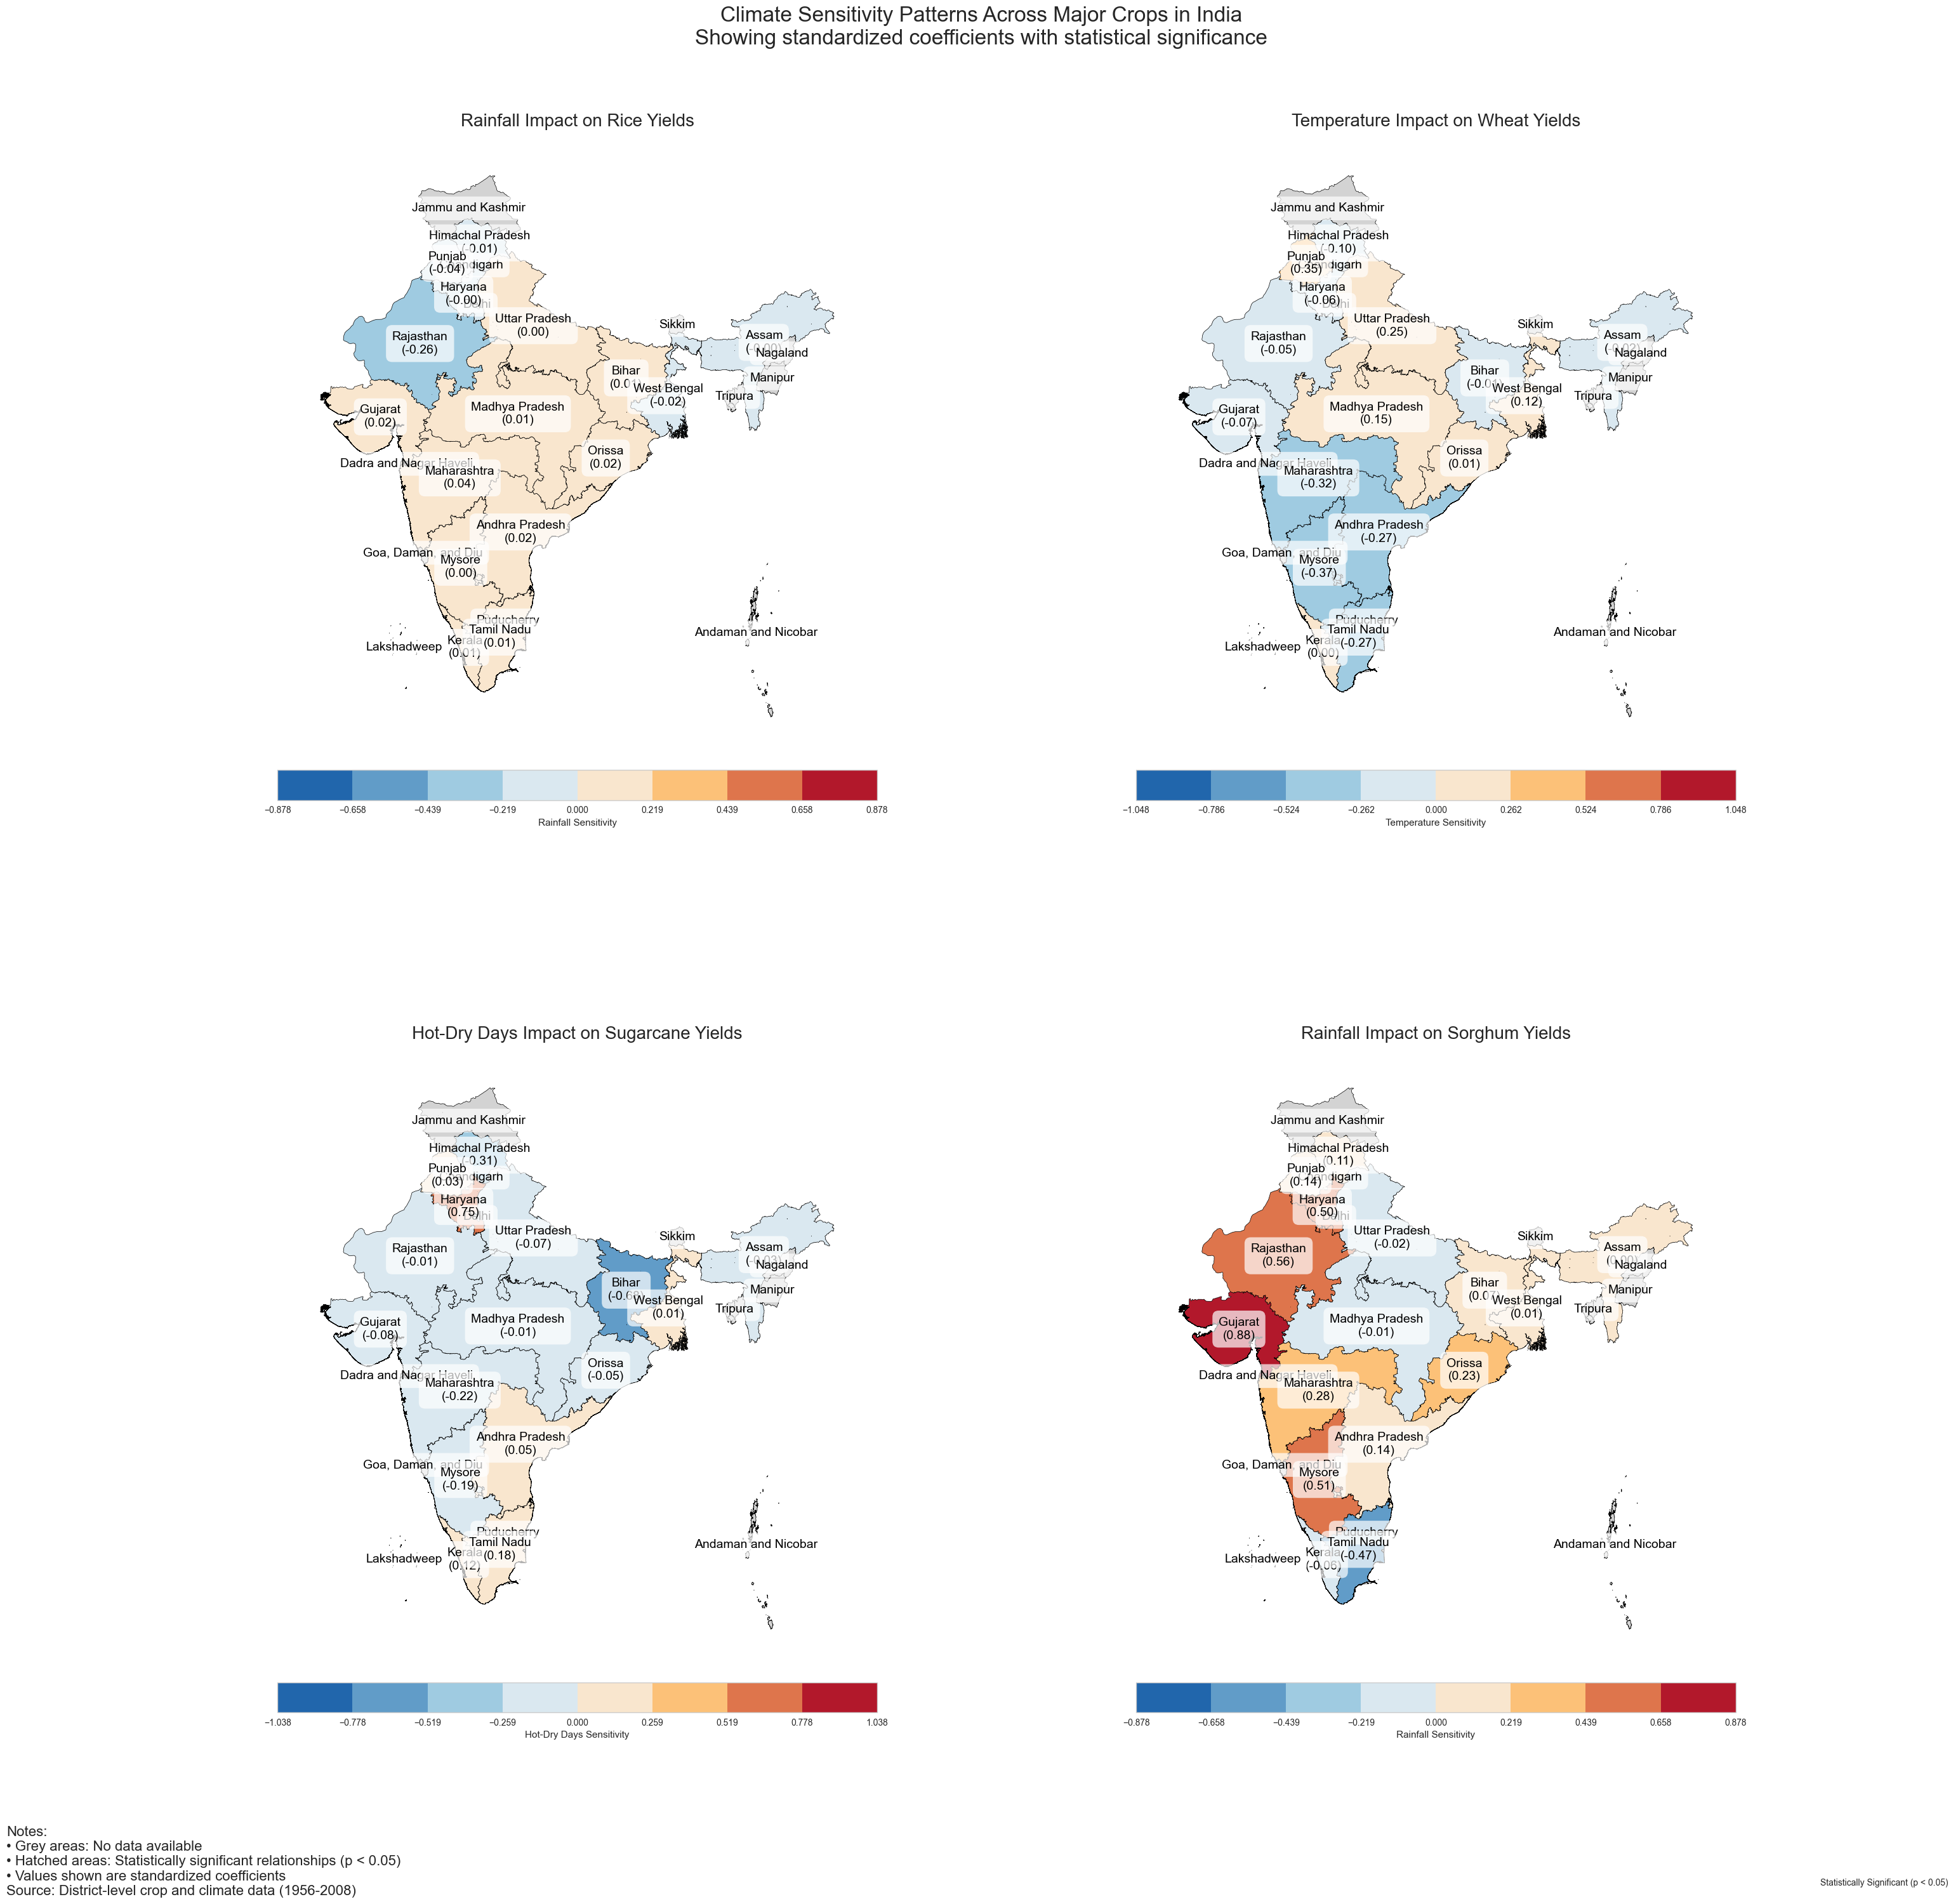

In [142]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Patch

def plot_multi_crop_sensitivity(state_summary, data_collection):
    """
    Creates a 2x2 grid of maps showing different climate sensitivity metrics
    with uncertainty visualization and consistent color schemes.
    """
    required_vars = {
        'precipitation_std_slope',
        'extreme_temp_days_std_slope',
        'hot_dry_days_std_slope'
    }
    missing_vars = required_vars - set(state_summary.columns)
    if missing_vars:
        raise ValueError(f"Missing required columns: {missing_vars}")

    # Setup the figure
    fig = plt.figure(figsize=(32, 32))  # Increased figure size
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.2)
    axes = gs.subplots()

    # Create consistent colormap for all sensitivity metrics
    # Using a diverging colormap that's colorblind-friendly
    colors = ['#2166ac', '#92c5de', '#f7f7f7', '#fdb863', '#b2182b']
    sensitivity_cmap = LinearSegmentedColormap.from_list('custom_div', colors, N=256)

    # Define crop-specific configurations
    crop_configs = {
        'Rice': {
            'var': 'precipitation_std_slope',
            'title': 'Rainfall Impact on Rice Yields',
            'var_label': 'Rainfall Sensitivity'
        },
        'Wheat': {
            'var': 'extreme_temp_days_std_slope',
            'title': 'Temperature Impact on Wheat Yields',
            'var_label': 'Temperature Sensitivity'
        },
        'Sugarcane': {
            'var': 'hot_dry_days_std_slope',
            'title': 'Hot-Dry Days Impact on Sugarcane Yields',
            'var_label': 'Hot-Dry Days Sensitivity'
        },
        'Sorghum': {
            'var': 'precipitation_std_slope',
            'title': 'Rainfall Impact on Sorghum Yields',
            'var_label': 'Rainfall Sensitivity'
        }
    }

    # Process spatial data
    try:
        gdf_districts = data_collection['data']['spatial'].copy()
        if 'state' in state_summary.columns:
            state_summary = state_summary.rename(columns={'state': 'ST_1971'})
        gdf_states = gdf_districts.dissolve(by='ST_1971').reset_index()
        gdf_states['centroid'] = gdf_states.geometry.centroid
    except KeyError as e:
        raise KeyError(f"Error accessing spatial data: {e}")

    # Calculate global min/max for consistent scaling
    metric_ranges = {}
    for metric in set(config['var'] for config in crop_configs.values()):
        values = state_summary[state_summary[metric].notna()][metric]
        max_abs = max(abs(values.min()), abs(values.max()))
        metric_ranges[metric] = (-max_abs, max_abs)

    # Create maps for each crop
    for idx, (crop, ax) in enumerate(zip(crop_configs.keys(), axes.flat)):
        config = crop_configs[crop]
        
        # Prepare data
        subset_df = state_summary[state_summary['crop'] == crop].copy()
        merged_gdf = gdf_states.merge(subset_df, on='ST_1971', how='left')
        
        vmin, vmax = metric_ranges[config['var']]
        
        # Create discrete color bins for better interpretation
        bounds = np.linspace(vmin, vmax, 9)
        norm = BoundaryNorm(bounds, sensitivity_cmap.N)

        # Plot choropleth
        im = merged_gdf.plot(
            column=config['var'],
            cmap=sensitivity_cmap,
            norm=norm,
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            ax=ax,
            missing_kwds={'color': 'lightgrey'},
            legend_kwds={
                'label': config['var_label'],
                'orientation': 'horizontal',
                'fraction': 0.046,
                'pad': 0.04
            }
        )

        # Add statistical significance hatching
        if 'p_value' in merged_gdf.columns:
            significant = merged_gdf[merged_gdf['p_value'] < 0.05].geometry
            ax.fill(significant, hatch='///', alpha=0, color='none')

        # Add state labels with centering
        for _, row in merged_gdf.iterrows():
            try:
                x, y = row.centroid.x, row.centroid.y
                label_text = row['ST_1971']
                
                # Add coefficient value if available
                if not pd.isna(row[config['var']]):
                    label_text += f"\n({row[config['var']]:.2f})"
                
                ax.annotate(
                    label_text,
                    xy=(x, y),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center',
                    va='center',
                    fontsize=14,  # Increased label size
                    color='black',
                    bbox=dict(
                        boxstyle='round,pad=0.5',
                        fc='white',
                        ec='none',
                        alpha=0.7
                    )
                )
            except Exception as e:
                print(f"Error adding label for {row['ST_1971']}: {e}")

        # Add title with variable description
        ax.set_title(config['title'], fontsize=20, pad=25)  # Increased title size
        ax.axis('off')

    # Add legend for significance
    legend_elements = [
        Patch(facecolor='none', hatch='///', label='Statistically Significant (p < 0.05)')
    ]
    fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.98, 0.02))

    # Add common title
    fig.suptitle(
        'Climate Sensitivity Patterns Across Major Crops in India\n' +
        'Showing standardized coefficients with statistical significance',
        fontsize=24, y=0.95  # Increased suptitle size
    )

    # Add detailed notes
    plt.figtext(
        0.02, 0.02,
        'Notes:\n' +
        '• Grey areas: No data available\n' +
        '• Hatched areas: Statistically significant relationships (p < 0.05)\n' +
        '• Values shown are standardized coefficients\n' +
        'Source: District-level crop and climate data (1956-2008)',
        fontsize=16, ha='left'  # Increased notes size
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

# Example usage:
fig, axes = plot_multi_crop_sensitivity(
    state_summary=regional_summary,
    data_collection=data_collection
)
plt.show()

**Interpretation**

- **Rice (Top-Left)**:  
  Warmer (orange–red) areas respond positively to **increased rainfall**; cooler (blue) areas show negative or neutral rainfall effects.  
- **Wheat (Top-Right)**:  
  **Blue** indicates **negative** yield effects from **temperature extremes**; orange areas are less harmed or slightly benefit.  
- **Sugarcane (Bottom-Left)**:  
  Deep **blue** signifies yield losses under **hot-dry days**; warmer tones suggest resilience or minor benefits.  
- **Sorghum (Bottom-Right)**:  
  **Blue** highlights rainfall’s **negative** impact in western zones; **orange–red** indicates positive rainfall responses elsewhere.

Overall, these maps reveal **spatially diverse** crop sensitivities, emphasizing the need for **region-specific** climate-adaptation strategies.

## 5.2 Time-Series of Yield Anomalies by Crop

Tracking **long-term yield trends** across different crops can reveal how agricultural systems evolve alongside climate variability. In this visualization, we plot **time-series of yield anomalies** (standardized yields) from 1970 to 2008 for each major crop. By plotting them on the same axis, we can quickly compare **when** yield fluctuations occur and whether certain crops exhibit more pronounced volatility.

**Plotting Steps**:
1. **Group** the data by `(year, crop)` and compute the **mean** and **standard deviation** of `yield_std`.
2. **Plot** each crop’s time-series on the same figure, with:
   - A **line** indicating the mean yield anomaly.
   - A **shaded** confidence region around the mean (using a fraction of the standard deviation as a proxy).
3. **Reference Line at Zero**: A dashed horizontal line indicates the baseline (zero anomaly), making it easy to see whether each crop is generally **above** or **below** its long-term mean yield.



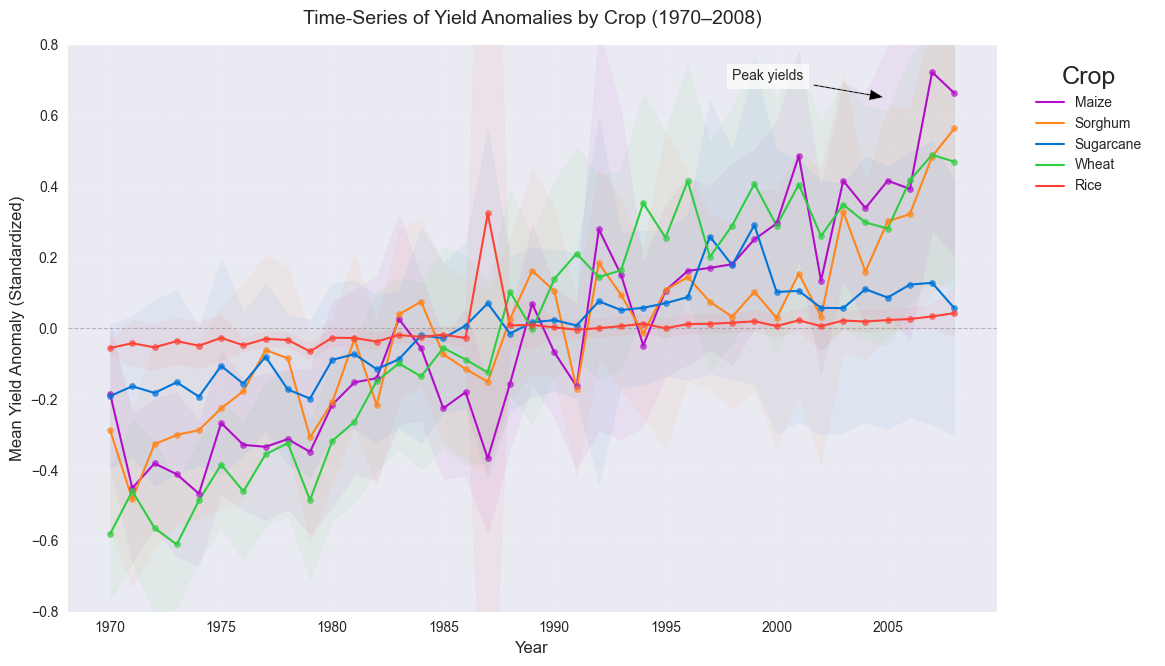

In [143]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Patch

def plot_multi_crop_sensitivity(state_summary, data_collection):
    """
    Creates a 2x2 grid of maps showing different climate sensitivity metrics
    with uncertainty visualization and consistent color schemes.
    """
    required_vars = {
        'precipitation_std_slope',
        'extreme_temp_days_std_slope',
        'hot_dry_days_std_slope'
    }
    missing_vars = required_vars - set(state_summary.columns)
    if missing_vars:
        raise ValueError(f"Missing required columns: {missing_vars}")

    # Setup the figure
    fig = plt.figure(figsize=(32, 32))  # Increased figure size
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.2)
    axes = gs.subplots()

    # Create consistent colormap for all sensitivity metrics
    # Using a diverging colormap that's colorblind-friendly
    colors = ['#2166ac', '#92c5de', '#f7f7f7', '#fdb863', '#b2182b']
    sensitivity_cmap = LinearSegmentedColormap.from_list('custom_div', colors, N=256)

    # Define crop-specific configurations
    crop_configs = {
        'Rice': {
            'var': 'precipitation_std_slope',
            'title': 'Rainfall Impact on Rice Yields',
            'var_label': 'Rainfall Sensitivity'
        },
        'Wheat': {
            'var': 'extreme_temp_days_std_slope',
            'title': 'Temperature Impact on Wheat Yields',
            'var_label': 'Temperature Sensitivity'
        },
        'Sugarcane': {
            'var': 'hot_dry_days_std_slope',
            'title': 'Hot-Dry Days Impact on Sugarcane Yields',
            'var_label': 'Hot-Dry Days Sensitivity'
        },
        'Sorghum': {
            'var': 'precipitation_std_slope',
            'title': 'Rainfall Impact on Sorghum Yields',
            'var_label': 'Rainfall Sensitivity'
        }
    }

    # Process spatial data
    try:
        gdf_districts = data_collection['data']['spatial'].copy()
        if 'state' in state_summary.columns:
            state_summary = state_summary.rename(columns={'state': 'ST_1971'})
        gdf_states = gdf_districts.dissolve(by='ST_1971').reset_index()
        gdf_states['centroid'] = gdf_states.geometry.centroid
    except KeyError as e:
        raise KeyError(f"Error accessing spatial data: {e}")

    # Calculate global min/max for consistent scaling
    metric_ranges = {}
    for metric in set(config['var'] for config in crop_configs.values()):
        values = state_summary[state_summary[metric].notna()][metric]
        max_abs = max(abs(values.min()), abs(values.max()))
        metric_ranges[metric] = (-max_abs, max_abs)

    # Create maps for each crop
    for idx, (crop, ax) in enumerate(zip(crop_configs.keys(), axes.flat)):
        config = crop_configs[crop]
        
        # Prepare data
        subset_df = state_summary[state_summary['crop'] == crop].copy()
        merged_gdf = gdf_states.merge(subset_df, on='ST_1971', how='left')
        
        vmin, vmax = metric_ranges[config['var']]
        
        # Create discrete color bins for better interpretation
        bounds = np.linspace(vmin, vmax, 9)
        norm = BoundaryNorm(bounds, sensitivity_cmap.N)

        # Plot choropleth
        im = merged_gdf.plot(
            column=config['var'],
            cmap=sensitivity_cmap,
            norm=norm,
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            ax=ax,
            missing_kwds={'color': 'lightgrey'},
            legend_kwds={
                'label': config['var_label'],
                'orientation': 'horizontal',
                'fraction': 0.046,
                'pad': 0.04
            }
        )

        # Add statistical significance hatching
        if 'p_value' in merged_gdf.columns:
            significant = merged_gdf[merged_gdf['p_value'] < 0.05].geometry
            ax.fill(significant, hatch='///', alpha=0, color='none')

        # Add state labels with centering
        for _, row in merged_gdf.iterrows():
            try:
                x, y = row.centroid.x, row.centroid.y
                label_text = row['ST_1971']
                
                # Add coefficient value if available
                if not pd.isna(row[config['var']]):
                    label_text += f"\n({row[config['var']]:.2f})"
                
                ax.annotate(
                    label_text,
                    xy=(x, y),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center',
                    va='center',
                    fontsize=14,  # Increased label size
                    color='black',
                    bbox=dict(
                        boxstyle='round,pad=0.5',
                        fc='white',
                        ec='none',
                        alpha=0.7
                    )
                )
            except Exception as e:
                print(f"Error adding label for {row['ST_1971']}: {e}")

        # Add title with variable description
        ax.set_title(config['title'], fontsize=20, pad=25)  # Increased title size
        ax.axis('off')

    # Add legend for significance
    legend_elements = [
        Patch(facecolor='none', hatch='///', label='Statistically Significant (p < 0.05)')
    ]
    fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.98, 0.02))

    # Add common title
    fig.suptitle(
        'Climate Sensitivity Patterns Across Major Crops in India\n' +
        'Showing standardized coefficients with statistical significance',
        fontsize=24, y=0.95  # Increased suptitle size
    )

    # Add detailed notes
    plt.figtext(
        0.02, 0.02,
        'Notes:\n' +
        '• Grey areas: No data available\n' +
        '• Hatched areas: Statistically significant relationships (p < 0.05)\n' +
        '• Values shown are standardized coefficients\n' +
        'Source: District-level crop and climate data (1956-2008)',
        fontsize=16, ha='left'  # Increased notes size
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

# Example usage:
major_crops_list = ['Rice', 'Wheat', 'Sugarcane', 'Sorghum', 'Maize']
fig, ax = plot_yield_anomalies_by_crop(analysis_data, major_crops=major_crops_list)
plt.show()


### Interpretation:

From this time-series, we see **most crops** (e.g., Wheat, Maize, Sorghum) transitioning from **negative** to **positive** yield anomalies (basically the difference between an observed yield and what's "normal" or expected for that crop) over the studied period, suggesting a general **upward trend** in standardized yields. Meanwhile, **Rice** remains closer to zero, reflecting more stable yields across time, and **Sugarcane** displays moderate fluctuations in the mid-1980s and early 2000s. The **shaded regions** represent variability around these mean anomalies, indicating that crops with broader confidence bands (e.g., Wheat in the 1970s and Maize around 2005) experienced more **yield volatility**. Marked “peak yields” highlight a noticeable **jump** for certain crops post-2000, underscoring how changes in climate, policy, or management may have contributed to **recent productivity gains**.


## 5.3 Compound Event Impact Chart

While single-variable extremes can significantly affect yields, **compound events** (e.g., hot-dry conditions **plus** extremely low precipitation) often pose **even greater risks** to agricultural systems. This bar chart visualization compares **single-variable** vs. **compound** event yield impacts for each key state-crop combination identified as significant in Section 4.3.3.

**Plotting Steps**:
1. **Combine** the single-variable extremes (`extreme_df`) and compound extremes (`compound_df`) into one dataset, labeling each record as “Single” or “Compound.”  
2. **Group** bars by `(state, crop)`, with the bar height representing **mean yield impact** (from standardized yields).  
3. **Color/Hue** differentiates between “Single” and “Compound” events, clarifying the relative severity of each scenario.  
4. **Optional Annotations** can highlight the **frequency** of these events (e.g., at the top of each bar).

By showcasing the **relative** yield losses (or gains) under multi-hazard stress vs. single hazards, this chart quickly conveys **where** and **how** compound events amplify climate impacts on agriculture.


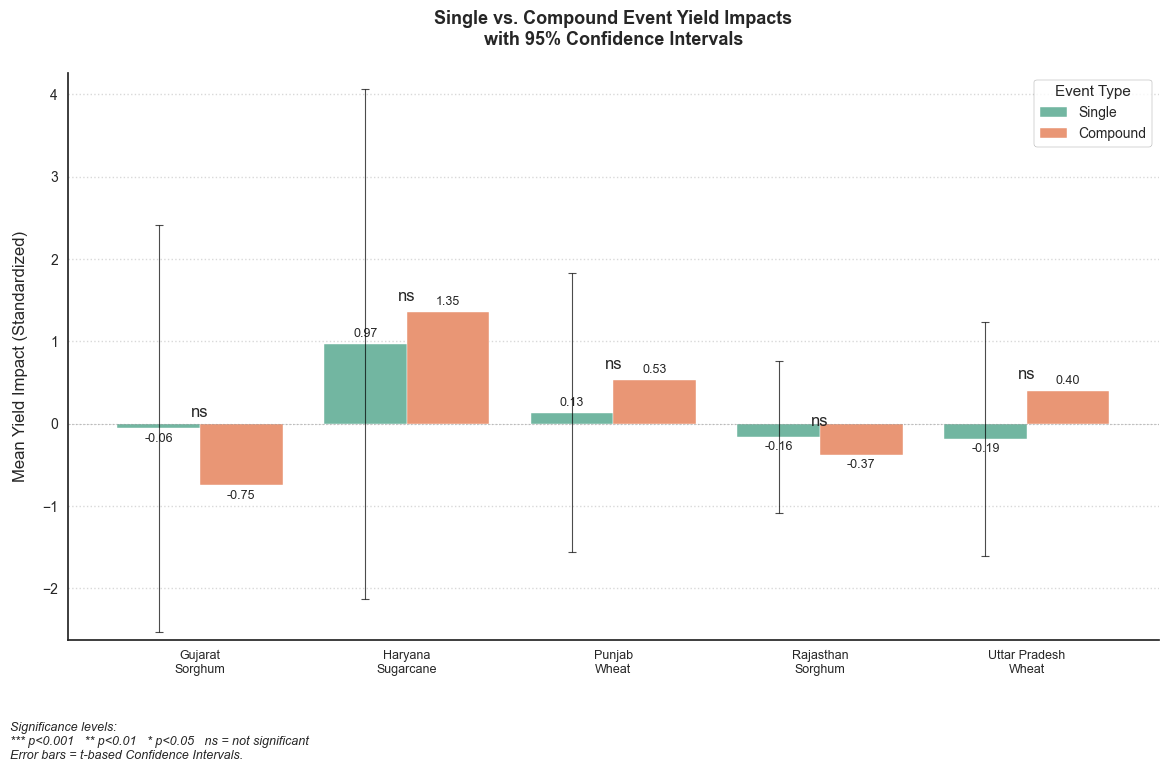

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def plot_compound_event_impact(extreme_df, compound_df, confidence_level=0.95):
    def prepare_data(df, label):
        result = df.groupby(['state', 'crop']).agg({
            'yield_impact': ['mean', 'std', 'count']
        }).reset_index()
        result.columns = ['state', 'crop', 'mean', 'std', 'n']
        
        alpha = 1 - confidence_level
        result['ci'] = result.apply(
            lambda row: stats.t.ppf(1 - alpha/2, row['n'] - 1) * row['std'] / np.sqrt(row['n'])
            if row['n'] > 1 else np.nan, 
            axis=1
        )
        result['event_label'] = label
        return result

    single_data = prepare_data(extreme_df, 'Single')
    compound_data = prepare_data(compound_df, 'Compound')
    
    def calculate_significance(sg, cg):
        t_stat, p_val = stats.ttest_ind_from_stats(
            mean1=sg['mean'], std1=sg['std'], nobs1=sg['n'],
            mean2=cg['mean'], std2=cg['std'], nobs2=cg['n']
        )
        return p_val

    combined = pd.concat([single_data, compound_data], ignore_index=True)
    combined['state_crop'] = combined['state'] + " - " + combined['crop']

    significance_dict = {}
    for sc in combined['state_crop'].unique():
        sg = single_data[(single_data['state'] + " - " + single_data['crop']) == sc]
        cg = compound_data[(compound_data['state'] + " - " + compound_data['crop']) == sc]
        if not (sg.empty or cg.empty):
            significance_dict[sc] = calculate_significance(sg.iloc[0], cg.iloc[0])

    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.barplot(
        data=combined,
        x='state_crop',
        y='mean',
        hue='event_label',
        palette=['#66c2a5', '#fc8d62'],
        ax=ax,
        width=0.8,
        ci=None
    )

    unique_state_crops = combined['state_crop'].unique()
    for i, container in enumerate(ax.containers):
        if not hasattr(container, 'patches'):
            continue
        event_type = 'Single' if i == 0 else 'Compound'
        for j, bar in enumerate(container.patches):
            sc_label = unique_state_crops[j]
            row = combined[
                (combined['event_label'] == event_type) &
                (combined['state_crop'] == sc_label)
            ].iloc[0]
            bar_x = bar.get_x() + bar.get_width()/2
            bar_y = row['mean']
            bar_ci = row['ci']
            ax.errorbar(
                bar_x,
                bar_y,
                yerr=bar_ci,
                color='black',
                elinewidth=0.8,
                capsize=3,
                capthick=0.8,
                alpha=0.7,
                zorder=10
            )

    for i, sc_label in enumerate(unique_state_crops):
        if sc_label in significance_dict:
            p_val = significance_dict[sc_label]
            y_max = combined[combined['state_crop'] == sc_label]['mean'].max()
            y_star = y_max + 0.1
            if p_val < 0.001:
                marker = '***'
            elif p_val < 0.01:
                marker = '**'
            elif p_val < 0.05:
                marker = '*'
            else:
                marker = 'ns'
            ax.text(i, y_star, marker, ha='center', va='bottom', fontsize=12)

    # Tighter y-limits based on data + confidence interval
    lower_bound = (combined['mean'] - combined['ci']).min()
    upper_bound = (combined['mean'] + combined['ci']).max()
    y_min = lower_bound - 0.1
    y_max = upper_bound + 0.2
    ax.set_ylim(y_min, y_max)

    x_labels = [lbl.get_text().replace(" - ", "\n") for lbl in ax.get_xticklabels()]
    ax.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=9)

    for container in ax.containers:
        if not hasattr(container, 'patches'):
            continue
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle=':', alpha=0.3, color='gray')
    ax.set_axisbelow(True)

    ax.set_title(
        "Single vs. Compound Event Yield Impacts\n"
        f"with {int(confidence_level*100)}% Confidence Intervals",
        pad=20,
        fontsize=13,
        fontweight='bold'
    )
    ax.set_xlabel("")
    ax.set_ylabel("Mean Yield Impact (Standardized)", fontsize=12, labelpad=10)

    ax.legend(
        title="Event Type",
        title_fontsize=11,
        fontsize=10,
        loc='upper right',
        frameon=True,
        edgecolor='gray'
    )

    # Make more room at the bottom so text doesn't collide with axes
    plt.tight_layout(rect=[0, 0.10, 1, 1])  # extra 10% margin at bottom

    # Move the text slightly up (y=0.03) so it's easier to read
    plt.figtext(
        0.02, 0.03,
        "Significance levels:\n"
        "*** p<0.001   ** p<0.01   * p<0.05   ns = not significant\n"
        "Error bars = t-based Confidence Intervals.",
        ha='left',
        fontsize=9,
        style='italic'
    )

    return fig, ax



fig, ax = plot_compound_event_impact(extreme_df, compound_df, confidence_level=0.95)
plt.show()


## Interpretation


These results illustrate how **compound events** (orange bars) can amplify (or offset) the yield impacts observed under **single-variable** extremes (green bars). For example, **Gujarat–Sorghum** shows a **−0.06** impact for single-variable events vs. **−0.75** for compound extremes, indicating a much sharper yield drop when hot-dry conditions coincide with low rainfall. By contrast, **Haryana–Sugarcane** experiences **positive** yield anomalies under both single and compound events, suggesting that local adaptation or resilience mechanisms may be mitigating multi-stressor impacts there. The frequent “ns” labels reveal that, for many state-crop pairs, the difference may be subtle or uncertain at the current sample size and confidence level. Overall, these side-by-side comparisons confirm that **multi-hazard scenarios** often lead to **larger** yield shifts, whether beneficial or harmful—than single hazards alone. 

## 5.4 Crop-Specific Climate Sensitivity Bar Chart

To succinctly compare **regression coefficients** across multiple crops for key climate variables, we can use a **bar chart**. Each group of bars represents a different climate variable (e.g., precipitation, extreme temperatures), and each bar within a group shows how strongly that variable affects a given crop (i.e., the **regression coefficient** from Section 4.3.1).

**Plotting Steps**:
1. **Extract** regression coefficients (and possibly confidence intervals) for each crop-climate variable pair.  
2. **Melt** or reshape the data so each row corresponds to a (crop, climate_variable, coefficient) tuple.  
3. **Group** bars by climate variable on the x-axis, with **color/hue** for each crop.  
4. **Add Error Bars** (optional) for confidence intervals if desired, offering a sense of uncertainty in the coefficients.

This view enables a **quick side-by-side** comparison of how different crops respond to each climate indicator, highlighting which variables are most impactful—and potentially **policy-relevant**—for each crop.

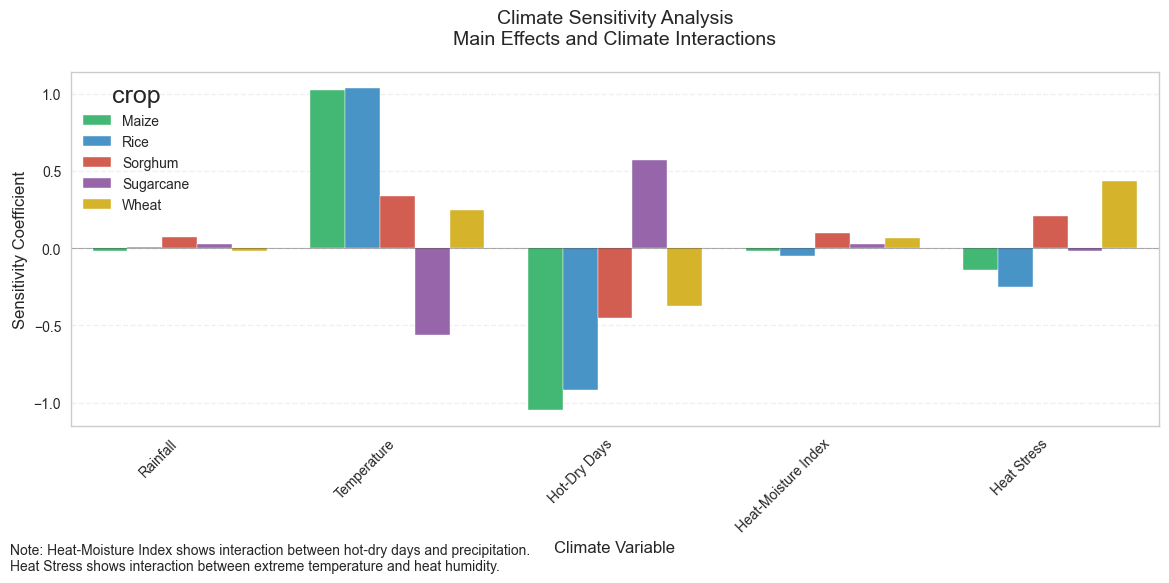

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_crop_sensitivity_barchart(sensitivity_metrics, climate_vars=None):
    """
    Creates a bar chart of crop-specific climate sensitivities including interactions.
    """
    # Define variable labels
    var_labels = {
        'precipitation_std': 'Rainfall',
        'extreme_temp_days_std': 'Temperature',
        'hot_dry_days_std': 'Hot-Dry Days',
        'heat_moisture': 'Heat-Moisture Index',
        'heat_stress': 'Heat Stress'
    }
    
    # Define colors for each crop
    colors = {
        'Maize': '#2ecc71',
        'Rice': '#3498db',
        'Sorghum': '#e74c3c',
        'Sugarcane': '#9b59b6',
        'Wheat': '#f1c40f'
    }

    # Prepare data
    rows = []
    for crop, metrics in sensitivity_metrics.items():
        coeff_dict = metrics.get('coefficients', {})
        
        # Add all variables including interactions
        for var in climate_vars:
            coef_value = coeff_dict.get(var, float('nan'))
            var_type = 'Interaction' if var in ['heat_moisture', 'heat_stress'] else 'Main Effect'
            rows.append({
                'crop': crop,
                'variable': var_labels[var],
                'coefficient': coef_value,
                'type': var_type
            })
    
    df_coefs = pd.DataFrame(rows)
    
    # Create figure
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create the plot
    sns.barplot(
        data=df_coefs,
        x='variable',
        y='coefficient',
        hue='crop',
        palette=colors,
        ax=ax
    )
    
    # Customize the plot
    ax.axhline(0, color='black', linewidth=0.8, alpha=0.3)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Labels and title
    ax.set_xlabel('Climate Variable', fontsize=12)
    ax.set_ylabel('Sensitivity Coefficient', fontsize=12)
    ax.set_title('Climate Sensitivity Analysis\nMain Effects and Climate Interactions', 
                fontsize=14, pad=20)
    
    # Rotate x-labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add note about interactions
    plt.figtext(0.02, 0.02,
                'Note: Heat-Moisture Index shows interaction between hot-dry days and precipitation.\n' +
                'Heat Stress shows interaction between extreme temperature and heat humidity.',
                fontsize=10, ha='left')
    
    plt.tight_layout()
    return fig, ax

# Example usage:
climate_vars = [
    'precipitation_std', 
    'extreme_temp_days_std', 
    'hot_dry_days_std',
    'heat_moisture',
    'heat_stress'
]
fig, ax = plot_crop_sensitivity_barchart(sensitivity_metrics, climate_vars=climate_vars)
plt.show()



## Interpretation


These bar heights show how climate variables affect yields for each crop (by color). A **positive** coefficient indicates that higher values of that variable **boost** yields, while negative values show **harmful** effects. Main effects reveal that Rice and Maize respond positively to temperature but negatively to hot-dry days, while Wheat shows the opposite pattern. The interaction terms show additional insights: Heat-Moisture Index (hot-dry days × precipitation) has minimal impact across crops, while Heat Stress (temperature × humidity) substantially benefits Wheat yields but slightly reduces Rice and Maize productivity. These varying responses highlight that each crop has a **unique climate sensitivity profile**, emphasizing the need for crop-specific adaptation strategies.


## 5.5 Distribution of Yield Anomalies Over Time (Box Plots)

As a **final visualization**, we showcase how yield anomalies have evolved across **decades** for each crop. Box plots are a straightforward way to illustrate **median**, **quartiles**, and potential **outliers** in the standardized yield distribution, providing an at-a-glance comparison of **inter-annual variability** and **long-term changes**.

**Plotting Steps**:
1. **Assign Each Year to a Decade** (e.g., 1970–1979 = “1970s”), enabling grouped box plots that span the study period.  
2. **Group** data by `(decade, crop)` and plot yield anomalies on the y-axis.  
3. **Color/Hue** each crop differently to see how yield variance shifts among crops within each decade.  
4. **Highlight Outliers** (points beyond 1.5×IQR) to see where yields significantly deviated from typical ranges.

These box plots help identify **increasing or decreasing** variability over time and pinpoint decades with **extreme outliers**, guiding further investigation into the drivers (e.g., **climate extremes** or **policy changes**).

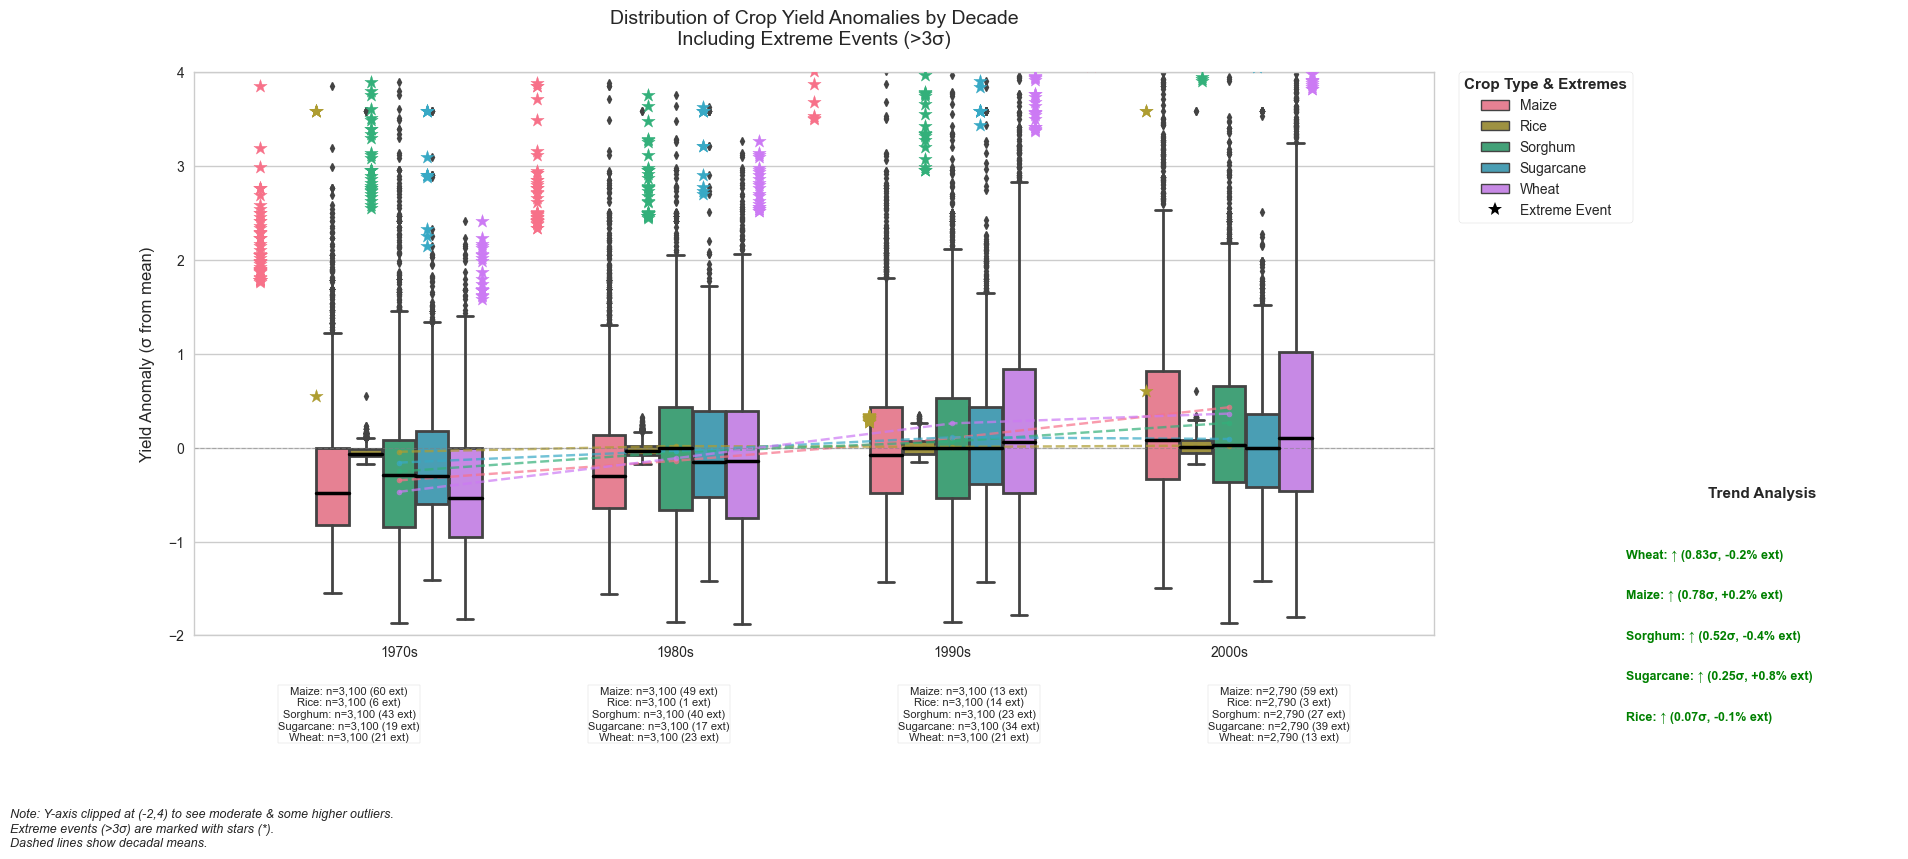

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_enhanced_yield_boxplots(analysis_df, major_crops=None):
    """
    Creates a box plot of yield anomalies by decade and crop, with thicker boxes
    and a y-axis clipped from -2 to 4 for better visibility of moderate/extreme outliers.
    """
    # 1. Data Preparation
    if major_crops is None:
        major_crops = analysis_df['crop'].unique()
    df = analysis_df[analysis_df['crop'].isin(major_crops)].copy()
    
    df['decade'] = (df['year'] // 10) * 10
    df['decade'] = df['decade'].astype(str) + 's'
    all_decades = sorted(df['decade'].unique())
    
    # Mark extremes (>3σ)
    df['zscore'] = df.groupby(['crop', 'decade'])['yield_std'].transform(
        lambda x: np.abs(stats.zscore(x, nan_policy='omit'))
    )
    df['is_extreme'] = df['zscore'] > 3

    # 2. Figure Setup
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(16, 9))
    
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 0.2], hspace=0.05)
    ax = fig.add_subplot(gs[0])
    annot_ax = fig.add_subplot(gs[1])
    annot_ax.axis('off')
    
    unique_crops = list(major_crops)
    palette = sns.color_palette("husl", len(unique_crops))
    crop_colors = dict(zip(unique_crops, palette))

    # 3. Main Boxplot (Thicker lines, slightly wider boxes)
    sns.boxplot(
        data=df,
        x='decade',
        y='yield_std',
        hue='crop',
        palette=crop_colors,
        showfliers=True,
        fliersize=4,
        linewidth=2,
        medianprops={'linewidth': 2.5, 'color': 'black'},
        width=0.6,
        ax=ax
    )
    
    # 4. Plot Extreme Events
    for crop in unique_crops:
        crop_data = df[(df['crop'] == crop) & (df['is_extreme'])]
        if len(crop_data) > 0:
            x_offsets = (unique_crops.index(crop) - len(unique_crops)/2) * 0.2
            x_positions = crop_data['decade'].apply(lambda d: all_decades.index(d) + x_offsets)
            ax.scatter(
                x_positions,
                crop_data['yield_std'],
                color=crop_colors[crop],
                marker='*',
                s=100,
                zorder=5,
            )

    # 5. Dashed Decadal Means
    for crop in unique_crops:
        crop_data = df[df['crop'] == crop]
        means = crop_data.groupby('decade')['yield_std'].mean().reset_index()
        x_positions = [all_decades.index(dec) for dec in means['decade']]
        ax.plot(
            x_positions,
            means['yield_std'].values,
            linestyle='--',
            marker='o',
            markersize=4,
            alpha=0.7,
            color=crop_colors[crop],
            label=None
        )

    # 6. Annotate Sample Sizes in the Lower Subplot
    for decade_idx, decade in enumerate(all_decades):
        annotation_text = []
        for crop in unique_crops:
            subset = df[(df['decade'] == decade) & (df['crop'] == crop)]
            if len(subset) > 0:
                n_total = len(subset)
                n_extreme = subset['is_extreme'].sum()
                crop_text = f"{crop}: n={n_total:,}"
                if n_extreme > 0:
                    crop_text += f" ({n_extreme} ext)"
                annotation_text.append(crop_text)
        
        combined_text = "\n".join(annotation_text)
        annot_ax.text(
            decade_idx / len(all_decades) + 1/(2*len(all_decades)),
            0.7,
            combined_text,
            ha='center',
            va='top',
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.9, pad=0.5)
        )

    # 7. Y-axis Range: from -2 to 4
    ax.set_ylim(-2, 4)

    # 8. Labels, Title, and Grid
    ax.set_title(
        "Distribution of Crop Yield Anomalies by Decade\nIncluding Extreme Events (>3σ)",
        fontsize=14,
        pad=20
    )
    ax.set_xlabel('')
    ax.set_ylabel('Yield Anomaly (σ from mean)', fontsize=12, labelpad=10)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_axisbelow(True)

    # 9. Legend (Unify star handle)
    handles, labels = ax.get_legend_handles_labels()
    star_handle = plt.Line2D([], [], color='black', marker='*', linestyle='None',
                             markersize=10, label='Extreme Event')
    final_handles, final_labels = [], []
    seen = set()
    for h, l in zip(handles, labels):
        if l not in seen:
            final_handles.append(h)
            final_labels.append(l)
            seen.add(l)
    final_handles.append(star_handle)
    final_labels.append('Extreme Event')
    
    leg = ax.legend(
        final_handles,
        final_labels,
        title='Crop Type & Extremes',
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0,
        frameon=True,
        fontsize=10
    )
    leg.get_title().set_fontsize(11)
    leg.get_title().set_fontweight('bold')

    # 10. Trend Analysis
    trend_ax = fig.add_axes([1.02, 0.1, 0.17, 0.3])
    trend_ax.axis('off')
    trend_ax.set_title("Trend Analysis", fontsize=11, fontweight='bold', pad=5)

    trend_info = []
    first_decade, last_decade = all_decades[0], all_decades[-1]
    for crop in unique_crops:
        crop_data = df[df['crop'] == crop]
        first_stats = crop_data[crop_data['decade'] == first_decade]
        last_stats = crop_data[crop_data['decade'] == last_decade]
        if len(first_stats) == 0 or len(last_stats) == 0:
            continue
            
        change = last_stats['yield_std'].mean() - first_stats['yield_std'].mean()
        first_ext_pct = (first_stats['is_extreme'].sum() / len(first_stats)) * 100
        last_ext_pct = (last_stats['is_extreme'].sum() / len(last_stats)) * 100
        extreme_change = last_ext_pct - first_ext_pct

        if change > 0:
            arrow = "↑"
            clr = 'green'
        elif change < 0:
            arrow = "↓"
            clr = 'red'
        else:
            arrow = "→"
            clr = 'gray'
        
        trend_info.append({
            'crop': crop,
            'change': change,
            'extreme_change': extreme_change,
            'arrow': arrow,
            'color': clr
        })

    trend_info.sort(key=lambda x: abs(x['change']), reverse=True)
    y_pos = 0.8
    for item in trend_info:
        txt = f"{item['crop']}: {item['arrow']} ({item['change']:.2f}σ, {item['extreme_change']:+.1f}% ext)"
        trend_ax.text(
            0.0, y_pos,
            txt,
            fontsize=9,
            fontweight='bold',
            color=item['color']
        )
        y_pos -= 0.15

    # Footnote
    plt.figtext(
        0.01, 0.02,
        ("Note: Y-axis clipped at (-2,4) to see moderate & some higher outliers.\n"
         "Extreme events (>3σ) are marked with stars (*).\n"
         "Dashed lines show decadal means."),
        ha='left',
        fontsize=9,
        style='italic'
    )

    plt.tight_layout()
    return fig, ax



# Example usage:
major_crops_list = ['Maize', 'Rice', 'Sorghum', 'Sugarcane', 'Wheat']
fig, ax = plot_enhanced_yield_boxplots(analysis_data, major_crops=major_crops_list)
plt.show()





## Interpretation 

These box plots show how **yield anomalies** (relative to the overall mean) have evolved across **decades** for each crop, with **decadal mean lines** (dashed) indicating general trends. Higher box positions reflect better-than-average yields, while lower (or negative) positions denote below-average performance. The **“n=xxx”** labels note how many district-year observations contributed to each box, ensuring transparent sample sizes. According to the **Trend Analysis** at right, **all five crops** experience net yield increases from the 1970s to 2000s, with Sorghum showing the largest relative gain. Importantly, these anomalies factor in **climate hazard indicators** (e.g., precipitation, hot-dry days, extreme temperature), helping illustrate how changing climate conditions—and adaptive management—have influenced long-term productivity.

## 5.6 Summary of Visualizations and Key Insights

In this final subsection, we recap the **five** visualizations we created to illustrate the intricate links between **climate variability** and crop yields:

1. **Climate Sensitivity Map of India** (Section 5.1)  
   - **Spatially** highlights which states are most responsive (positive or negative) to key climate indicators (e.g., rainfall, hot-dry days) based on state-level regressions.  
   - Reveals “hotspots” of vulnerability where targeted adaptation and resource allocation could be most beneficial.

2. **Time-Series of Yield Anomalies** (Section 5.2)  
   - Plots **multi-crop** yield trends (1970–2008), allowing us to see **when** major fluctuations occur and which crops show the most volatility or resilience over time.

3. **Compound Event Impact Chart** (Section 5.3)  
   - Compares **single-variable** extremes (e.g., very high precipitation or extreme temperatures) with **compound** events (hot-dry + low precipitation) across specific state-crop pairs.  
   - Demonstrates how overlapping climate stressors can magnify or alter yield responses beyond what single-variable analyses suggest.

4. **Crop-Specific Climate Sensitivity Bar Chart** (Section 5.4)  
   - Stacks regression coefficients for each **climate variable** side by side, clearly showing how strongly each crop is affected and in which direction (positive or negative yield impacts).

5. **Distribution of Yield Anomalies by Decade** (Section 5.5)  
   - Uses **box plots** to depict how yield anomalies (standardized) vary over entire decades, complete with **sample sizes** (n=xxx) and dashed decadal mean lines.  
   - Provides an at-a-glance view of changing yield distributions, highlighting both **within-decade variance** and **long-term shifts** across five major crops.

### Overall Takeaways
- **Climate Indicators Matter**: Each visualization reinforces that changes in precipitation, temperature extremes, and compound hazards have distinct impacts on crops like Rice, Wheat, Sorghum, Maize, and Sugarcane.  
- **Spatial and Temporal Variations**: While some regions benefit from moderate increases in certain climate variables, others experience yield declines—underscoring the need for **region-specific** adaptation strategies.  
- **Multi-Hazard Analysis**: Compound events often produce **greater yield impacts** than single-variable extremes, confirming the importance of an **integrated** approach to climate risk management.  
- **Non-Uniform Crop Responses**: No single climate factor consistently benefits or harms all crops; responses depend on each crop’s **physiological thresholds** and **regional conditions**.  
- **Long-Term Trends**: Decadal box plots and time-series lines illustrate that, despite climate challenges, yields for most major crops have shown a net **upward** trend, potentially reflecting **technological advances**, **policy interventions**, and **management adaptations** in Indian agriculture.